# Finite window correction

Demos of our statistical correction made for [(Beltran et. al.,
*in preparation*)](
https://www.overleaf.com/project/5c6c76d88d00f95294959995).

In [27]:
# # simulate state inside of a fplt function
# import matplotlib.pyplot as plt
# import scipy
# obs = observations['beta']
# var_pair = variable_pairs['beta']
# stats = mla.stats
# import importlib
# importlib.reload(fplt)

<module 'multi_locus_analysis.plotting.finite_window' from '/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/plotting/finite_window.py'>

In [1]:
import warnings
from matplotlib._api import MatplotlibDeprecationWarning
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

In [2]:
import matplotlib as mpl
import numpy as np

import multi_locus_analysis as mla
import multi_locus_analysis.finite_window as fw
import multi_locus_analysis.plotting.finite_window as fplt
import bruno_util.plotting as bplt

figure_size = bplt.use_cell_style(mpl.rcParams)

In [310]:
def save(fig, name):
    fig.savefig(
        '/home/bbeltr1/Documents/work/ajspakow/finite-window/figures/generated/'
        + name
    )

## Variables

Prepackage the different example variables we will use.

In [3]:
from multi_locus_analysis.plotting import Variable
from scipy.stats import beta, expon, weibull_min
import seaborn as sns

variable_pairs = {}
windows = {}

# for Beta distributions, making the window size a little less than 1 guarantees there's not too many,
# and also not too fewobs per trajectory, so that the effect we want to show is visible
windows['beta'] = 0.8
variable_pairs['beta'] = [
    Variable(beta(5, 2), 
             name='Beta(5, 2)',
             pretty_name=r'Beta$(\alpha{}=5, \beta{}=2)$', 
             linestyle=':', 
             color=sns.color_palette('colorblind')[2],
             scaled_ylim=4.0),
    Variable(beta(2, 2),
             name='Beta(2, 2)',
             pretty_name=r'Beta$(\alpha{}=2, \beta{}=2)$', 
             linestyle='--', 
             color=sns.color_palette('colorblind')[3],
             scaled_ylim=2.0)
]


windows['exp'] = 2 + 4 + 2
variable_pairs['exp'] = [
    Variable(expon(scale=4), 
             name=f'Exp(4)', 
             linestyle=':', 
             color=sns.color_palette('colorblind')[4],
             scaled_ylim=0.3),
    Variable(expon(loc=2, scale=2), 
             name=f'Exp(2) + 2', 
             linestyle='--', 
             color=sns.color_palette('colorblind')[5],
             scaled_ylim=0.5)
]


windows['weibull'] = 10
variable_pairs['weibull'] = [
    Variable(
        weibull_min(c=0.5),
        name=r'W(1/2)',
        pretty_name=r'$W(1/2)$',
        linestyle=':', 
        color=sns.color_palette('colorblind')[2],
        scaled_ylim=2
    ),
    Variable(
        weibull_min(c=0.75),
        name=r'W(3/4)',
        pretty_name=r'$W(3/4)$',
        linestyle='--', 
        color=sns.color_palette('colorblind')[3],
        scaled_ylim=3
    )
    
]

Run simulations for each variable pair

In [4]:
%%time
simulations = {}
for name, vars_pair in variable_pairs.items():
    print(f'Simulating: {name}-based Markov renewal process!')
    simulations[name] = fw.ab_window(
        [var.rvs for var in vars_pair],
#         means=[var.mean() for var in vars_pair],
        offset=-100*np.sum([var.mean() for var in vars_pair]),
        window_size=windows[name], 
        num_replicates=100_000,  
        states=[var.name for var in vars_pair]
    )
print('Done!')

Simulating: beta-based Markov renewal process!
Simulating: exp-based Markov renewal process!
Simulating: weibull-based Markov renewal process!
Done!
CPU times: user 53.6 s, sys: 1.26 s, total: 54.8 s
Wall time: 55 s


From each trajectory, we can extract the wait times.

In [5]:
observations = {name: fw.sim_to_obs(sim) for name, sim in simulations.items()}

In [179]:
importlib.reload(fw)

<module 'multi_locus_analysis.finite_window' from '/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/finite_window/__init__.py'>

In [178]:
mean_estimates = {
    name: fw.average_lifetime(obs)
    for name, obs in observations.items()
}
true_means = {
    name: pd.Series({var.name: var.mean() for var in var_pair})
    for name, var_pair in variable_pairs.items()
}
for name in true_means:
    print(f'Simulation of {name}-driven Markov renewal process')
    print('------------')
    print("True means:")
    print(true_means[name])
    print("Estimate:")
    print(mean_estimates[name])
    print()

Simulation of beta-driven Markov renewal process
------------
True means:
Beta(5, 2)    0.714286
Beta(2, 2)    0.500000
dtype: float64
Estimate:
Beta(2, 2)    0.500356
Beta(5, 2)    0.715099
dtype: float64

Simulation of exp-driven Markov renewal process
------------
True means:
Exp(4)        4.0
Exp(2) + 2    4.0
dtype: float64
Estimate:
Exp(2) + 2    3.998118
Exp(4)        3.996526
dtype: float64

Simulation of weibull-driven Markov renewal process
------------
True means:
W(1/2)    2.000000
W(3/4)    1.190639
dtype: float64
Estimate:
W(1/2)    1.999482
W(3/4)    1.188719
dtype: float64



## Naive histograms and Meier Kaplan

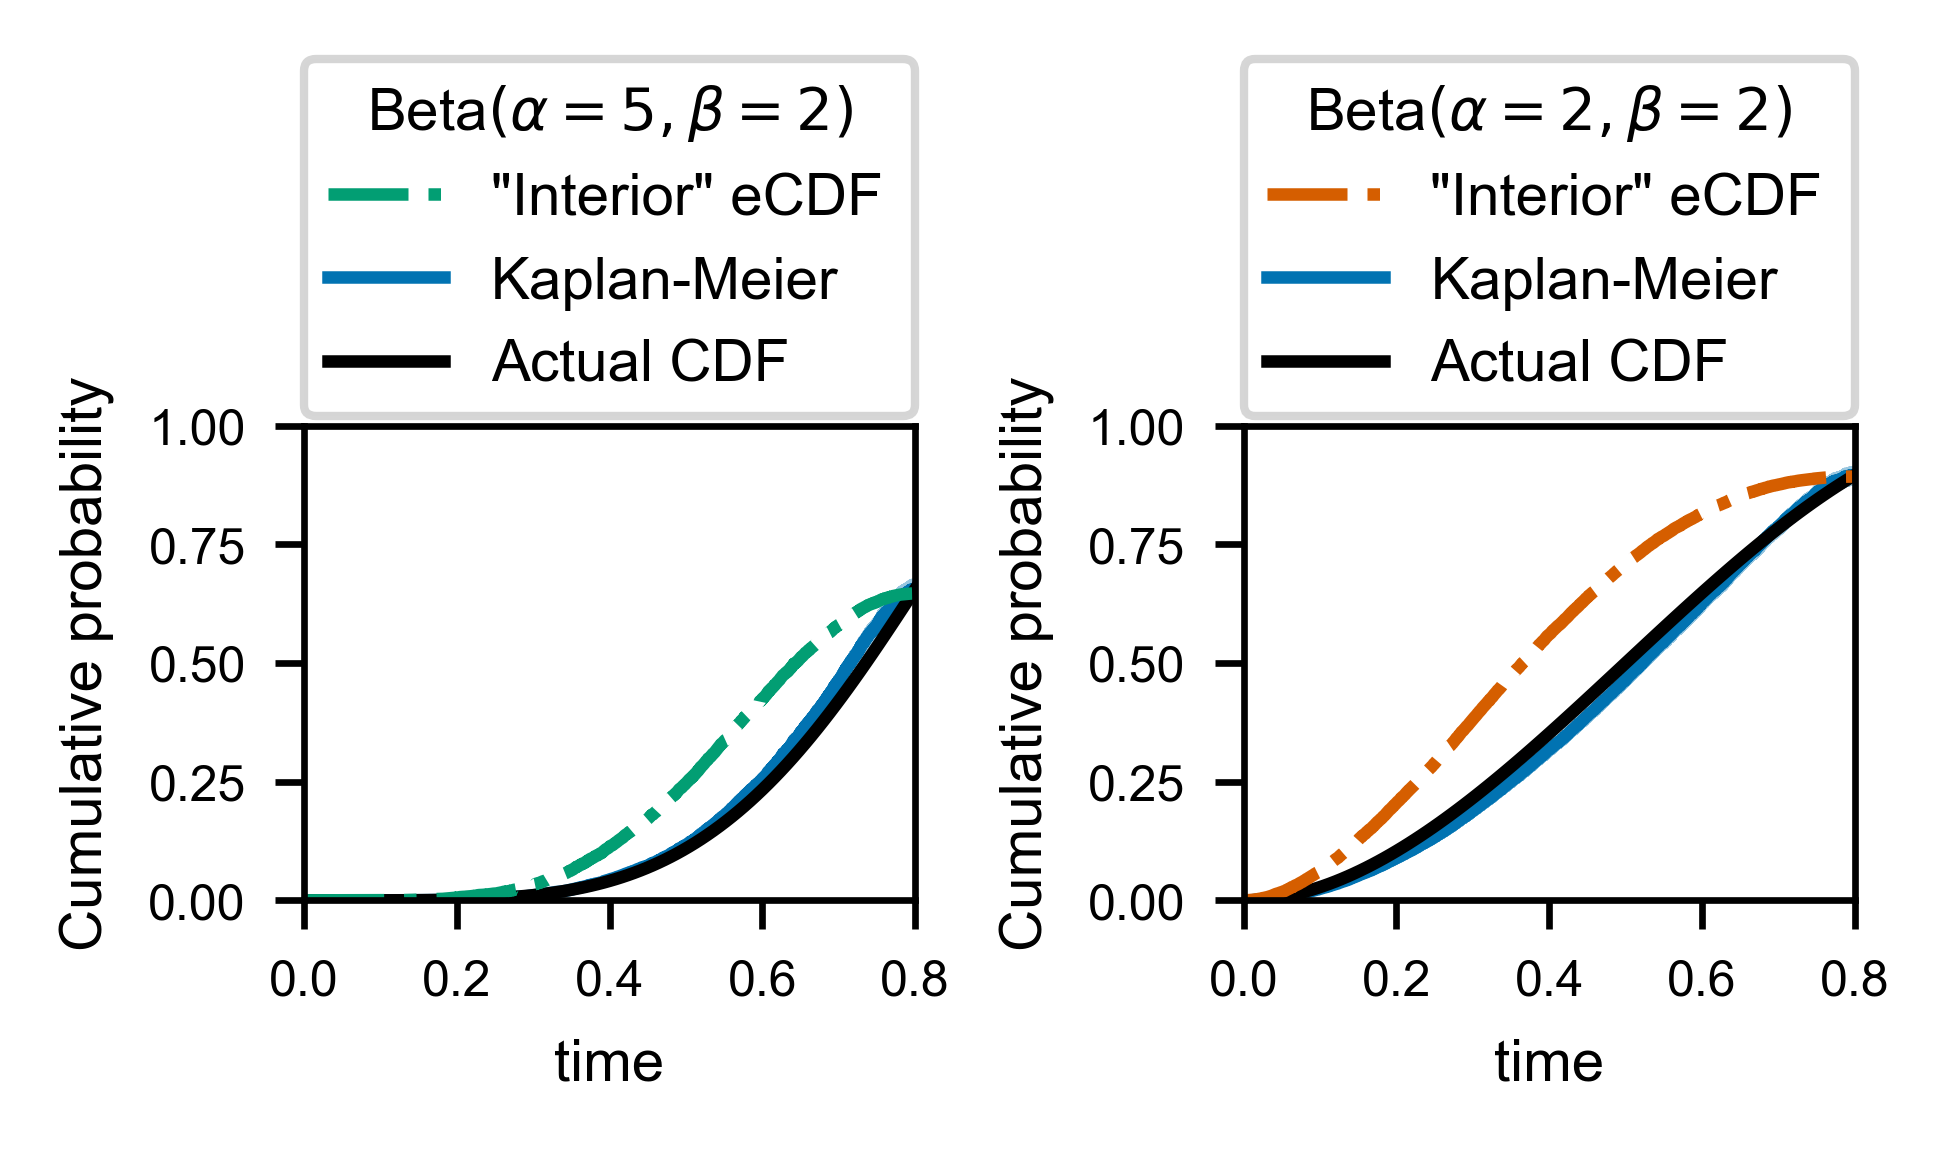

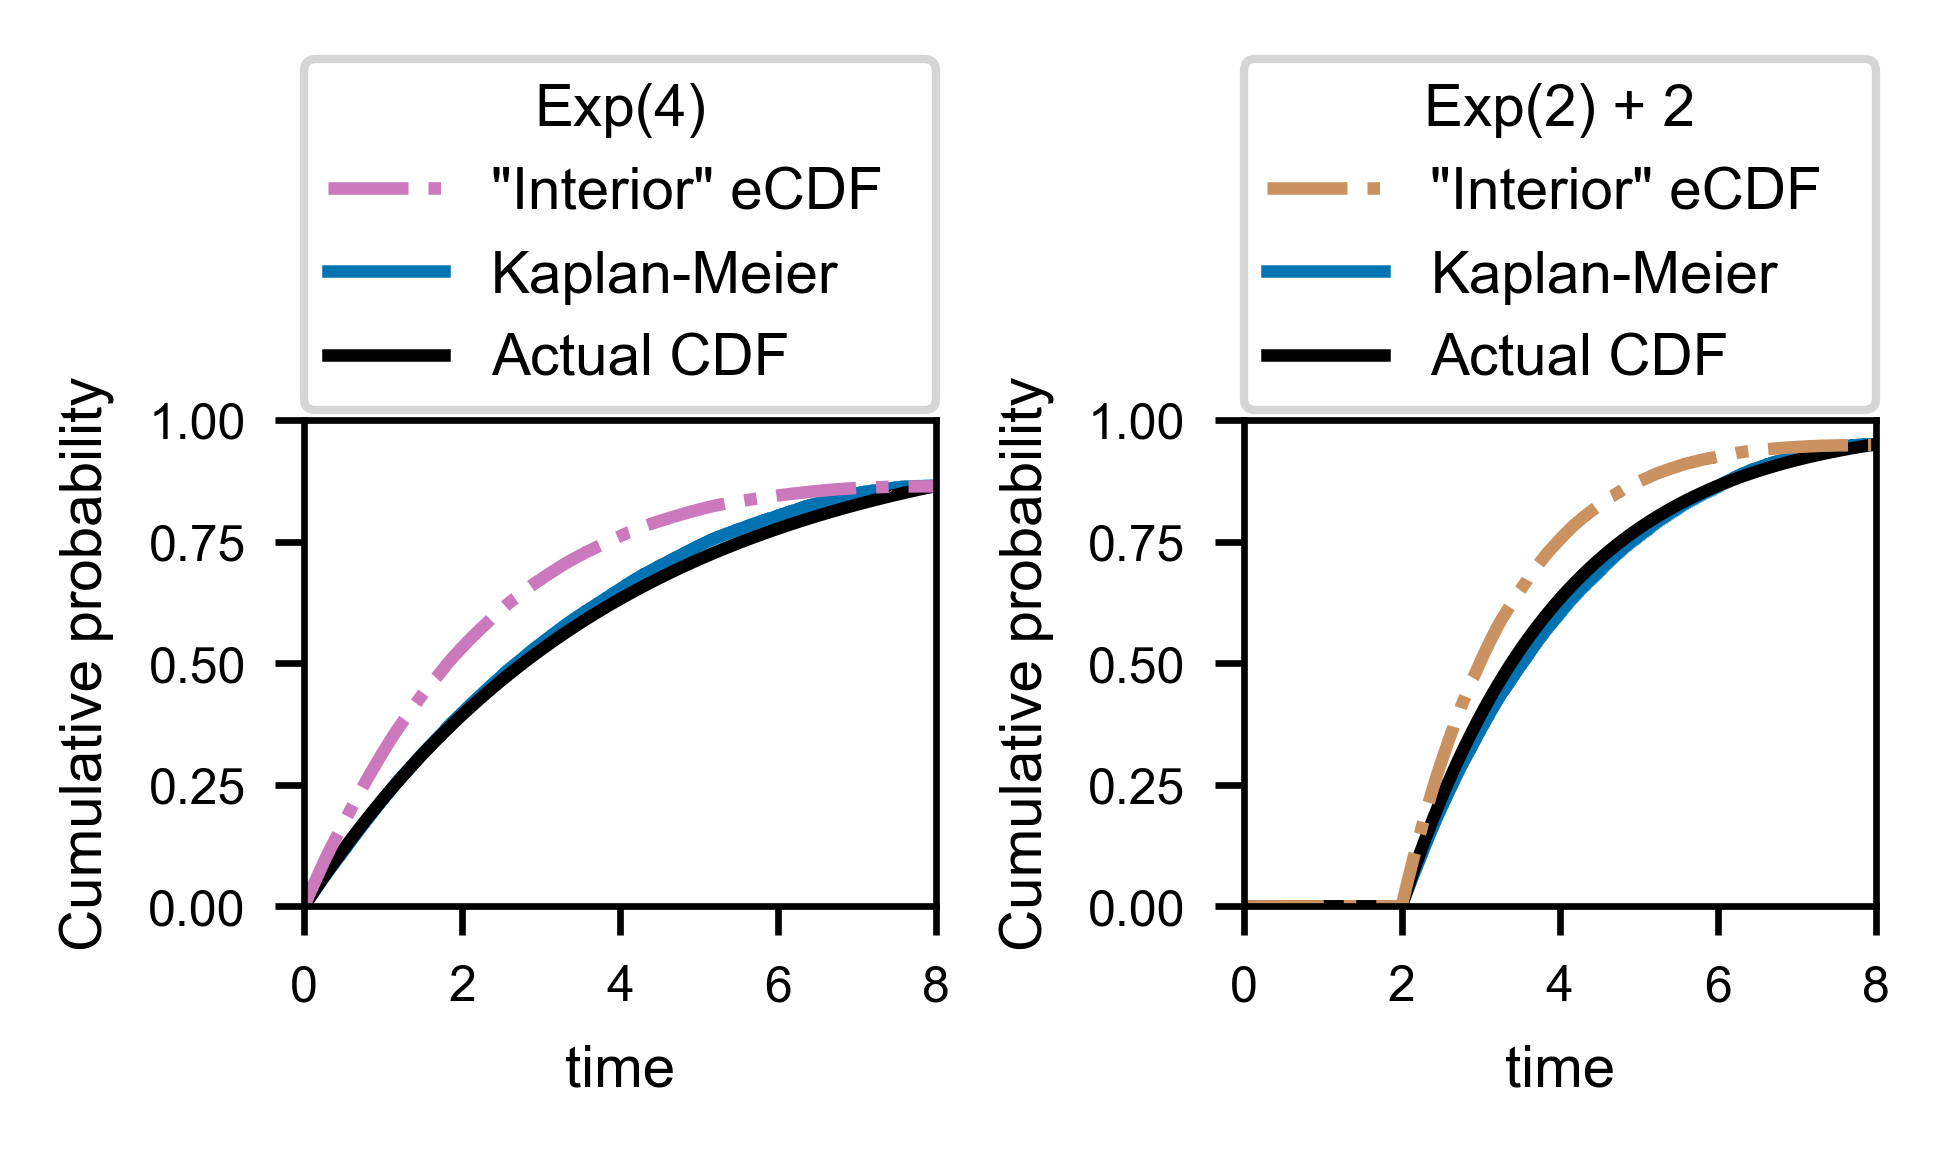

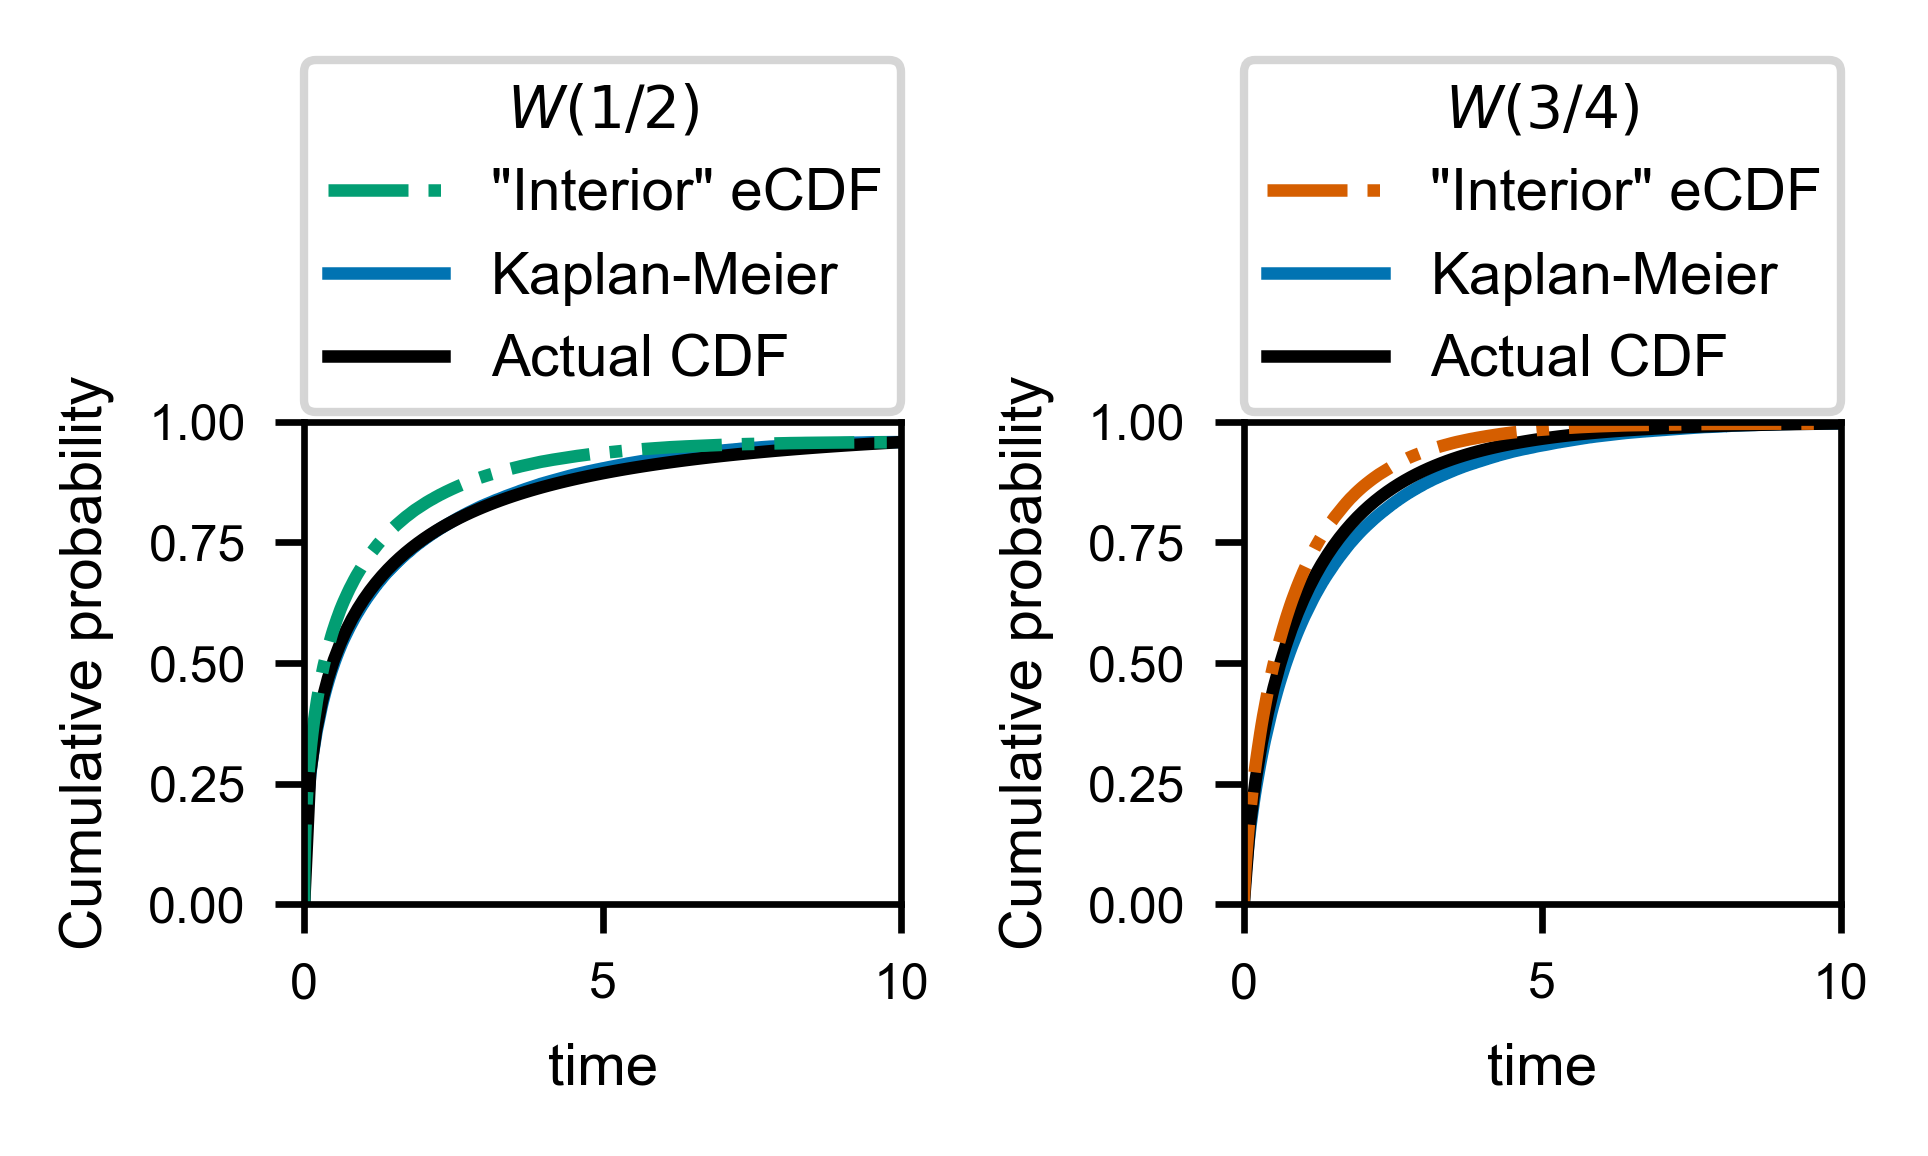

In [311]:
for pair_name, obs in observations.items():
    fig = fplt.compare_interior_kaplan(obs, variable_pairs[pair_name], rescale_kaplan=True, rescale_interior=True)
    save(fig, f'kaplan-rescaled-{pair_name}.pdf')

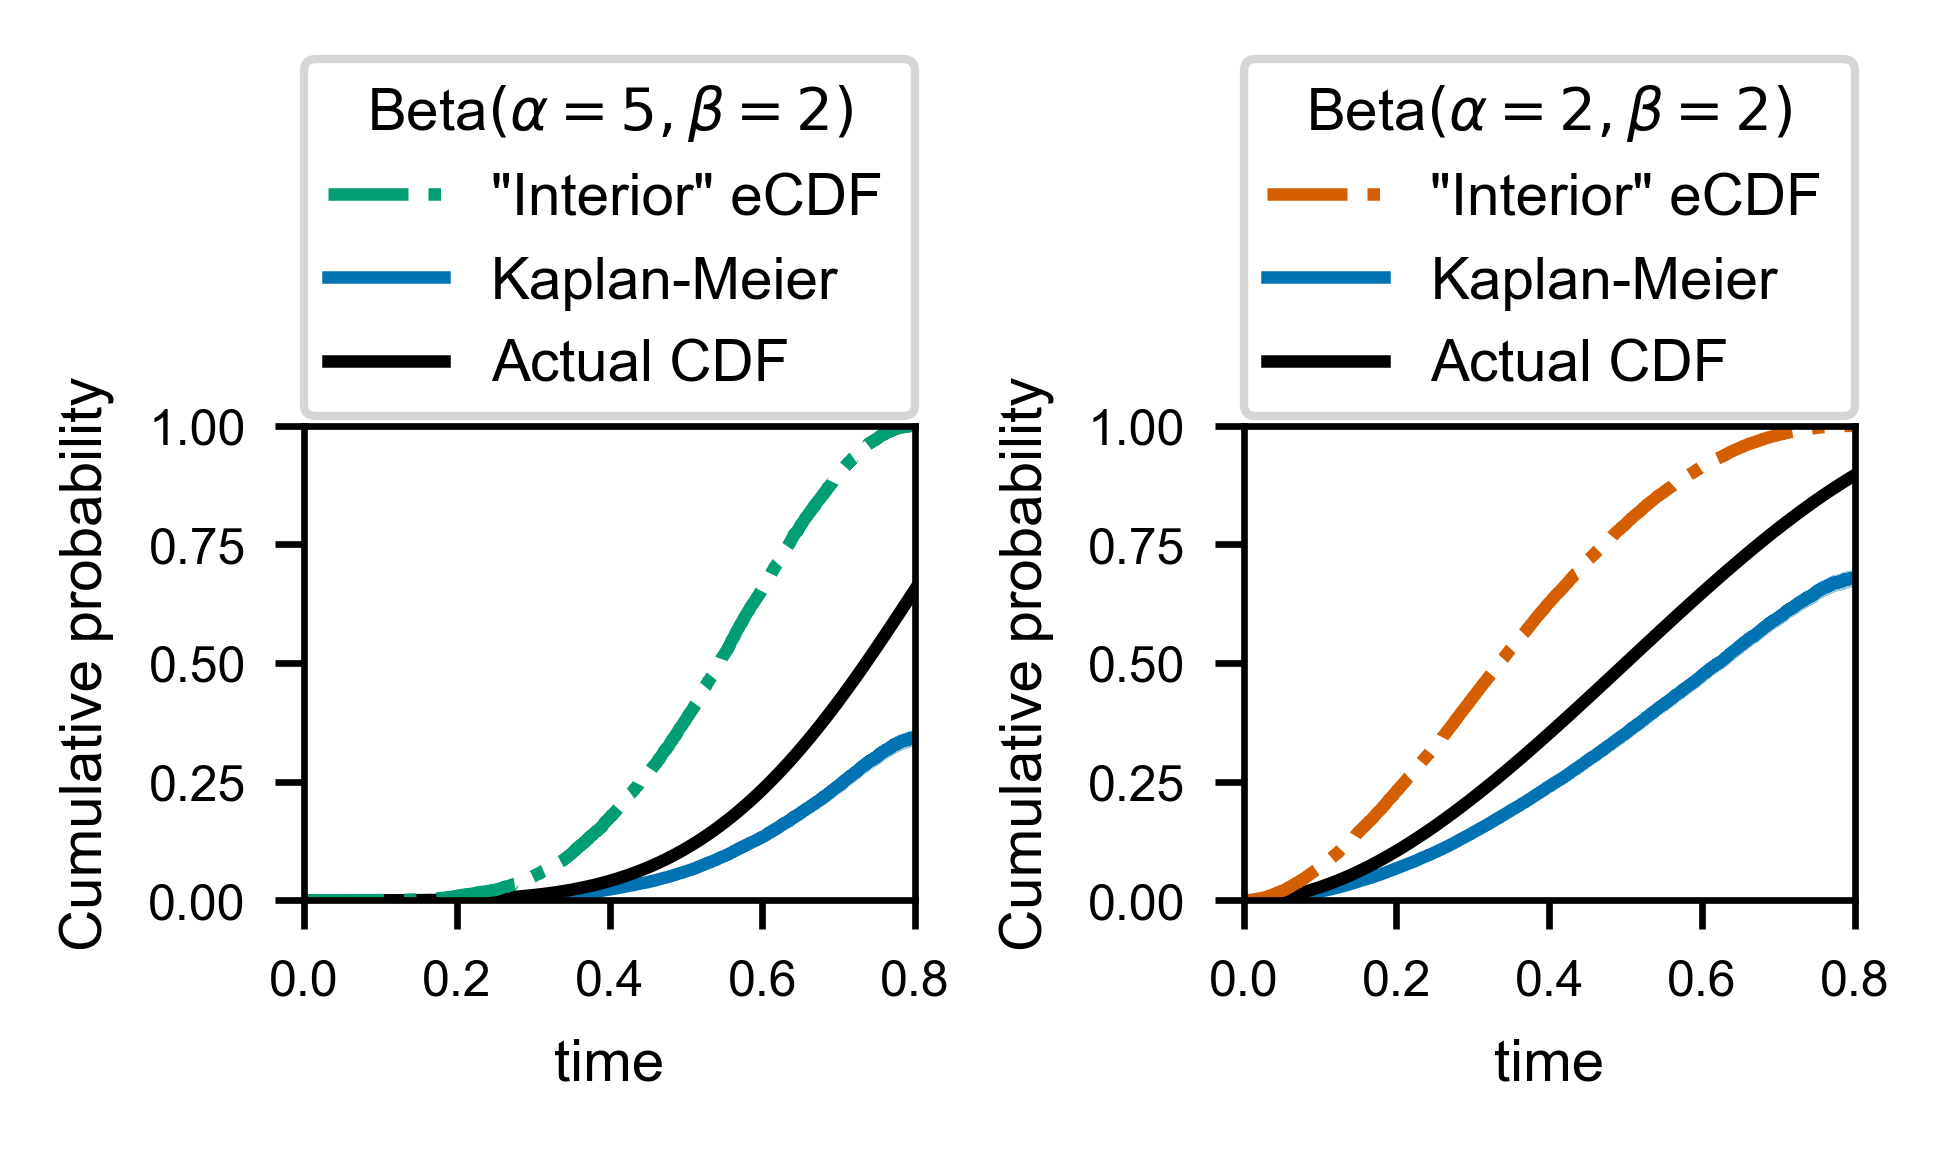

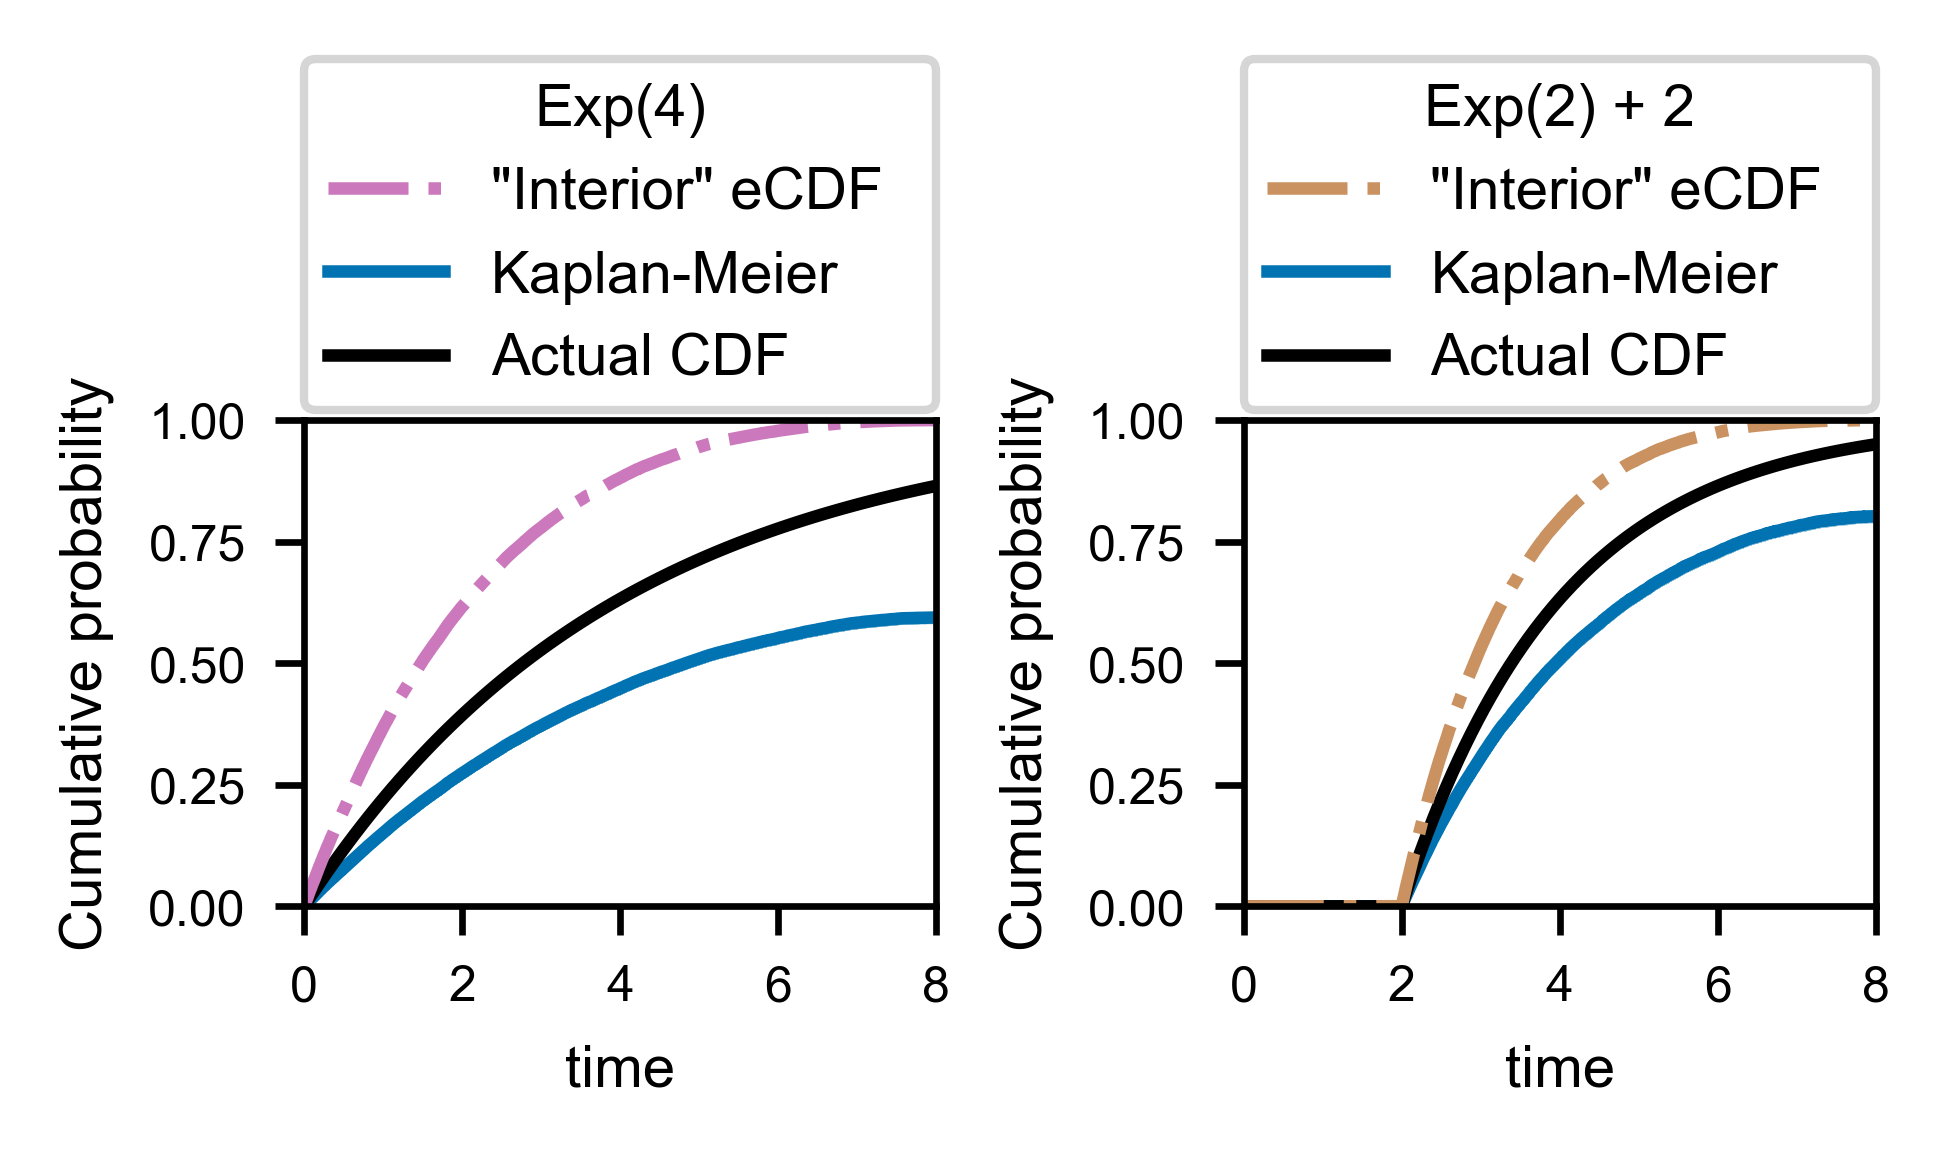

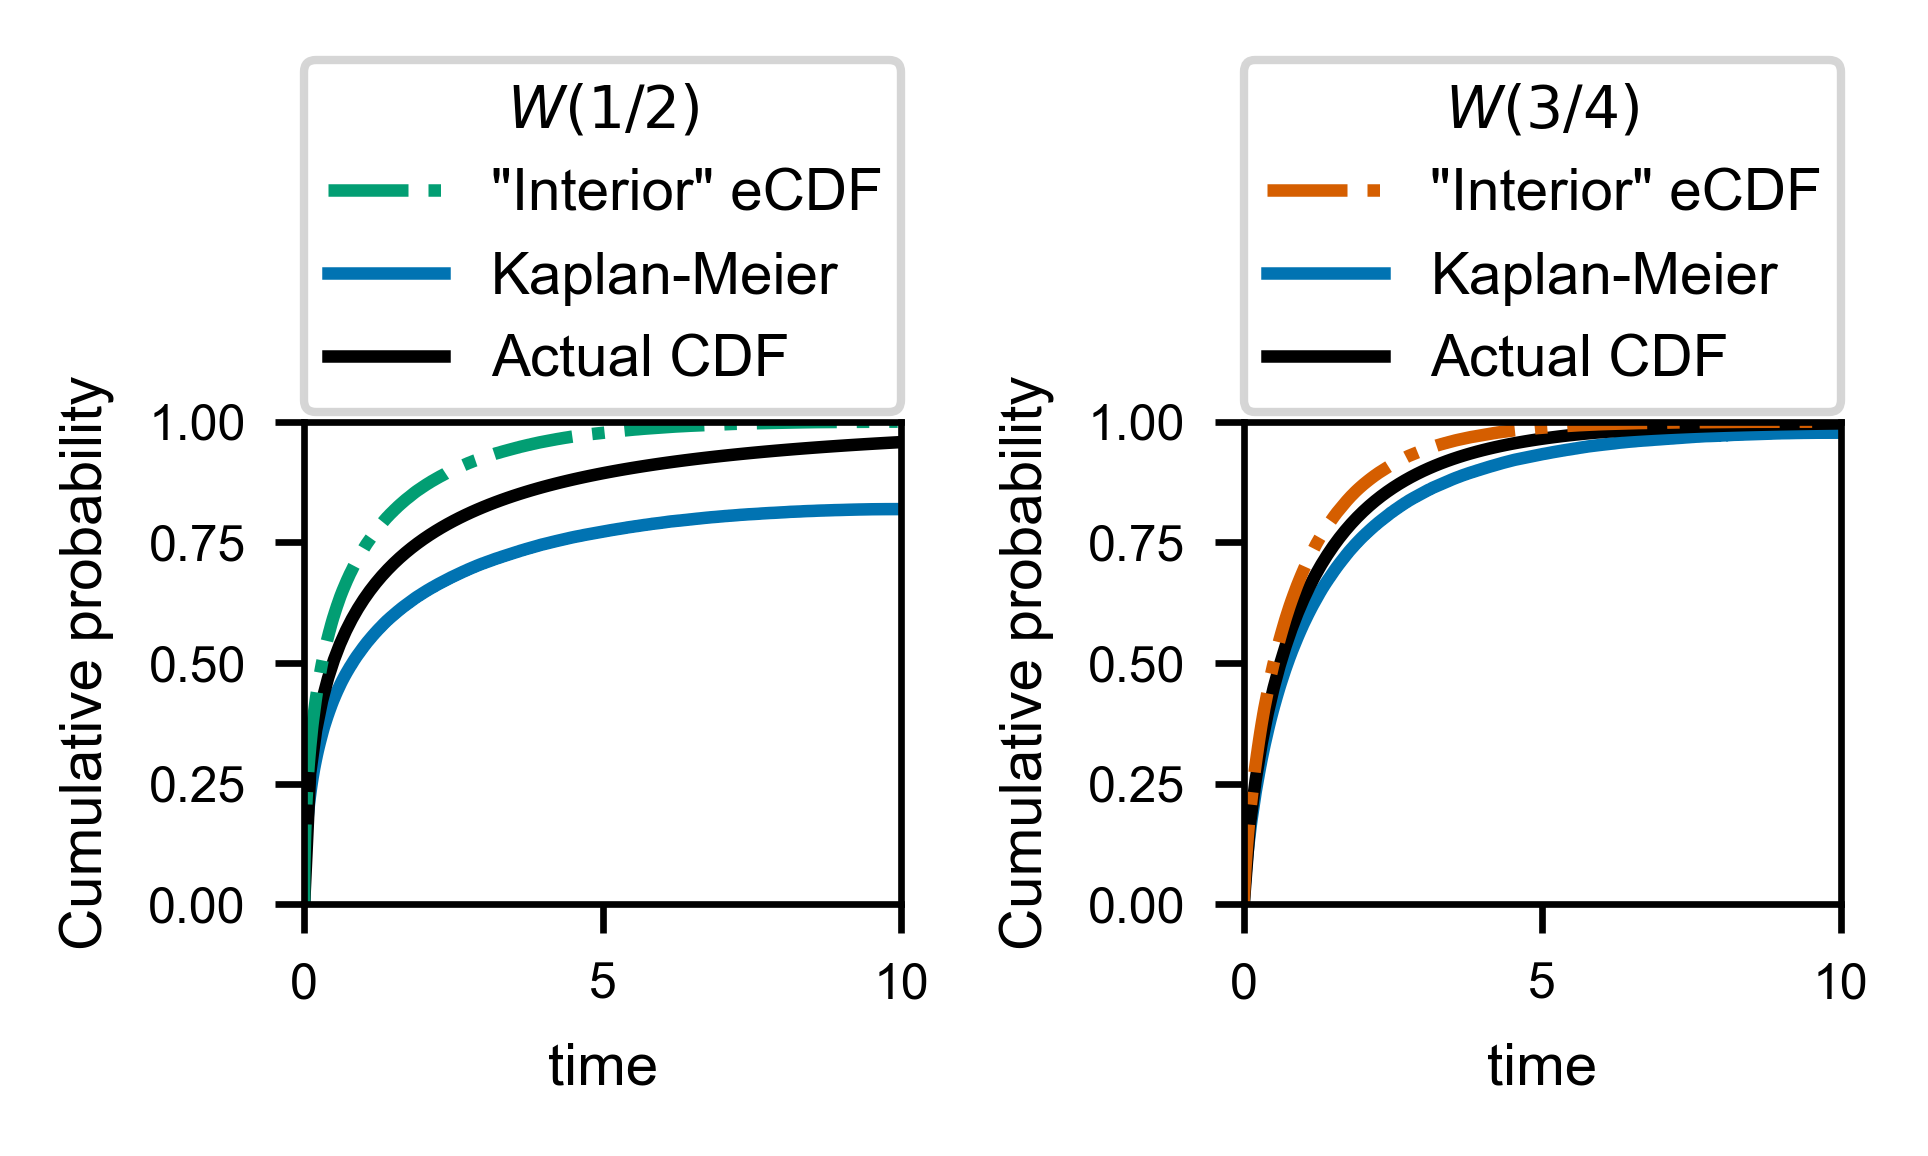

In [312]:
for pair_name, obs in observations.items():
    fig = fplt.compare_interior_kaplan(obs, variable_pairs[pair_name])
    save(fig, f'kaplan-comparison-{pair_name}.pdf')

## Exterior Times to Survival function

In order to correctly reproduce the actual underlying distribution, we must instead explicitly handle the "exterior censored" and "interior censored" times specially.

The exterior times are easy, as it can be shown (see "Theoretical Details" section below) that the probability distribution of the exterior times is exactly the survival function of the true waiting time distributions, normalized to one:

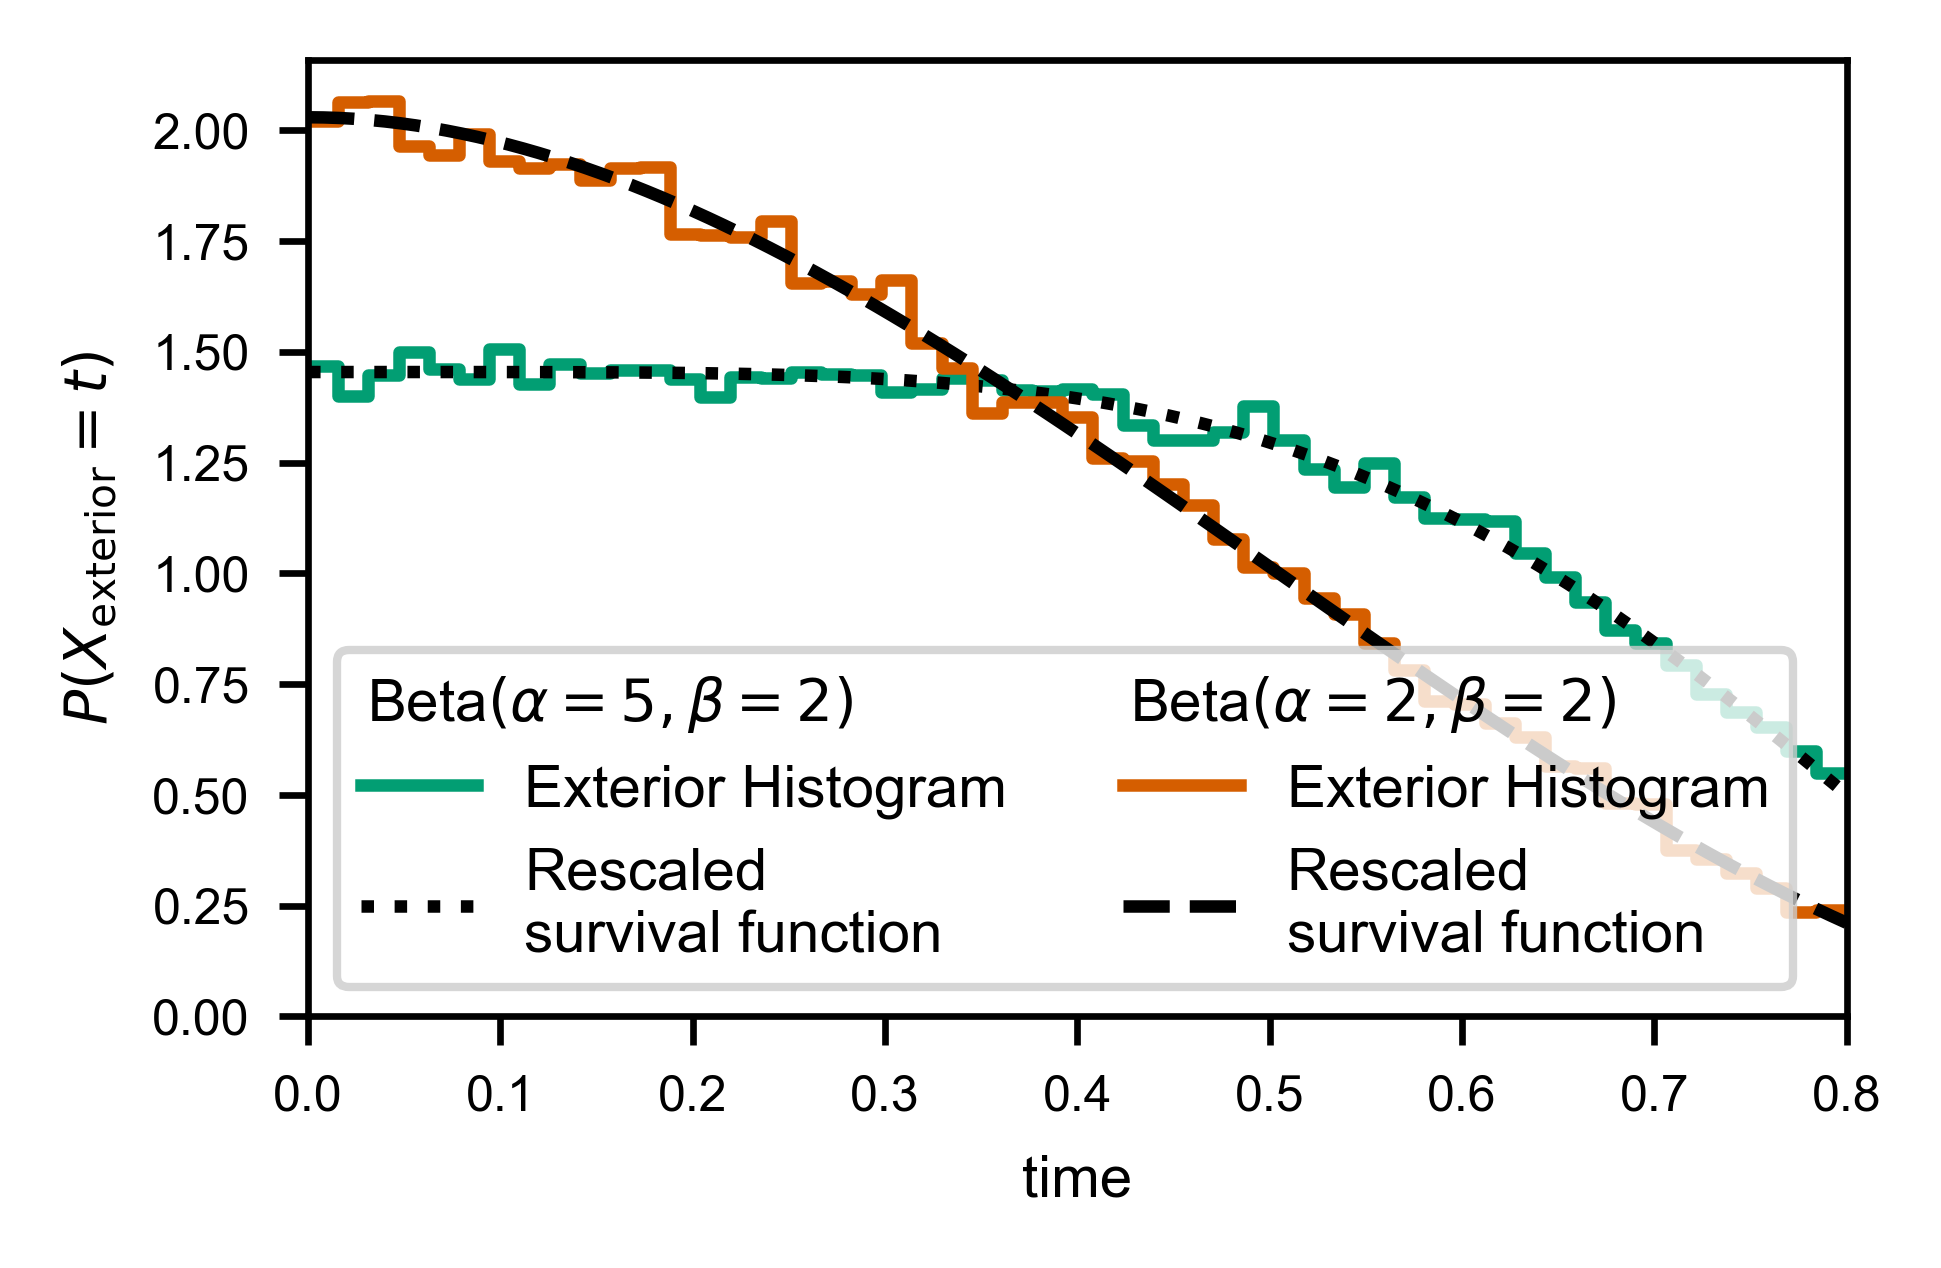

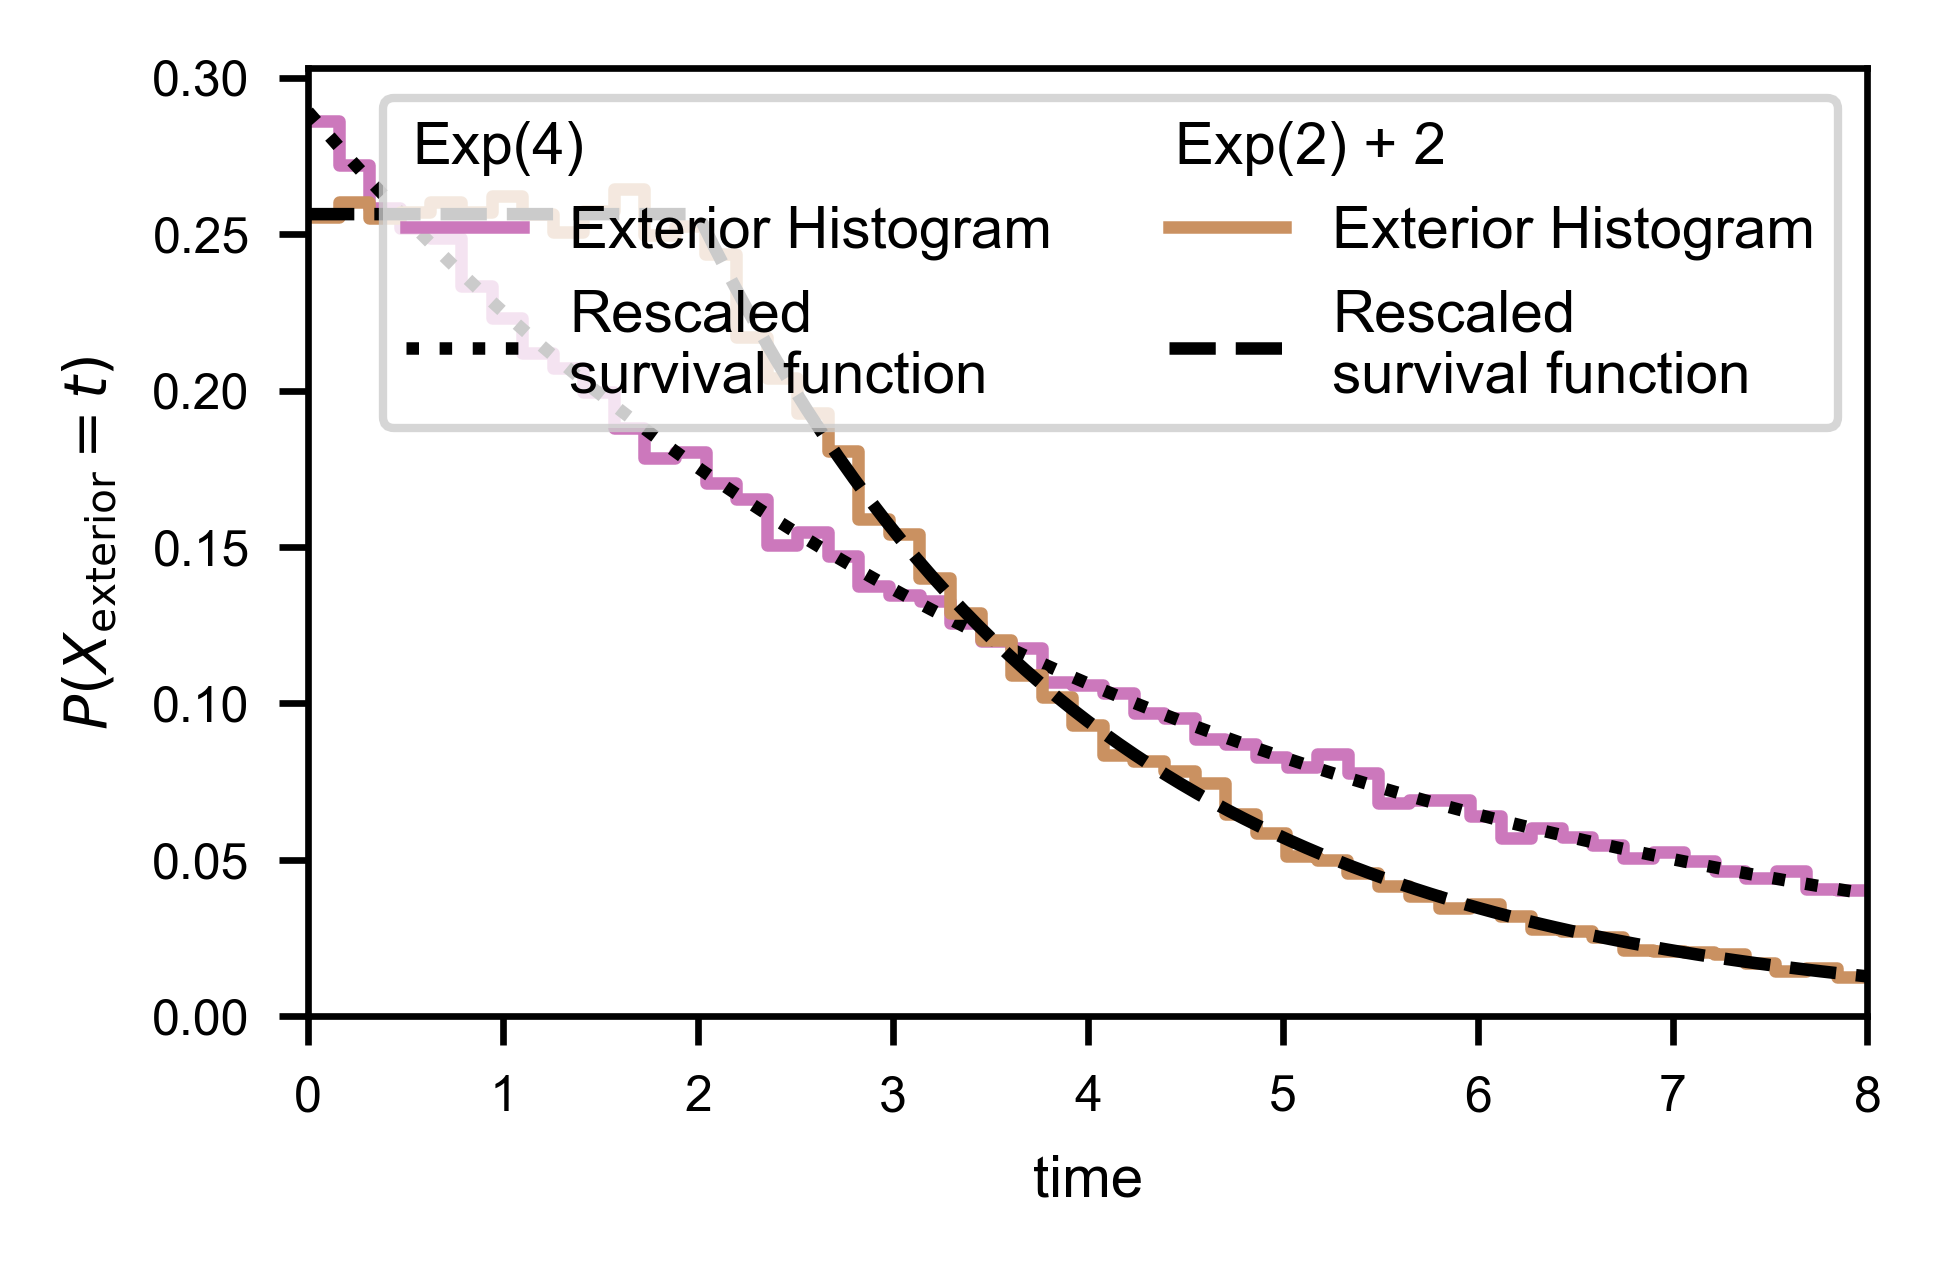

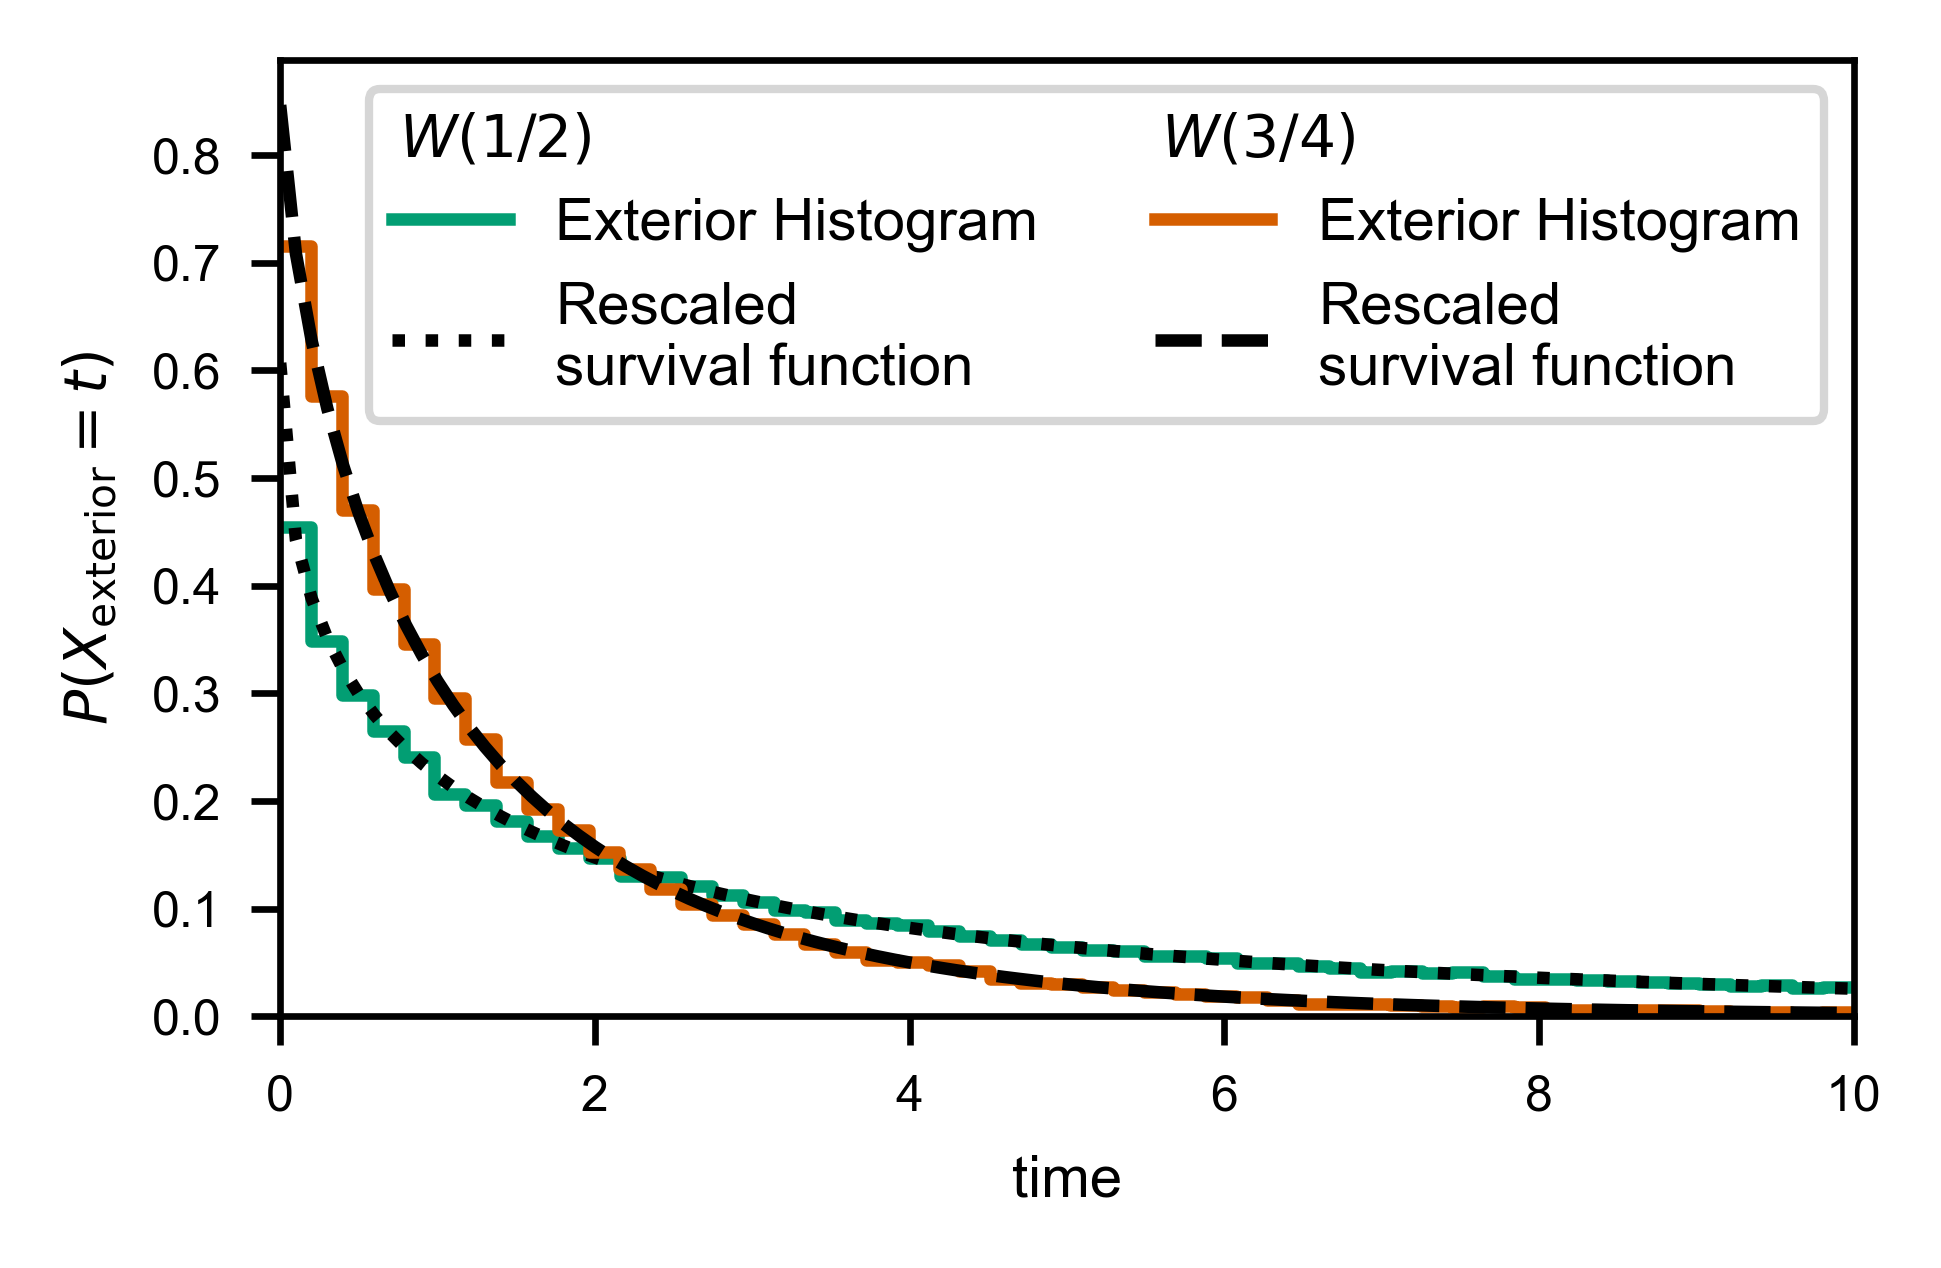

In [323]:
for name, obs in observations.items():
    fig = fplt.exterior_hist(obs, variable_pairs[name])
    save(fig, f'exterior-hist-{name}.pdf')

## Interior Times to Likelihood

To handle the interior times, we need simply weight each observed time $t_i$ by $1/(T - t_i)$, which can easily be accomplished using `np.histogram`. (See "Theoretical Details" section below for justification).

Because we only observe times up to $t=T$, we will actually be estimating:

$$ \hat{f}_X(t) \approx P(X = t | X \leq T) = f_X(t) / F_X(T) $$

where $\hat{f}$ is our corrected histogram, and $f_X$ and $F_X$ denote the probability distribution function (PDF) and cumulative distribution functions (CDF) of the random variable $X$, respectively.

### PDF

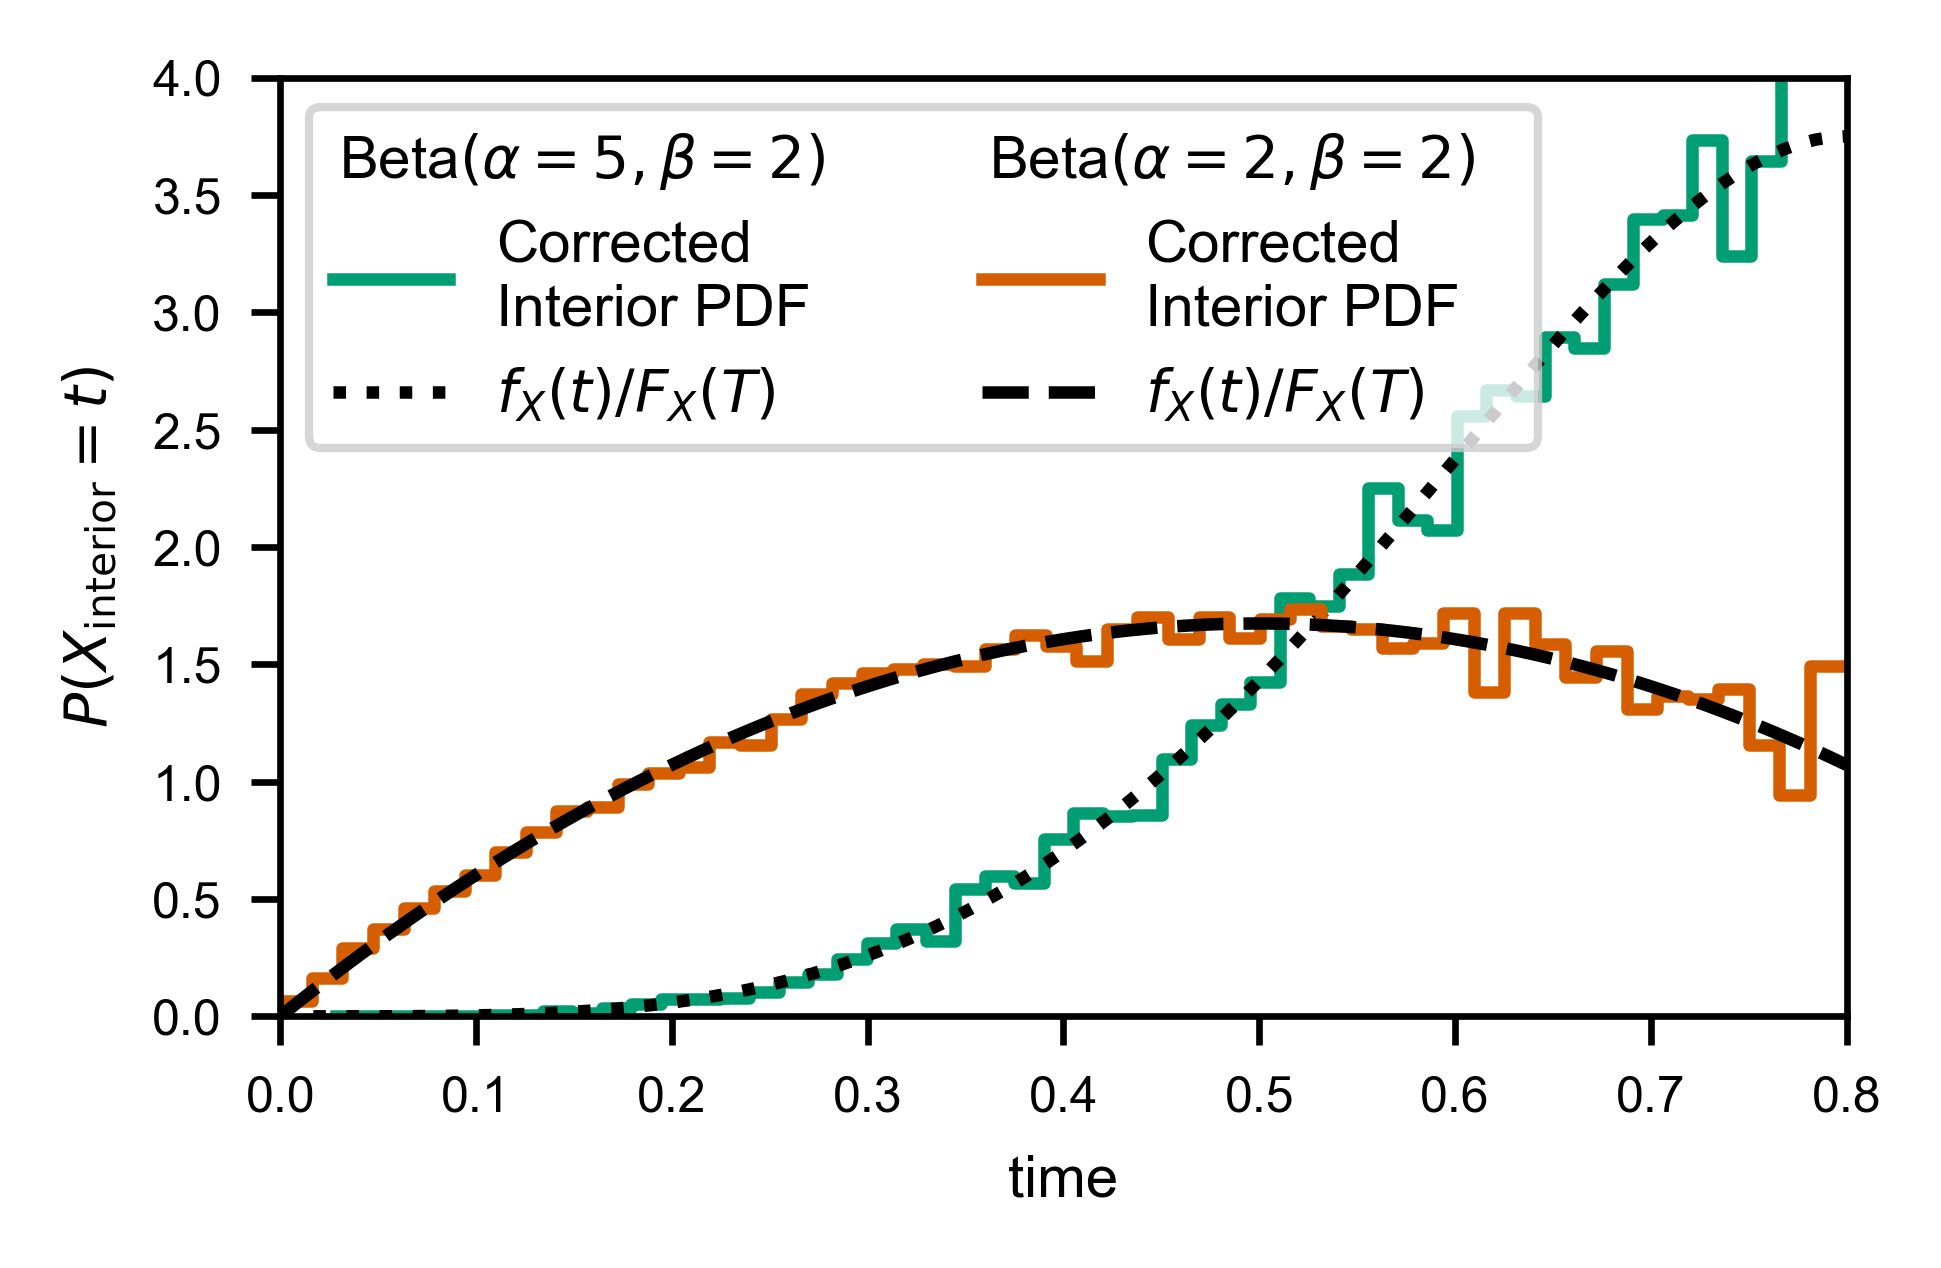

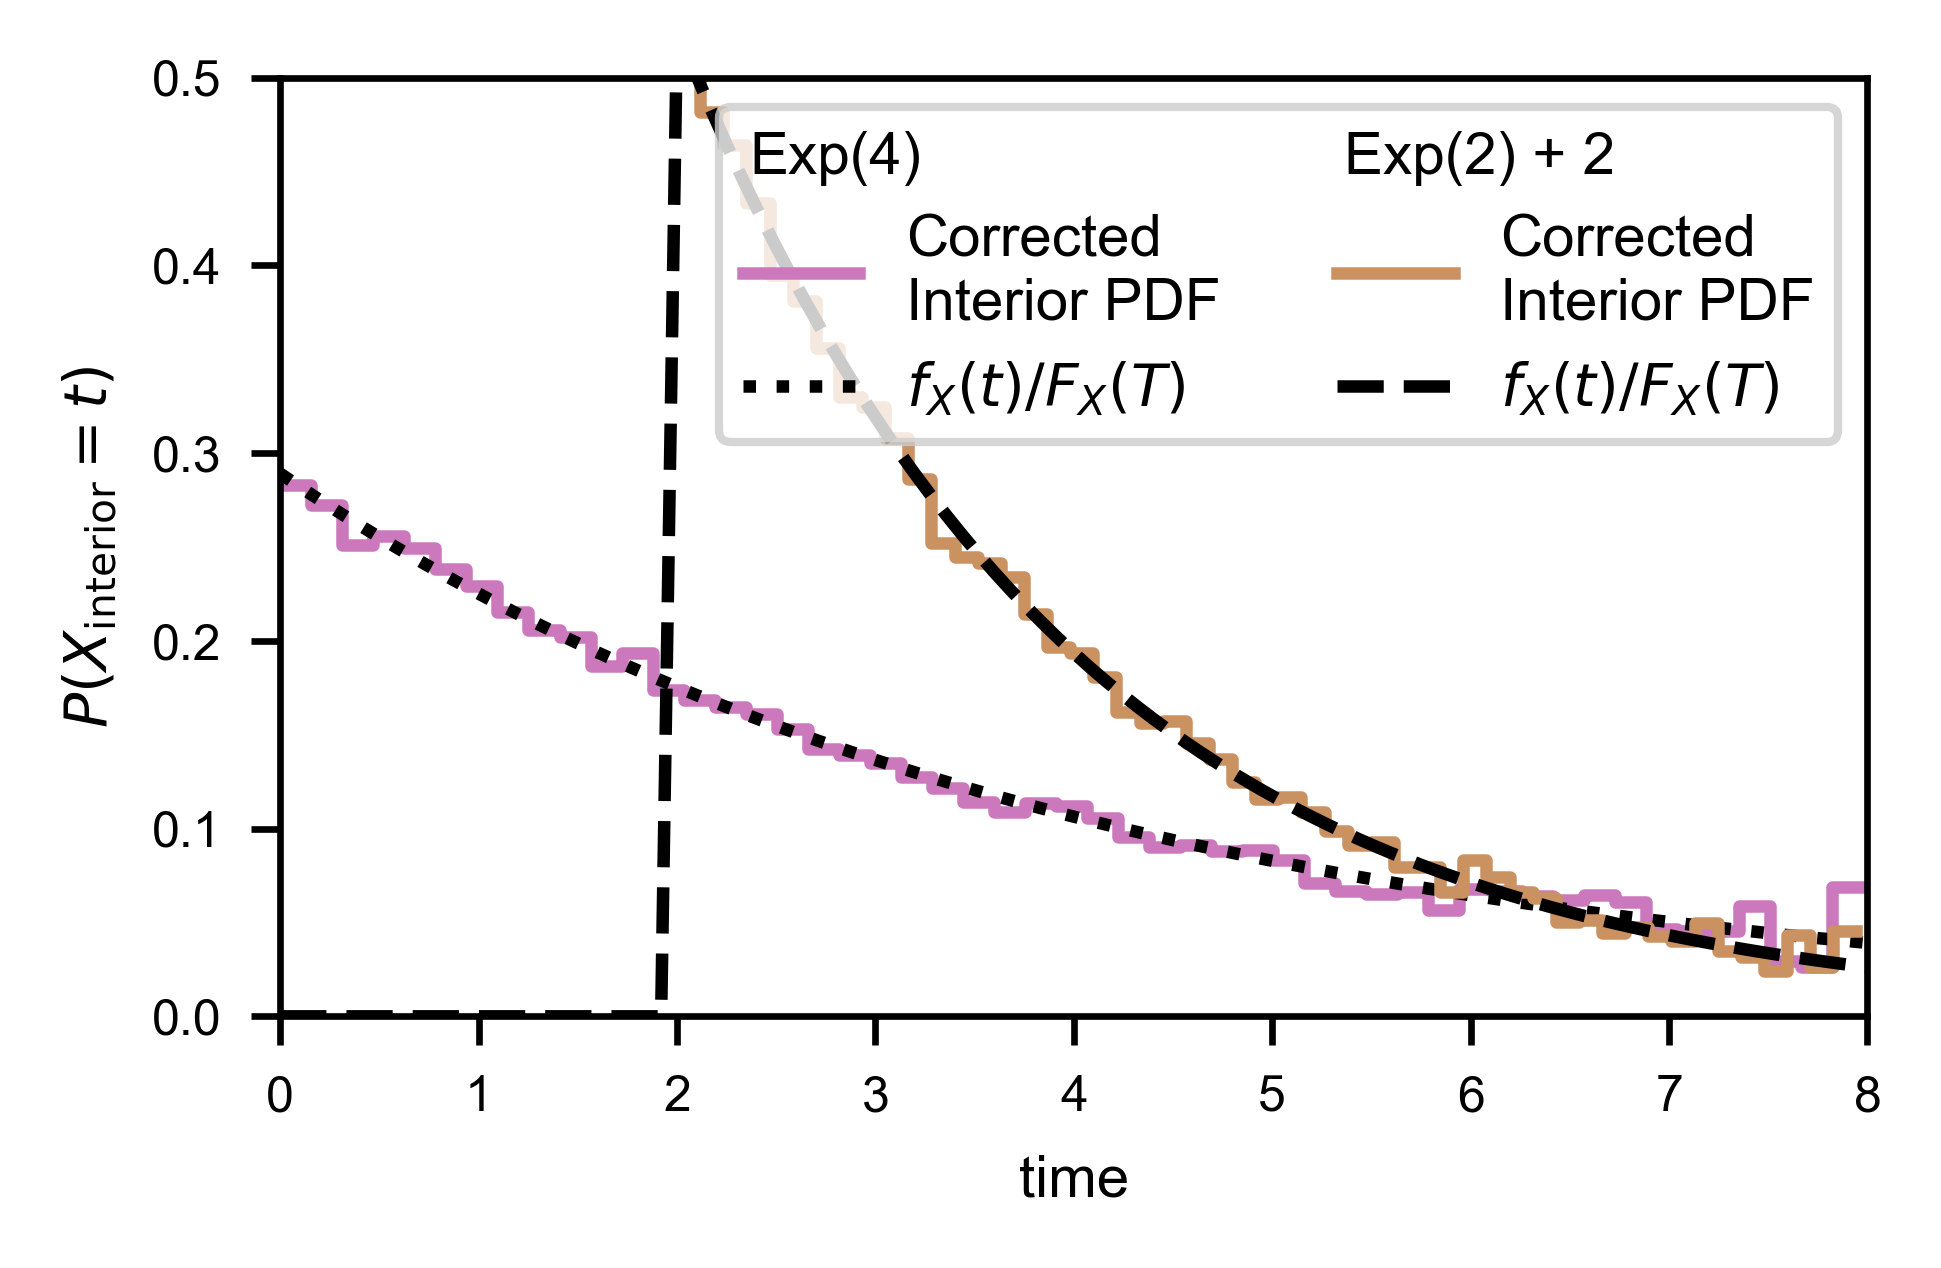

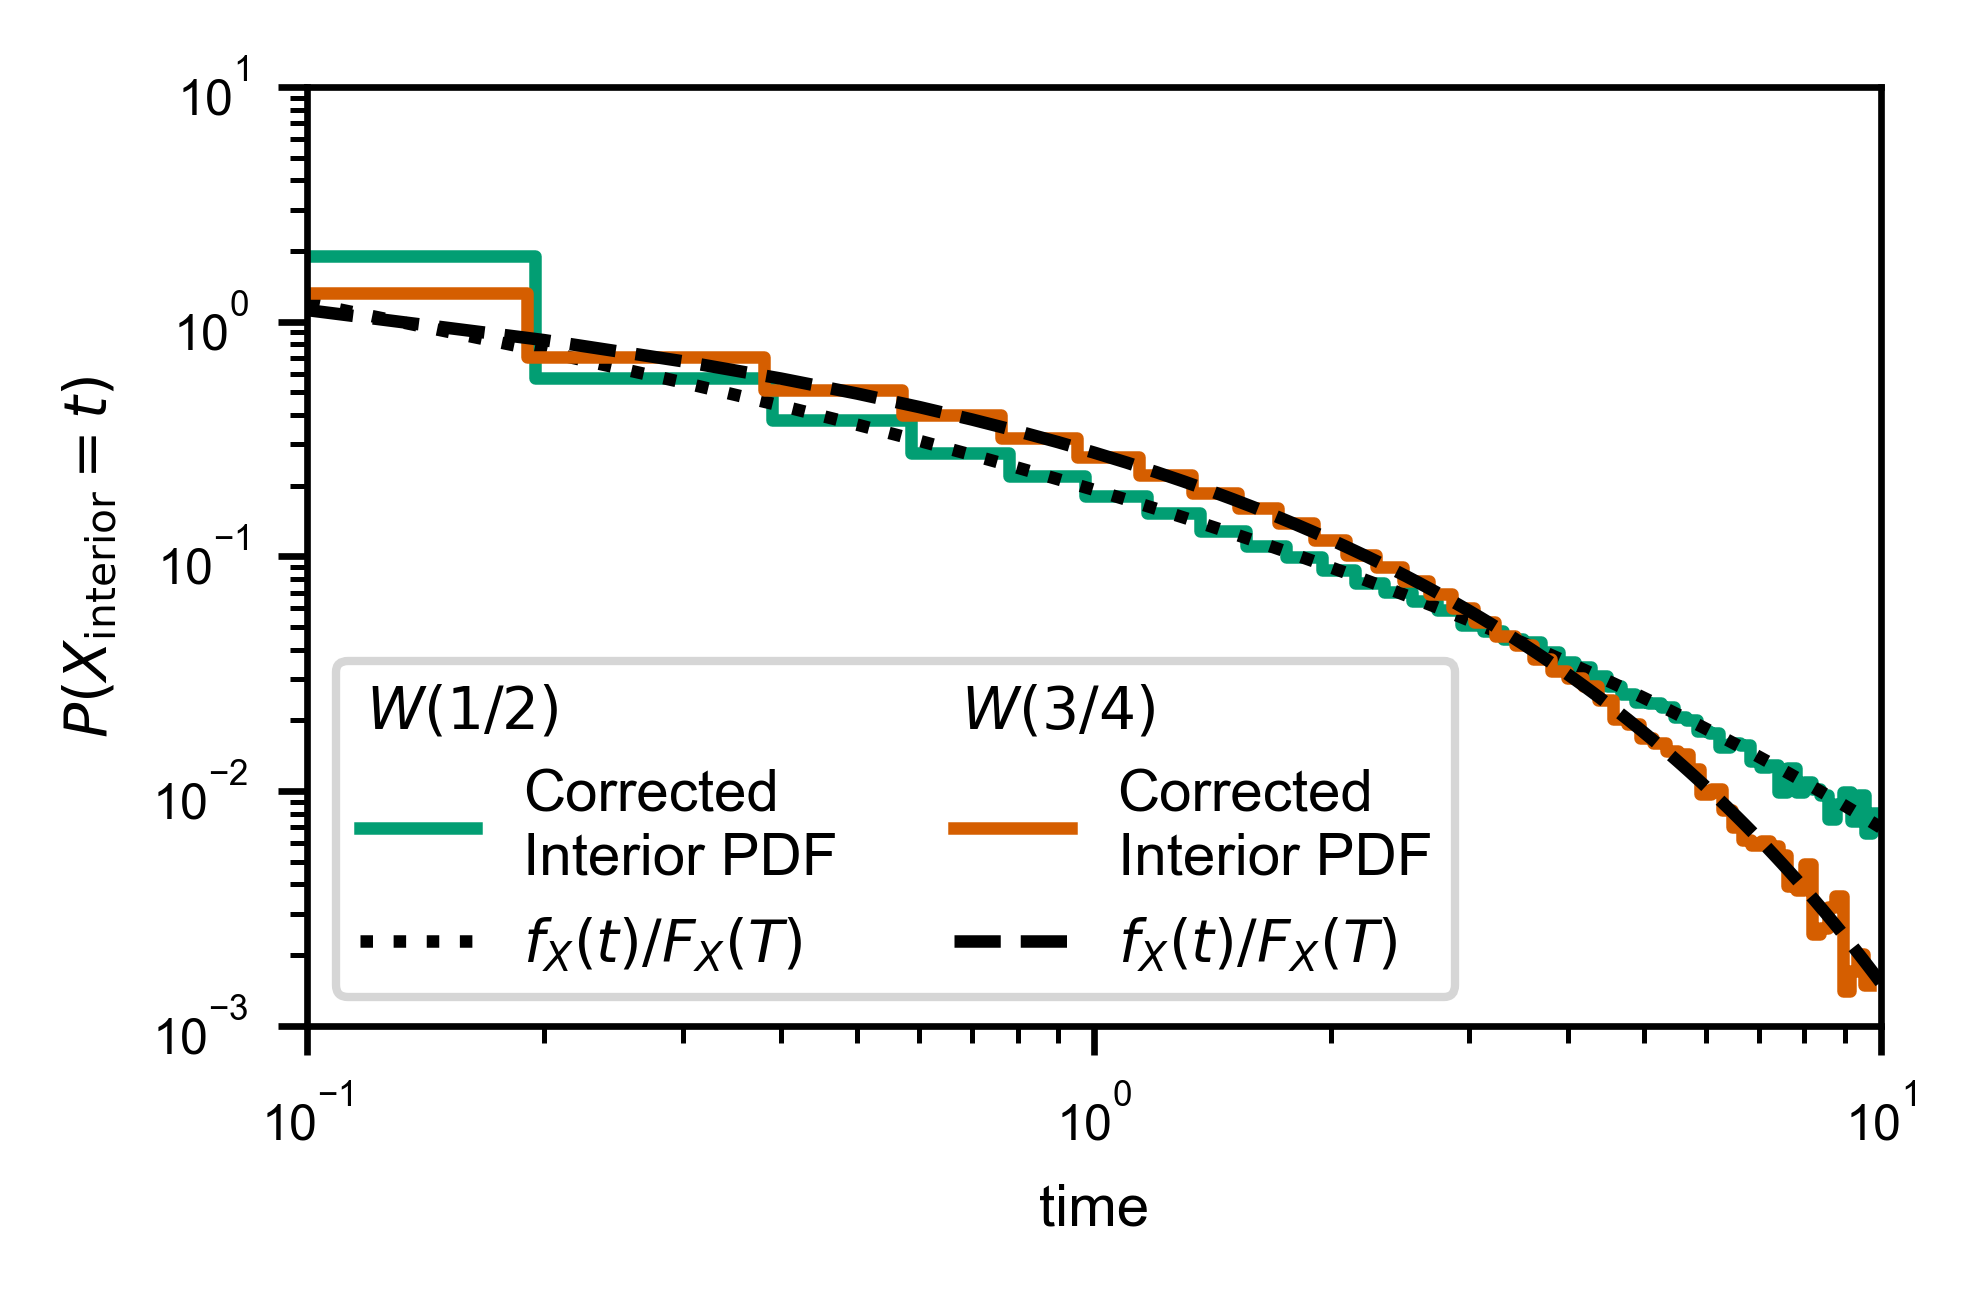

In [325]:
for name, obs in observations.items():
    fig = fplt.corrected_interior_pdf(obs, variable_pairs[name])
    save(fig, f'interior-hist-corrected-{name}.pdf')
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-1, 1e1])
plt.ylim([1e-3, 1e1])
save(fig, f'interior-hist-corrected-{name}.pdf')


### CDF

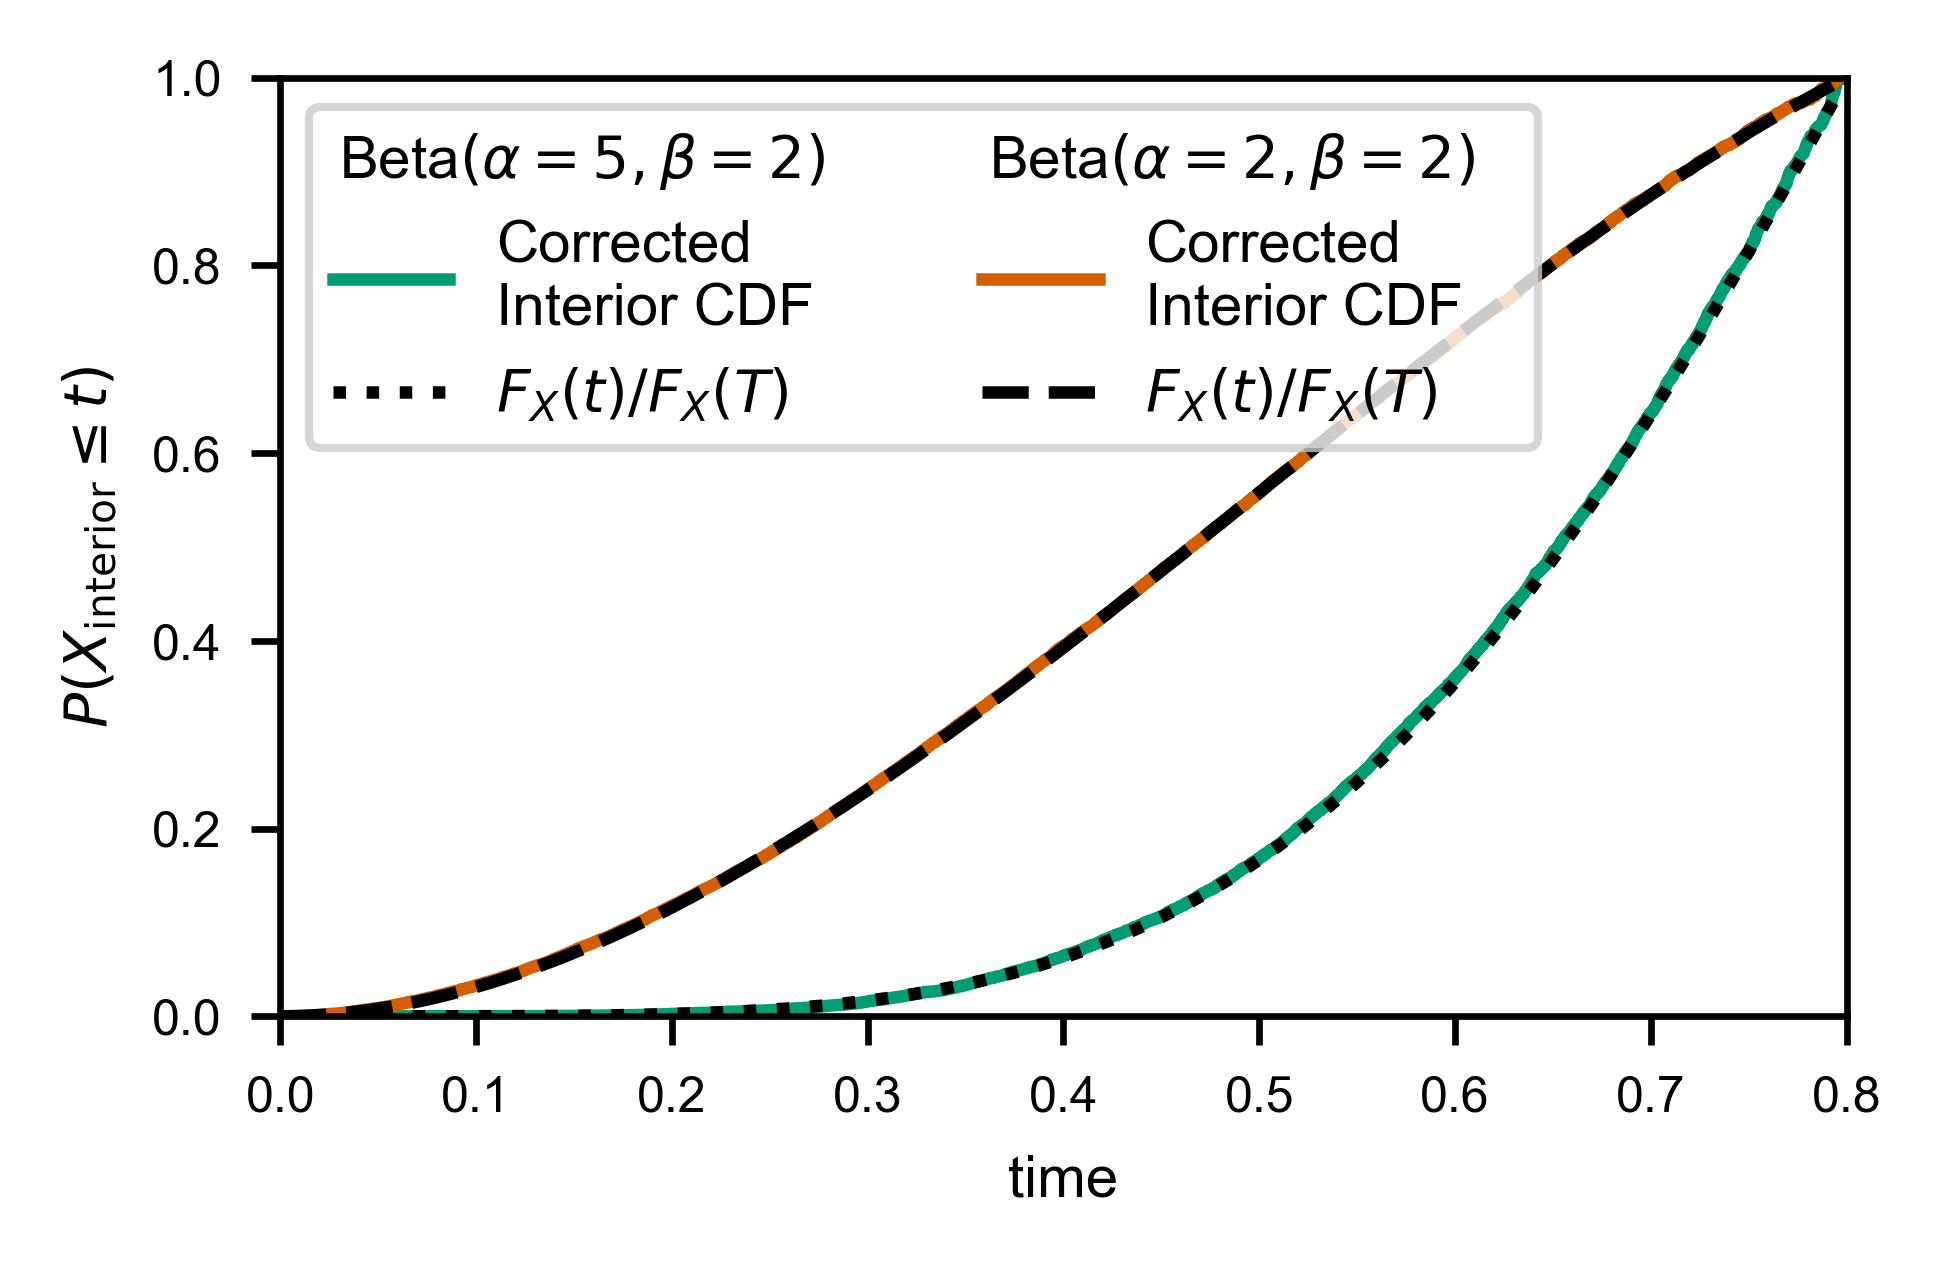

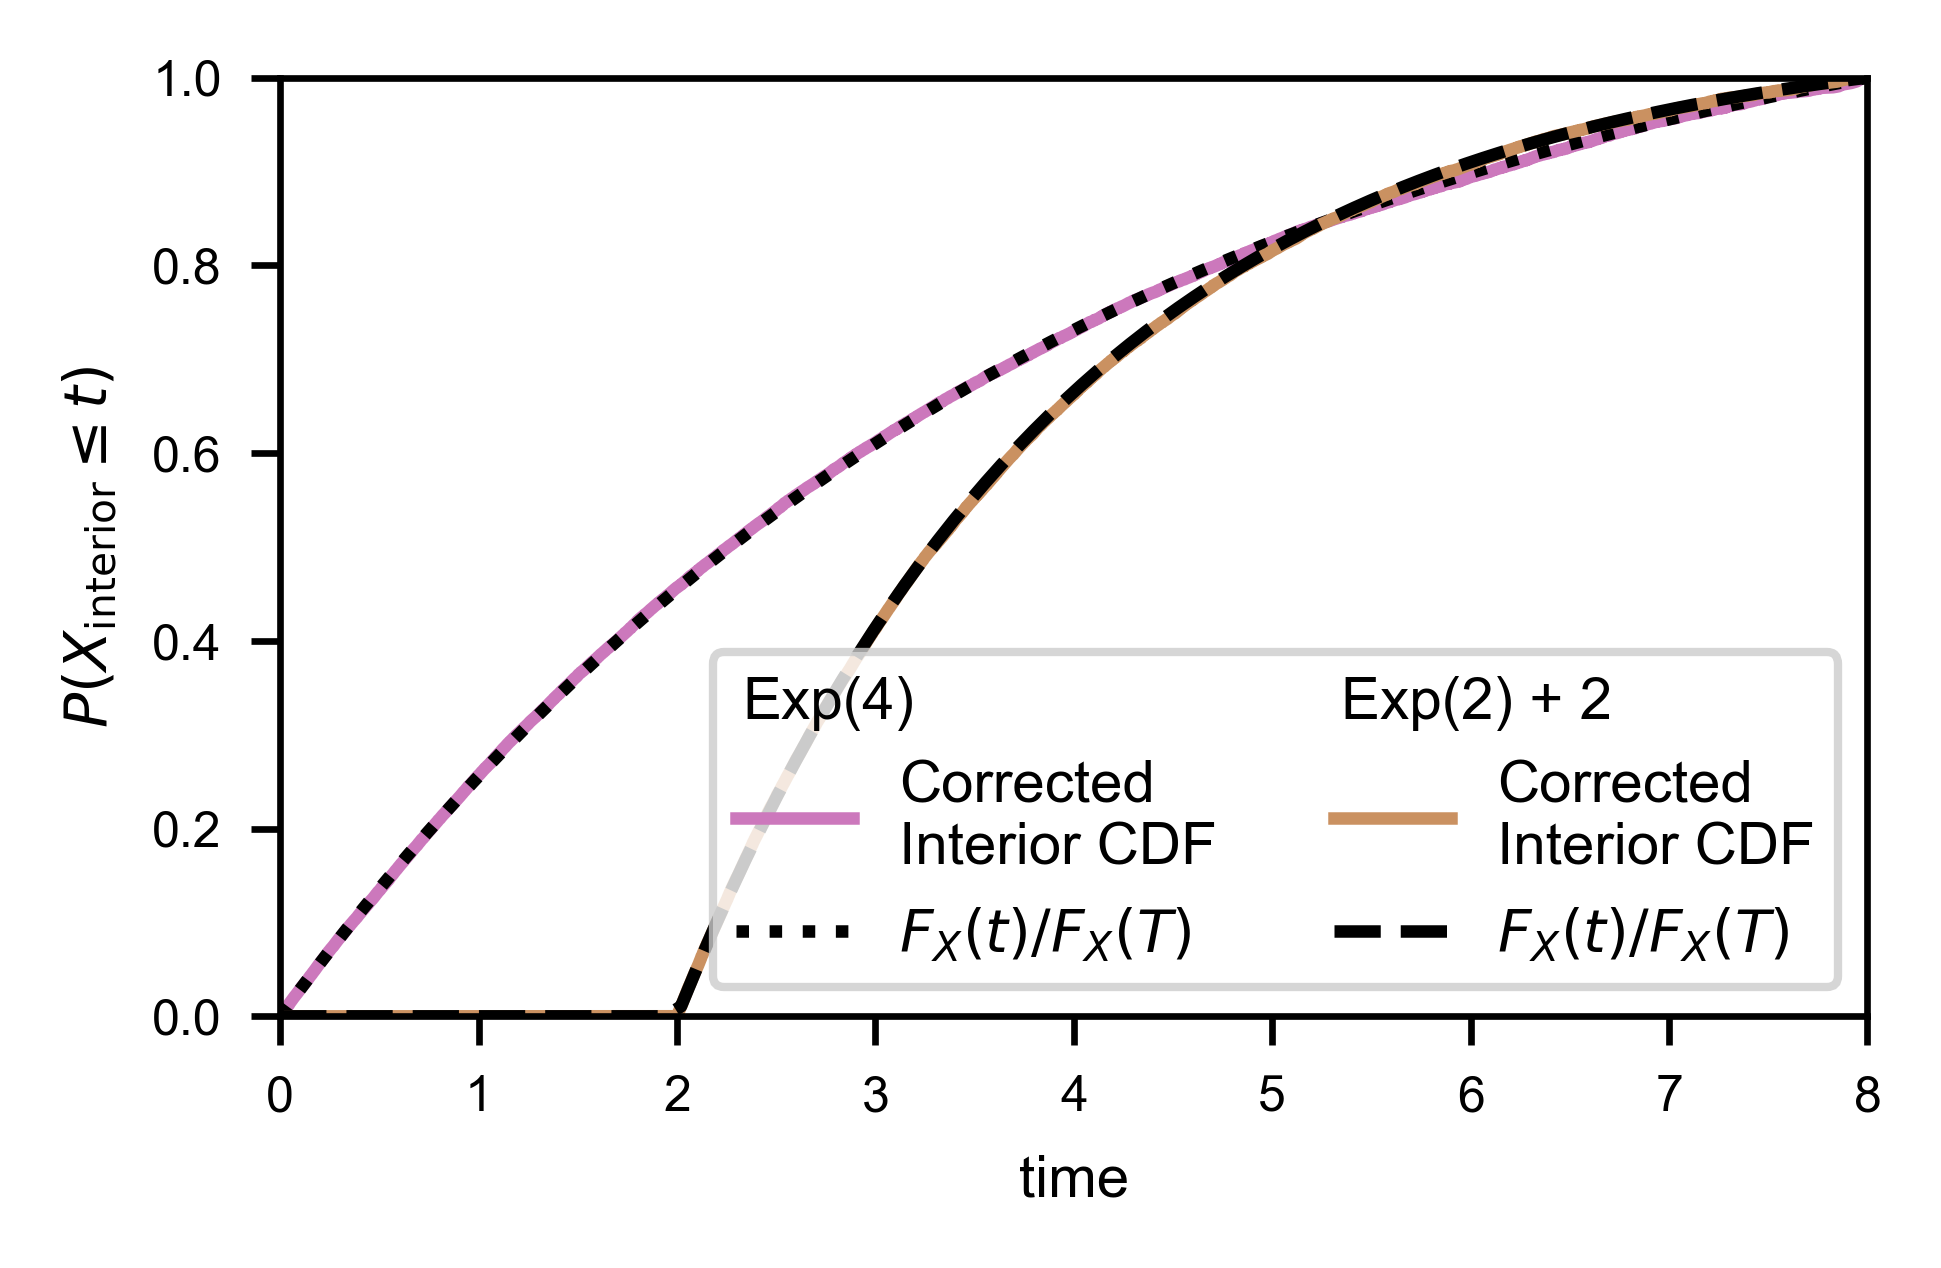

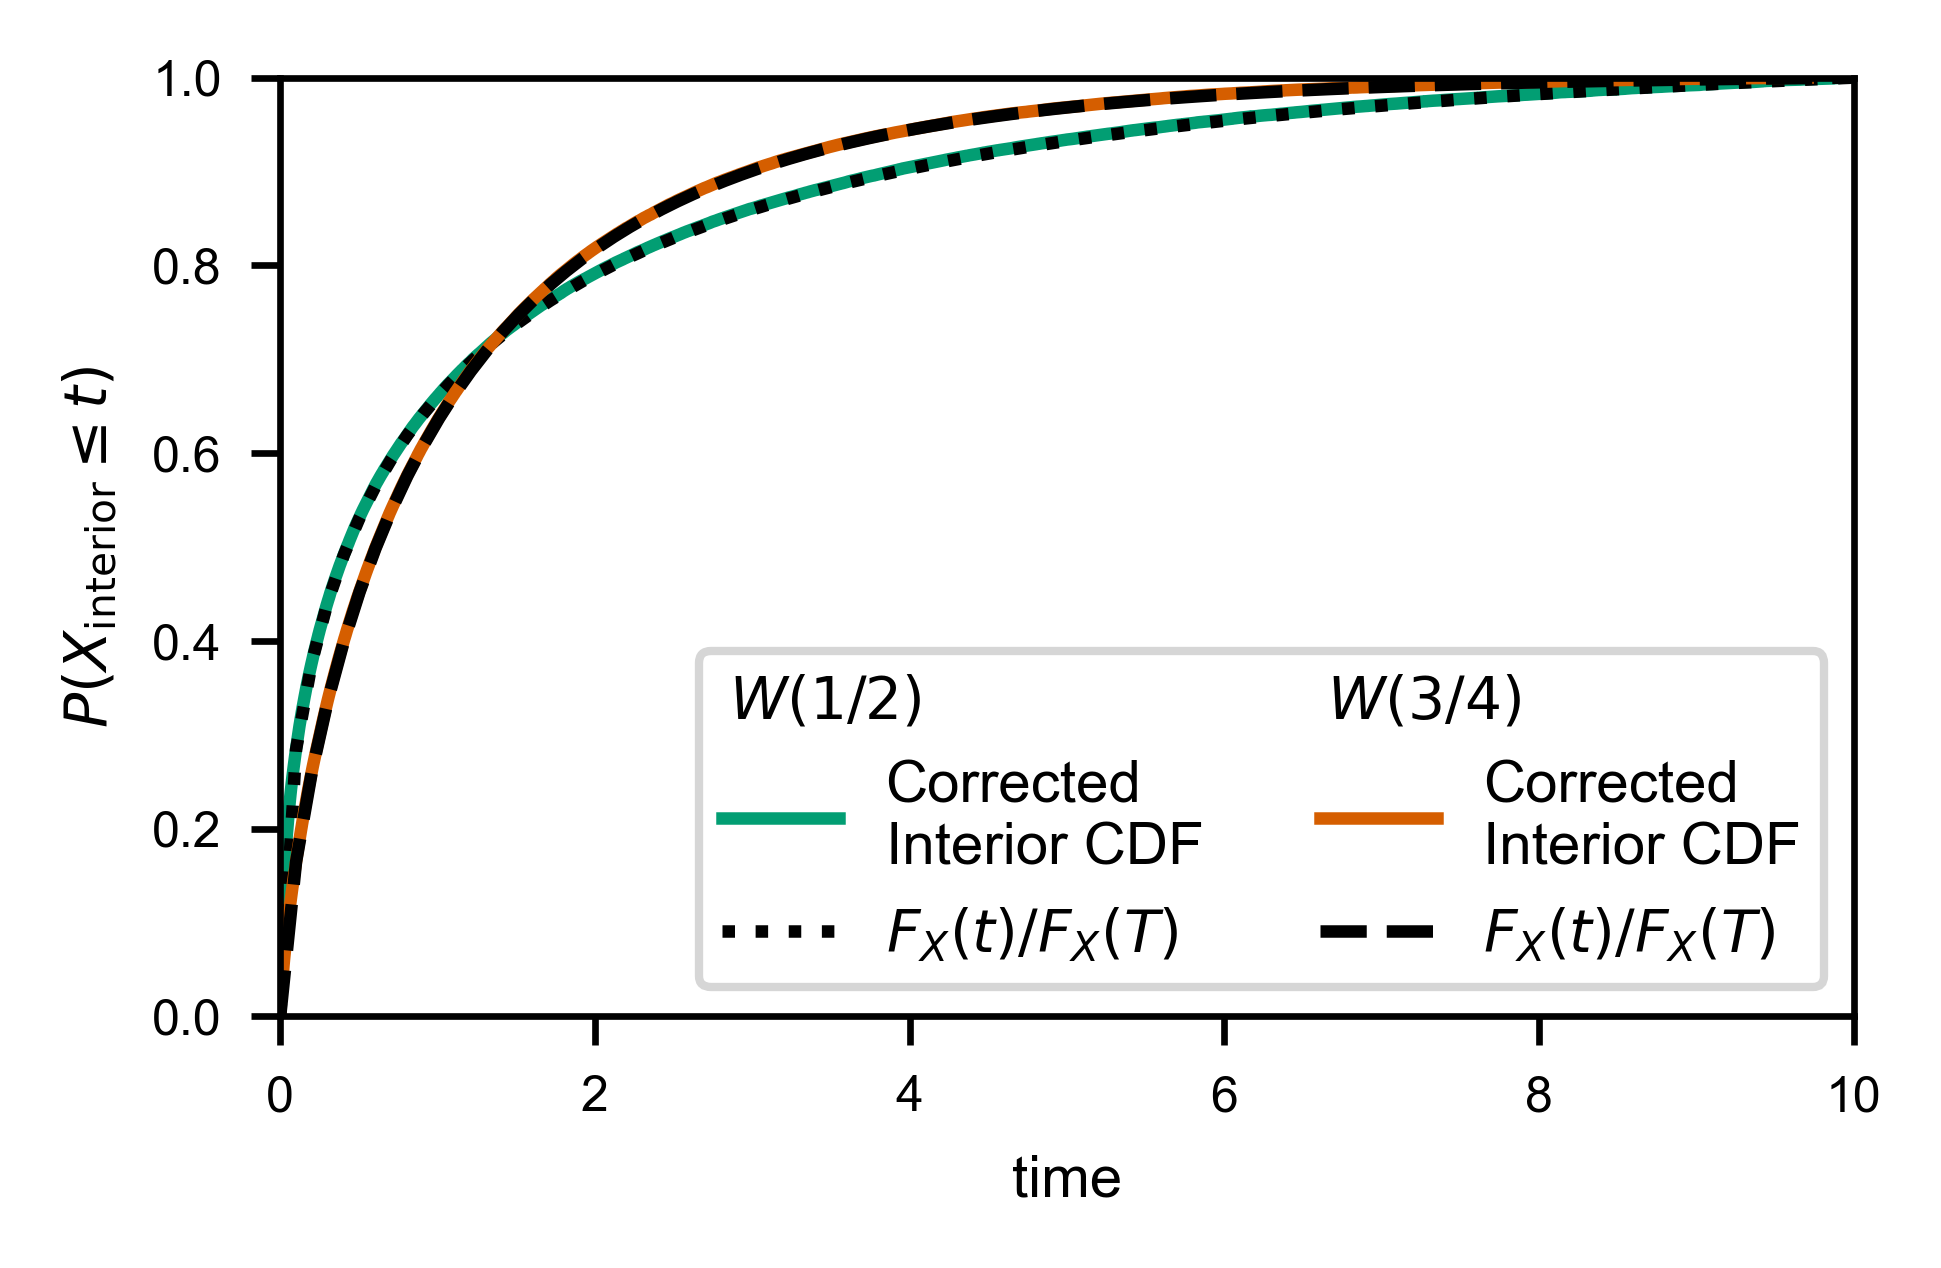

In [324]:
for name, obs in observations.items():
    fig = fplt.corrected_interior_ecdf(obs, variable_pairs[name])
    save(fig, f'interior-ecdf-corrected-{name}.pdf')


## Interior *and* Exterior times to "real" distribution

Here's how well we are able to rescale $Z_X$ and into $\int_0^t F_X(t) dt$ for this particular set of trajectories:

### Correction factor

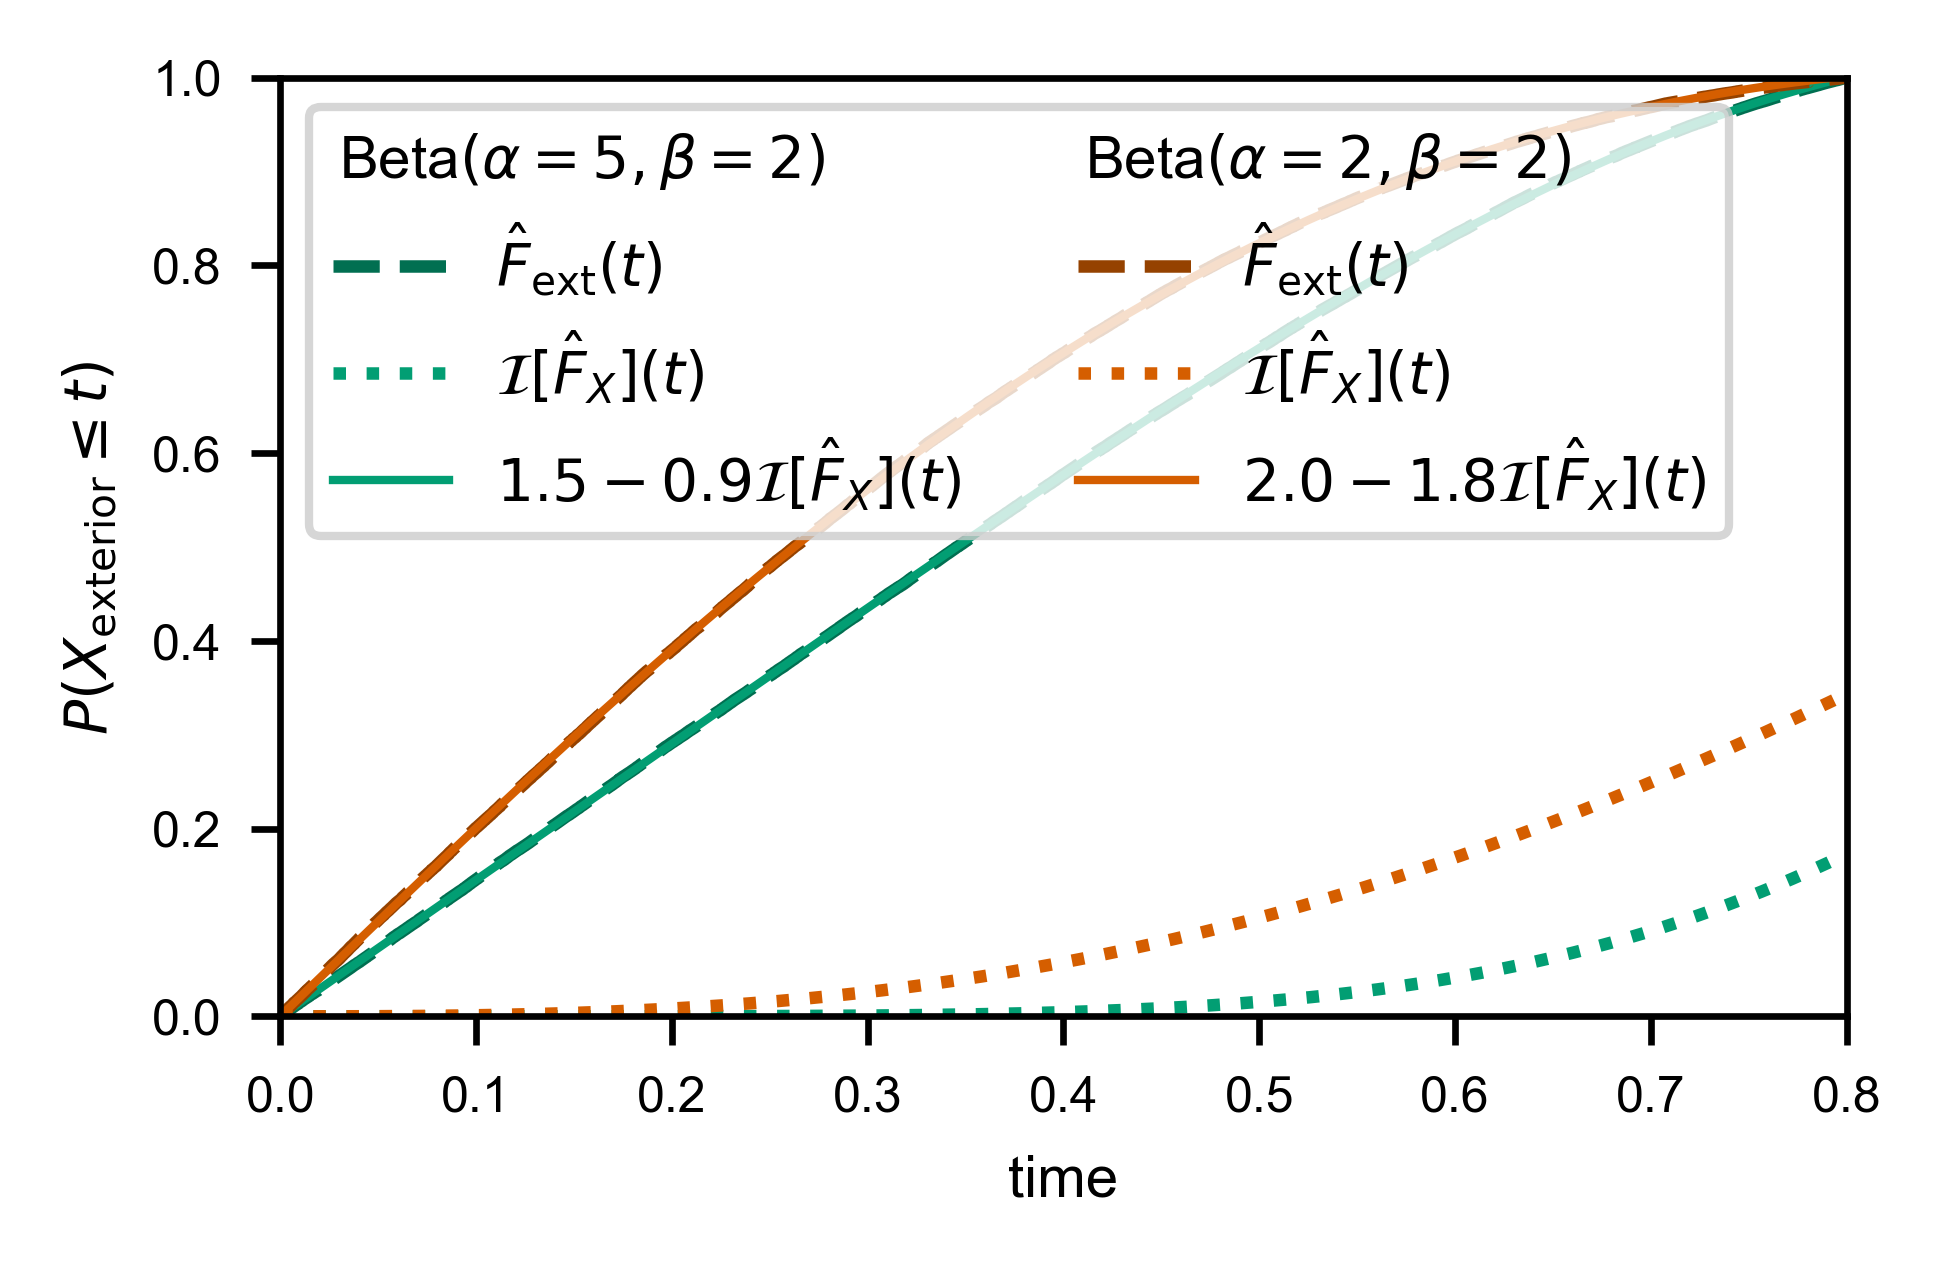

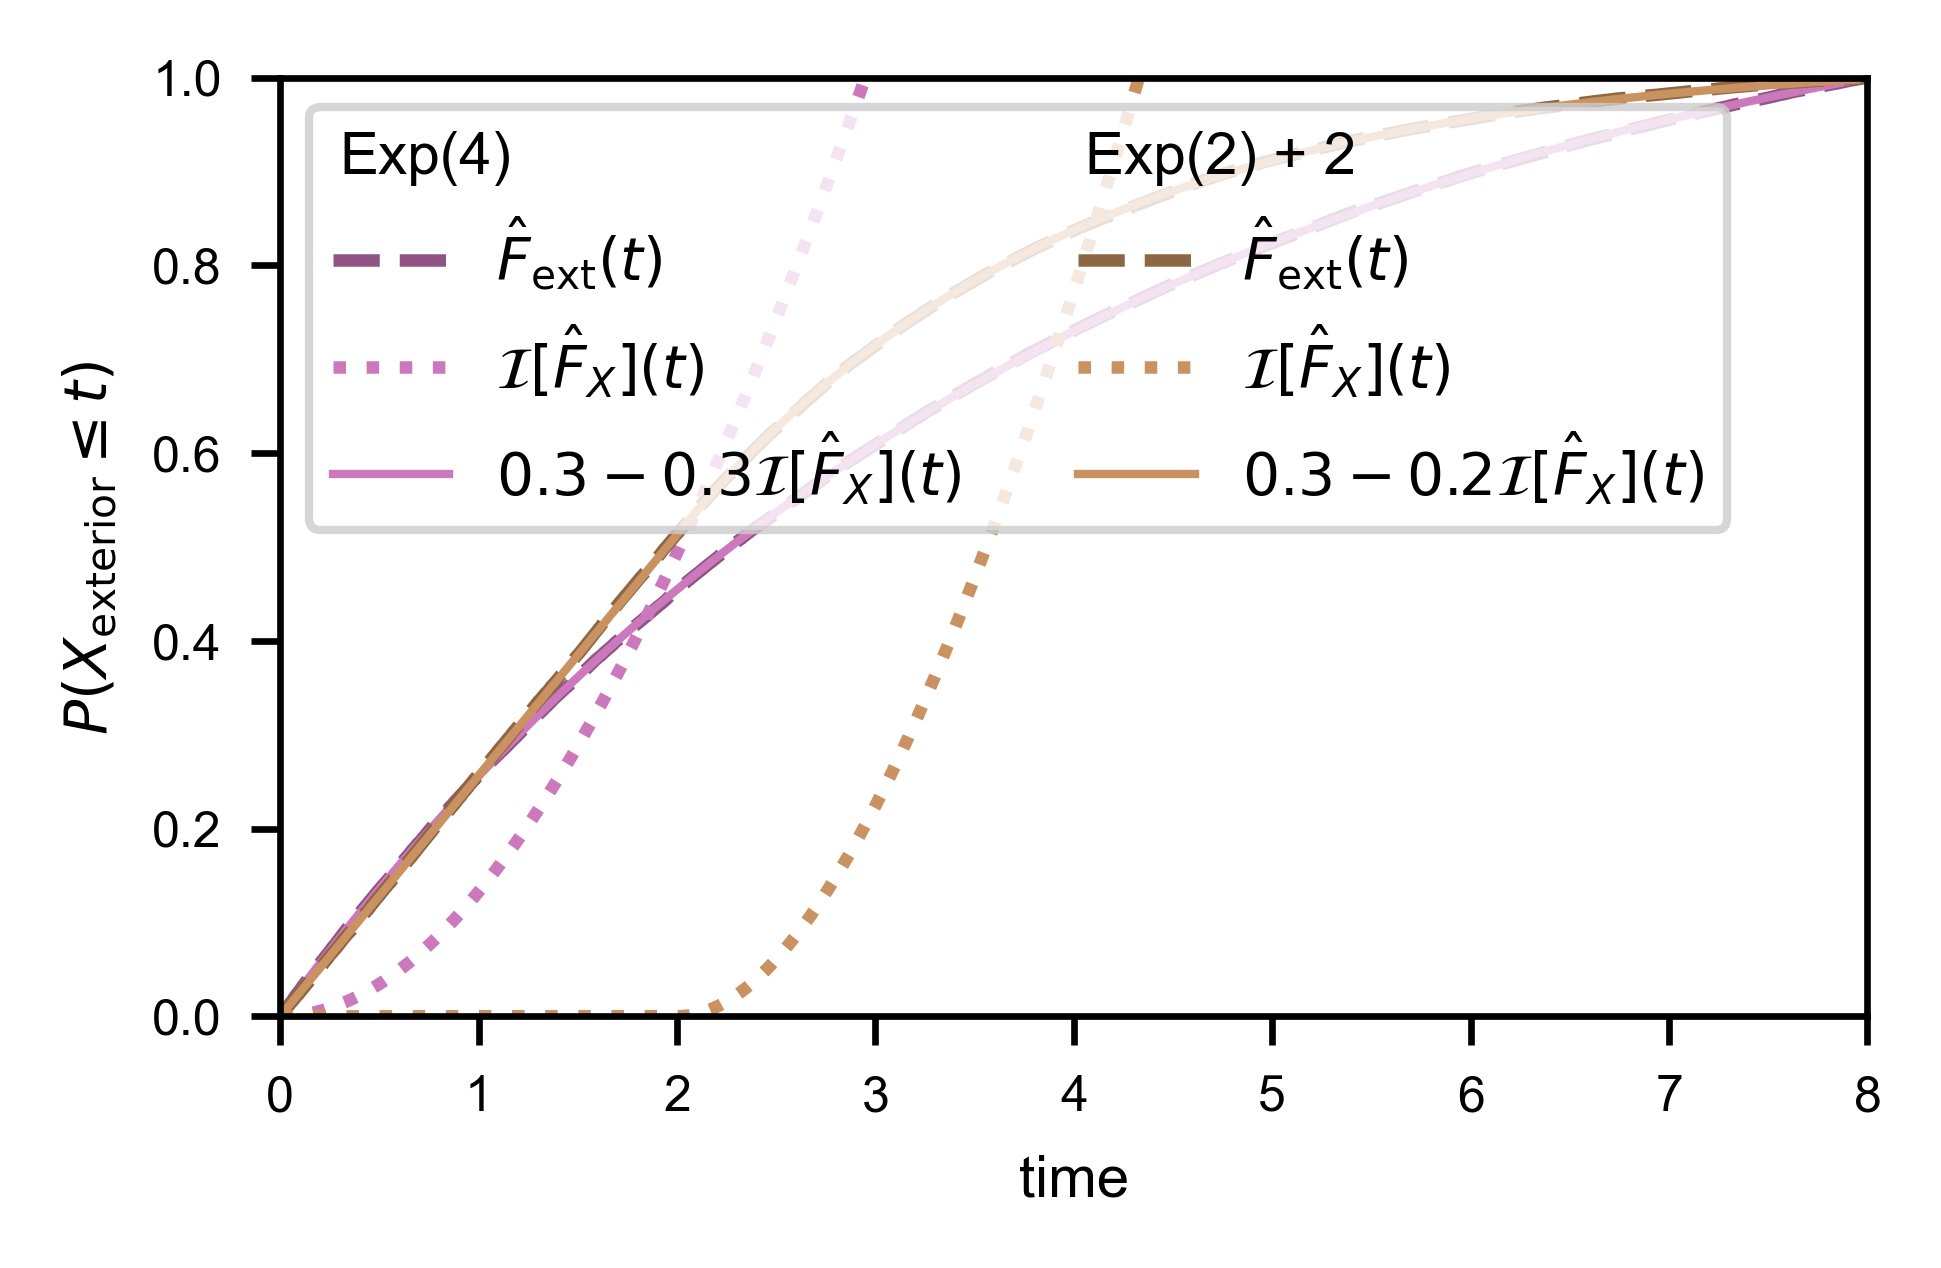

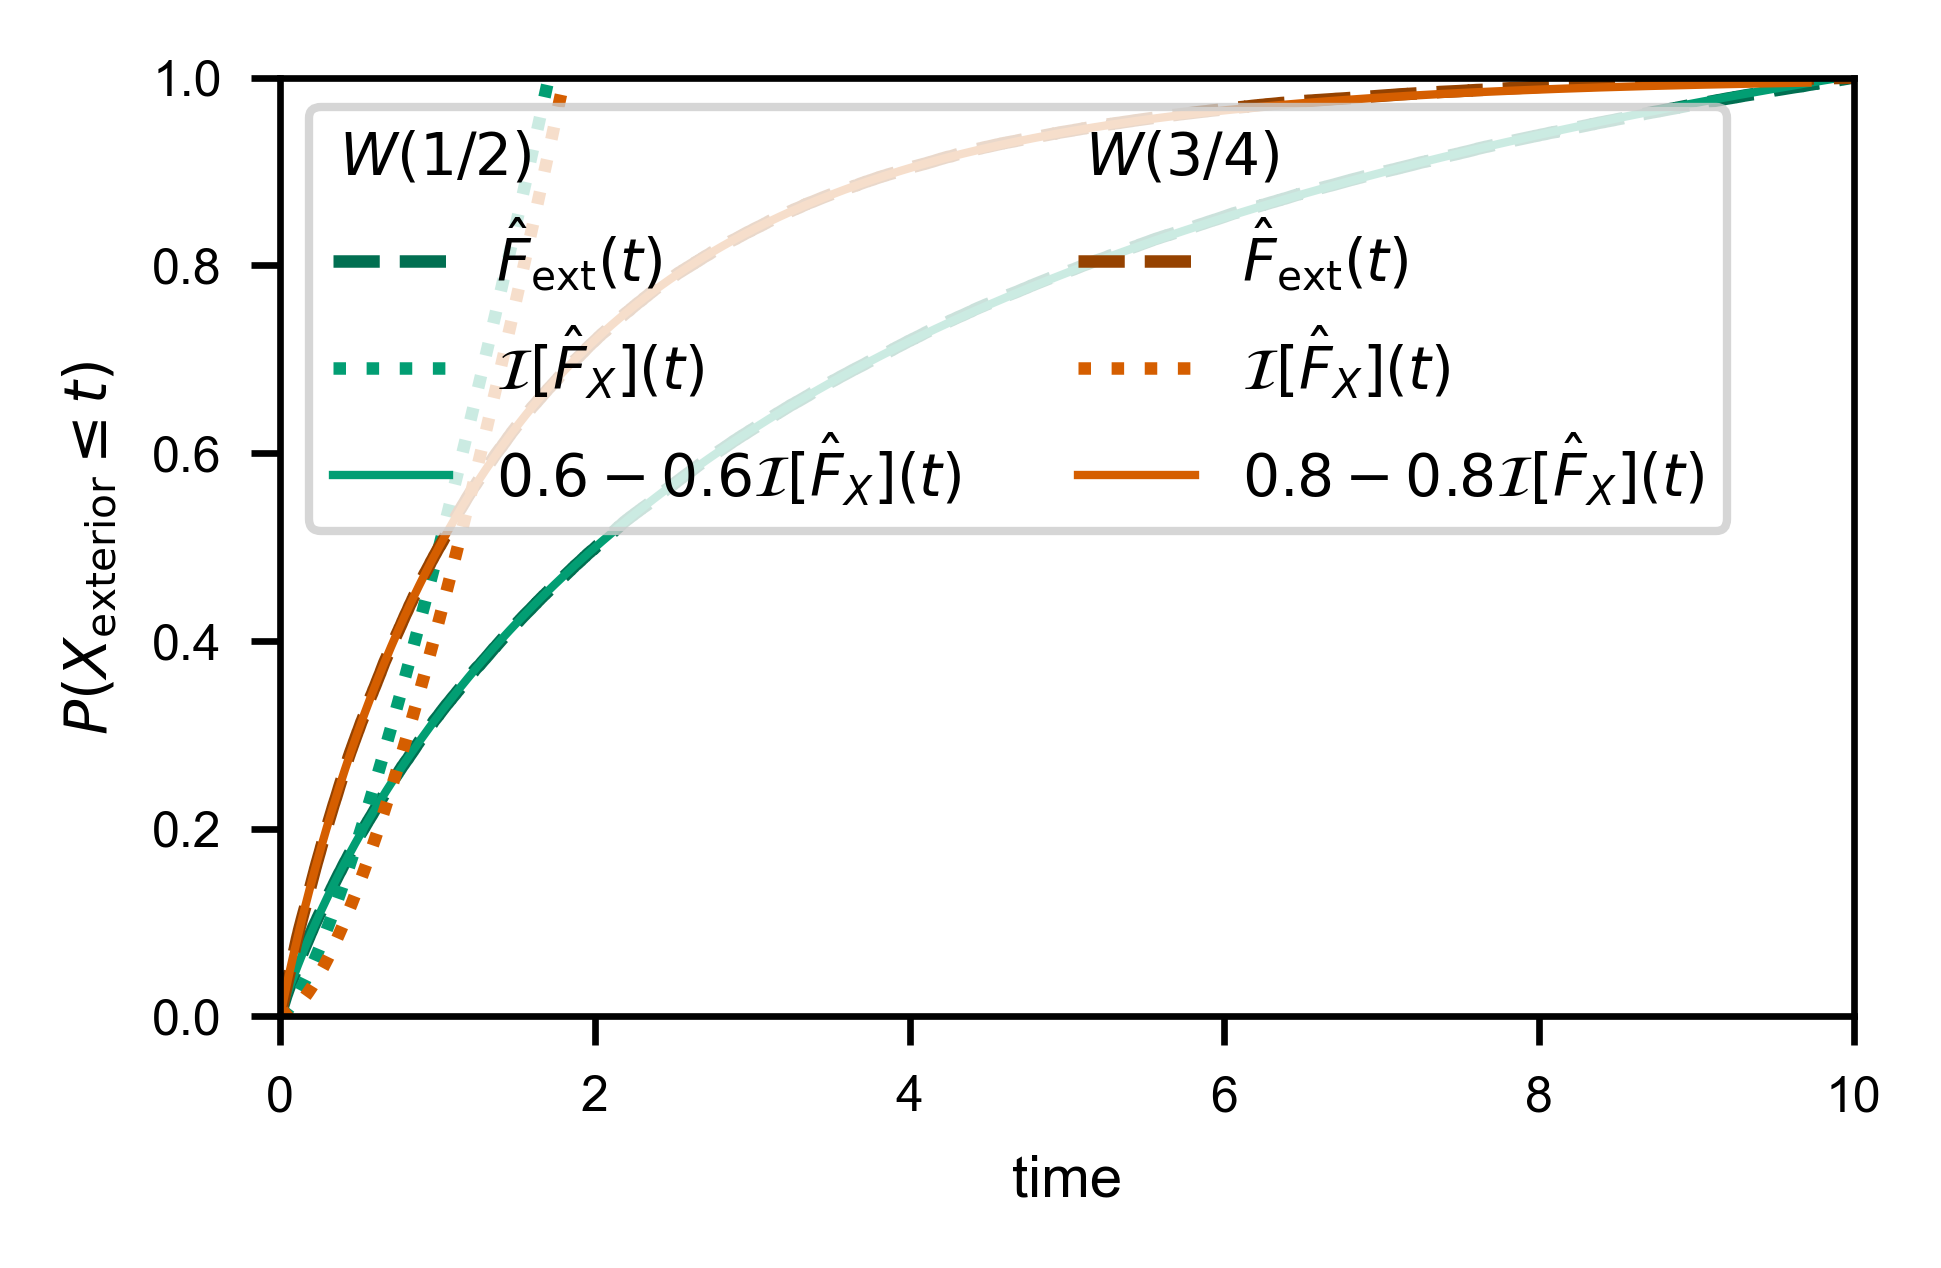

In [346]:
for name, obs in observations.items():
    fig = fplt.scaling_normalizers(obs, variable_pairs[name])
    save(fig, f'correction-factor-{name}.pdf')


### Individually-corrected exterior and interior estimators

Now we can compute correctly normalized wait time distributions:

In [ ]:
for name, obs in observations.items():
    fig = fplt.int_ext_cdf_comparison(obs, variable_pairs[name])
    save(fig, f'interior-exterior-rescaled-comparison-{name}.pdf')

### Error in exterior estimator

Now notice that we can cleanly compute a realistic estimate of the error of our exterior time CDF estimator, since it's just a histogram:

In [ ]:
for name, var_pair in variable_pairs.items():
    fig = fplt.ext_est_std(observations[name], var_pair)
    save(fig, f'exterior-rescaled-confidence-intervals-{name}.pdf')

### Error in interior estimator

We cannot, on the other hand, get good estimates for the error. The Dvoretzky-Kiefer-Wolfowitz lower bound on the error at a fixed $\alpha$ gives us a constant estimate, when in fact the last few time points definitely have larger error (kinda a tick up right at the end, obviously due to stray points being either sampled with MASSIVE 1/(T-t) or no), but nothing that grows like something obvious like 1/(T-t).


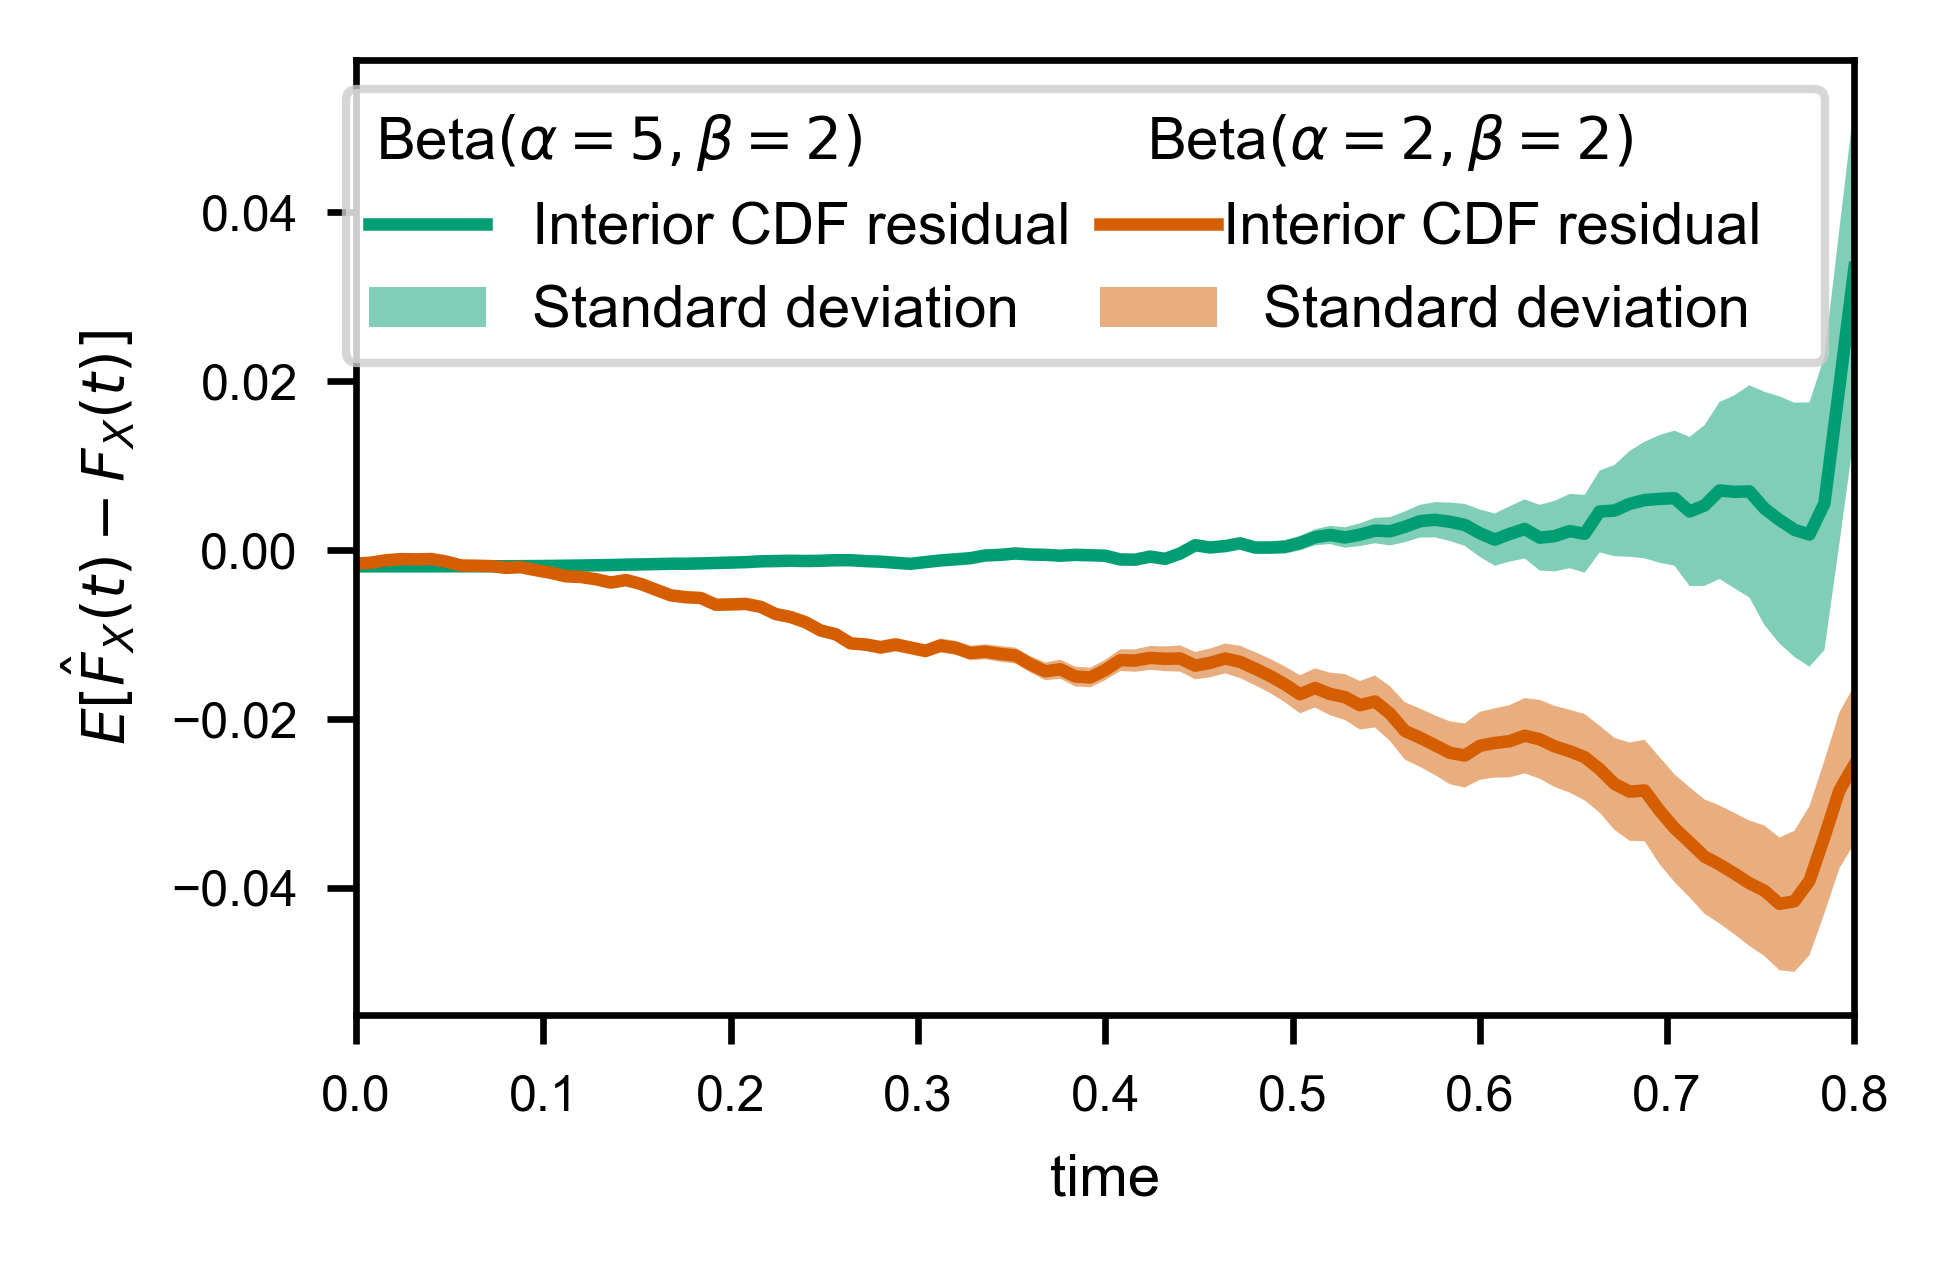

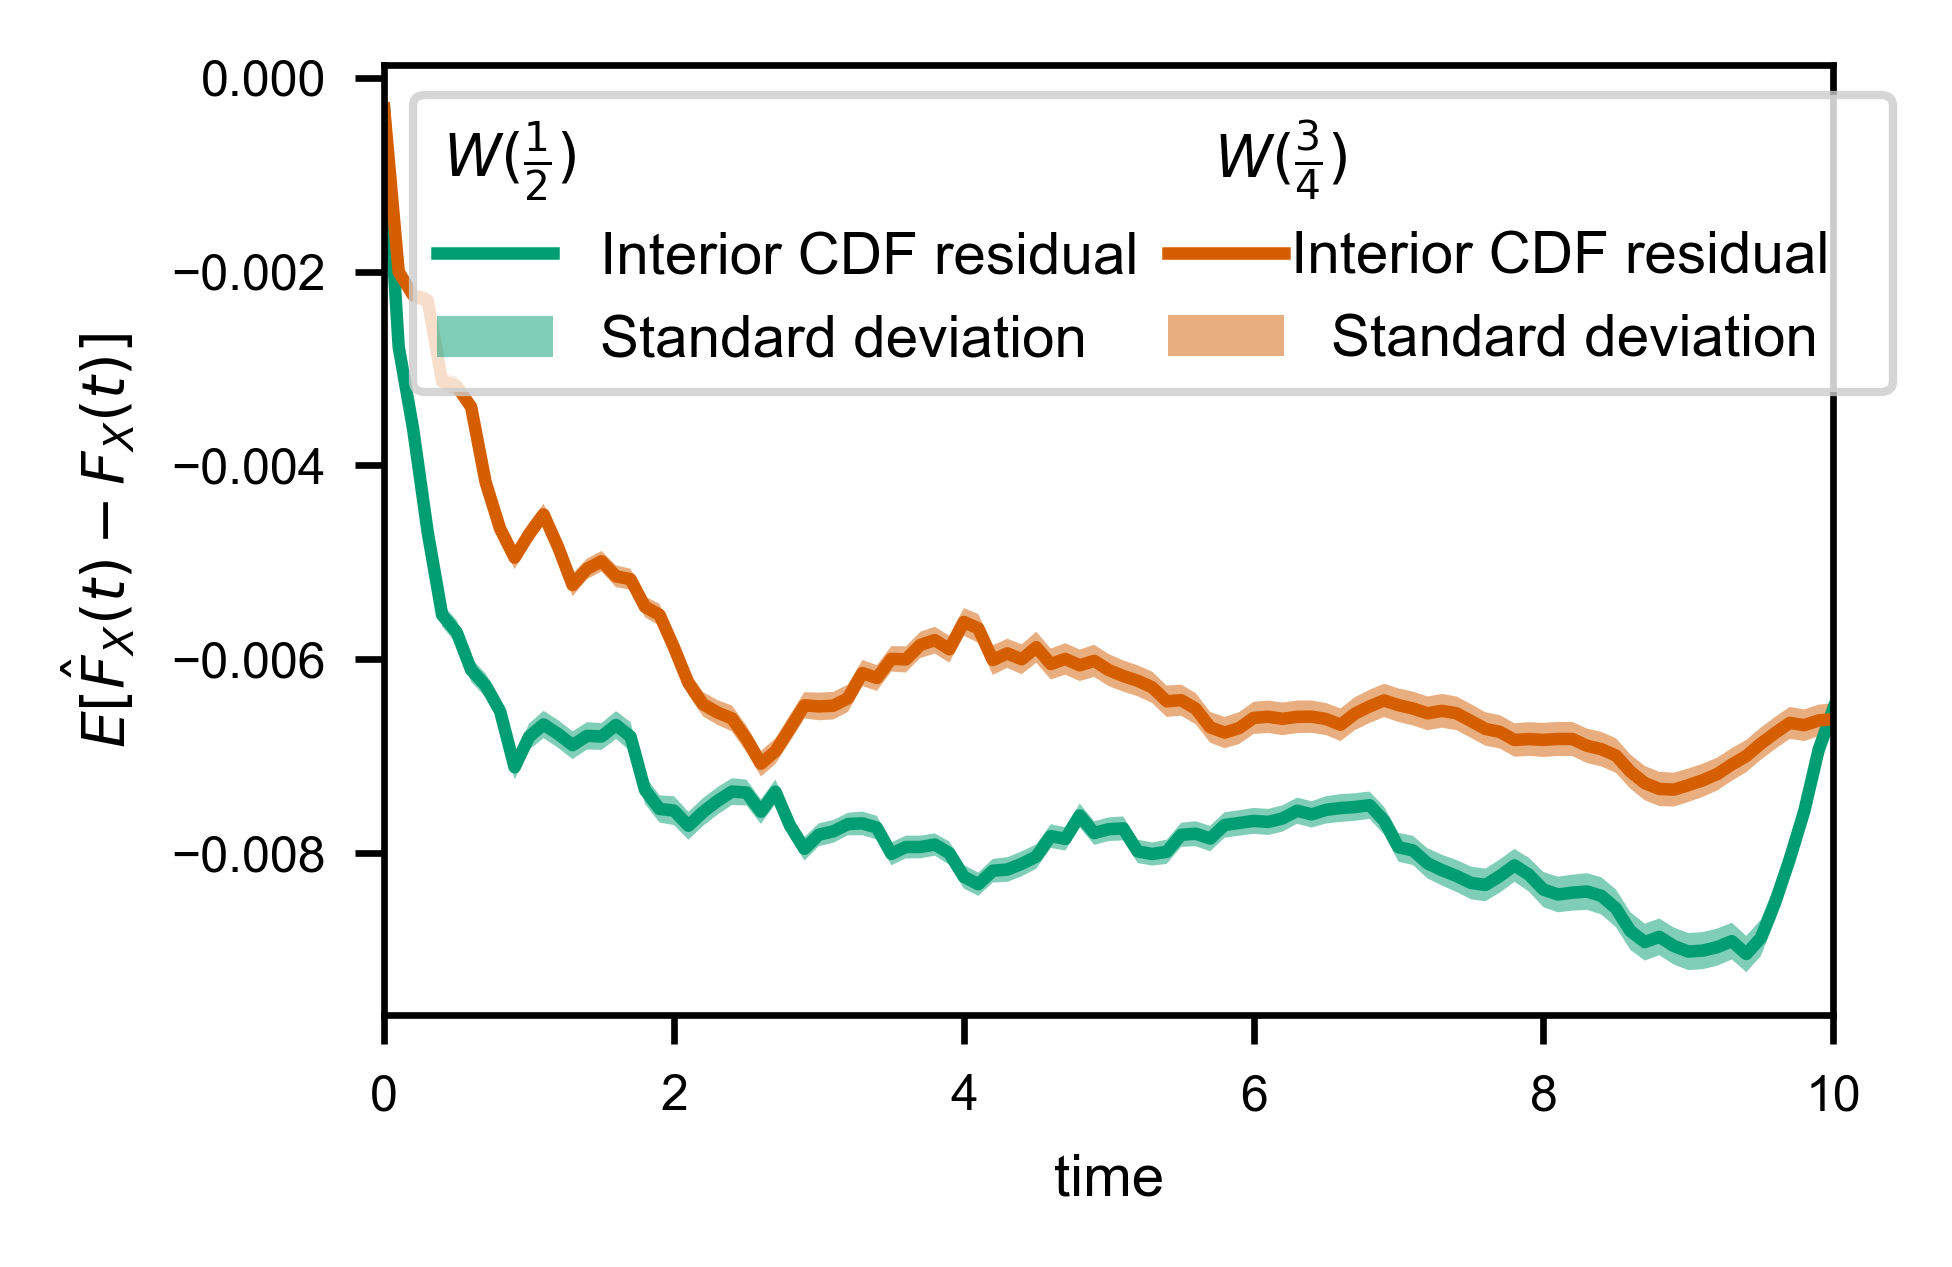

In [337]:
for name, var_pair in variable_pairs.items():
    if 'xp' in name:
        continue
    T = windows[name]
    err_t, err_ave, err_std = fw.bootstrap_int_error(
        var_pair, T,
        N_boot = 100,
        N_traj_per_boot=1000,
        N_err_t=101
    )
    fig, ax = plt.subplots(
        figsize=figure_size['full column'],
        constrained_layout=True
    )
    legend_entries = {
        var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)]
        for var in var_pair
    }
    for var in var_pair:
        line, = ax.plot(err_t, err_ave[var.name], c=var.color, 
                      label='Interior CDF residual')
        legend_entries[var.name].append(line)
        fill = ax.fill_between(
            err_t, 
            err_ave[var.name] - err_std[var.name],
            err_ave[var.name] + err_std[var.name],
            facecolor=var.color,
            edgecolor=None,
            alpha=0.5,
            label=r'Standard deviation'
        )
        legend_entries[var.name].append(fill)
    ax.set_xlabel('time')
    ax.set_ylabel(r'$E[\hat{F}_X(t) - F_X(t)]$')
    ax.set_xlim([0, T])
    # ax.set_ylim([0, 1])
    handles = [h for _, patches in legend_entries.items() for h in patches]
    legend = ax.legend(handles=handles, ncol=2, columnspacing=0.5,
                    handler_map={StairLine: StairLineHandler()})

    # hack to left-align my "fake" legend column "titles"
    for vpack in legend._legend_handle_box.get_children():
        for hpack in vpack.get_children()[:1]:
            hpack.get_children()[0].set_width(0)
    # even after the hack, need to move them over to "look" nice
    legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
    legend.get_texts()[3].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))


### Combined estimator

Because of this, we stick to DFW estimate for now.

#### CDF

In [ ]:
for name, var_pair in variable_pairs.items():
    fig = fplt.final_cdf_comparison(observations[name], var_pair)
    save(fig, f'combined-estimator-ecdf-{name}.pdf')

#### PDF

In [ ]:
importlib.reload(fplt)

In [ ]:
for name, var_pair in variable_pairs.items():
    fig = fplt.final_pdf_comparison(observations[name], var_pair)
    save(fig, f'combined-estimator-pdf-{name}.pdf')

### Heterogeneous Window Size

For arbitrary collections of data measured with potentially different window sizes, we simply need to correct for the fraction of trajectories in which each time could have been observed at all.

In [ ]:
for name, var_pair in var_pairs.items():
    fig1, fig2 = fplt.multi_window_demo(var_pair, windows[name])
    save(fig1, f'multi-window-incorrect-{name}.pdf')
    save(fig2, f'multi-window-correct-{name}.pdf')


## Discrete Movies


The case of discrete movies can be handled with little fuss.

### Generating Discrete Trajectories (Movies)

`multi_locus_analysis.finite_window` includes a convenience method for
generating "movie frames" from the output of the `AB_window*` functions:

In [10]:
%%time
movie_frames = {}
frames_dfs = {}
discrete_observations = {}
for name, sim in simulations.items():
    T = sim.window_end.max()
    movie_frames[name] = np.linspace(0, T, 21)
    frames_dfs[name] = fw.simulation_to_frame_times(
        sim, movie_frames[name]
    )
    discrete_observations[name] = \
        fw.sim_to_obs(frames_dfs[name].reset_index())

CPU times: user 1.22 s, sys: 29.9 ms, total: 1.25 s
Wall time: 1.25 s


### Discrete interior estimator (PDF)

Looks like it could use some work. Probably off by bin size gain. Alas... 

(0.001, 10.0)

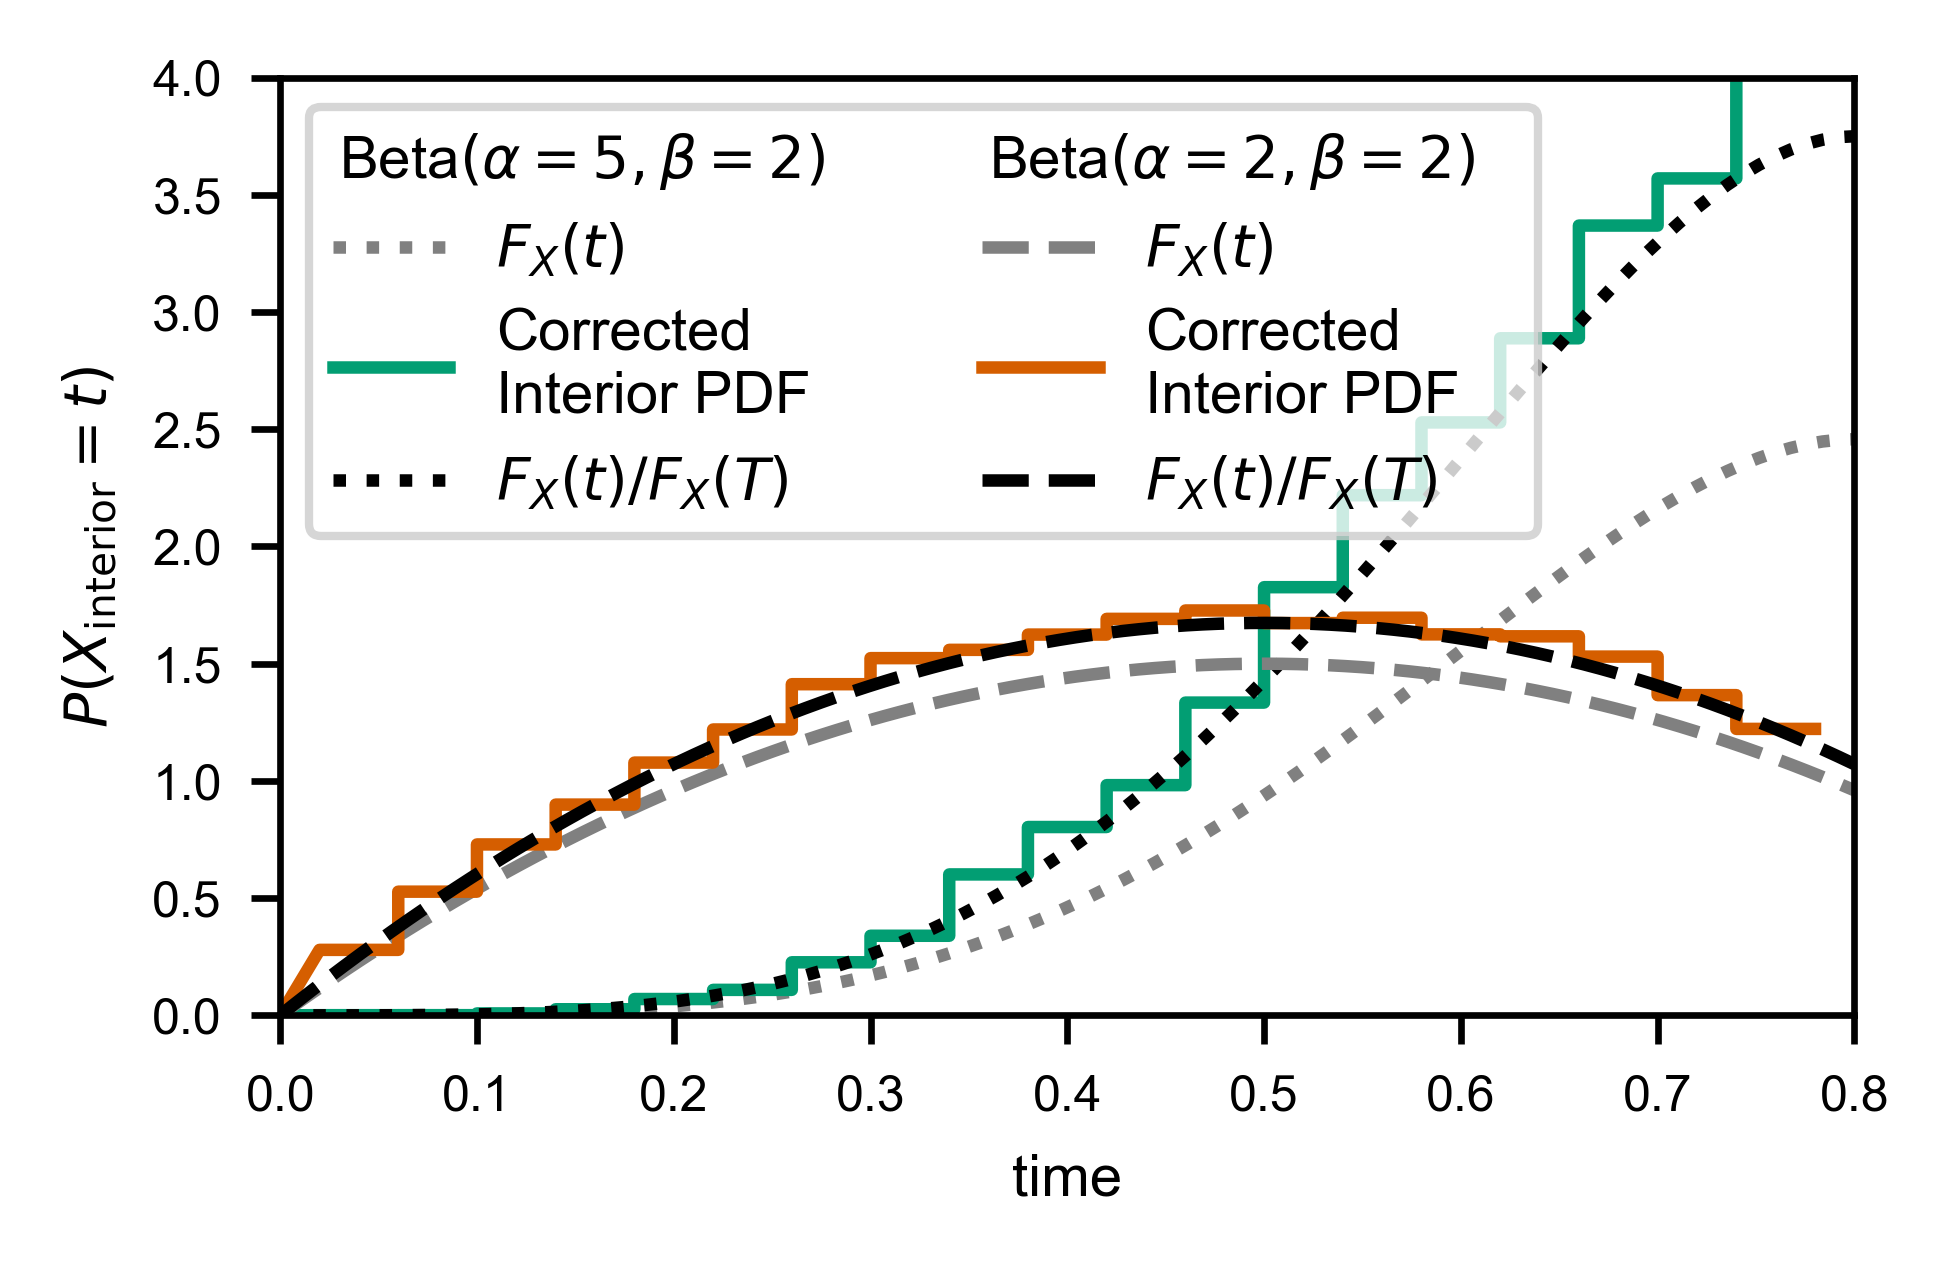

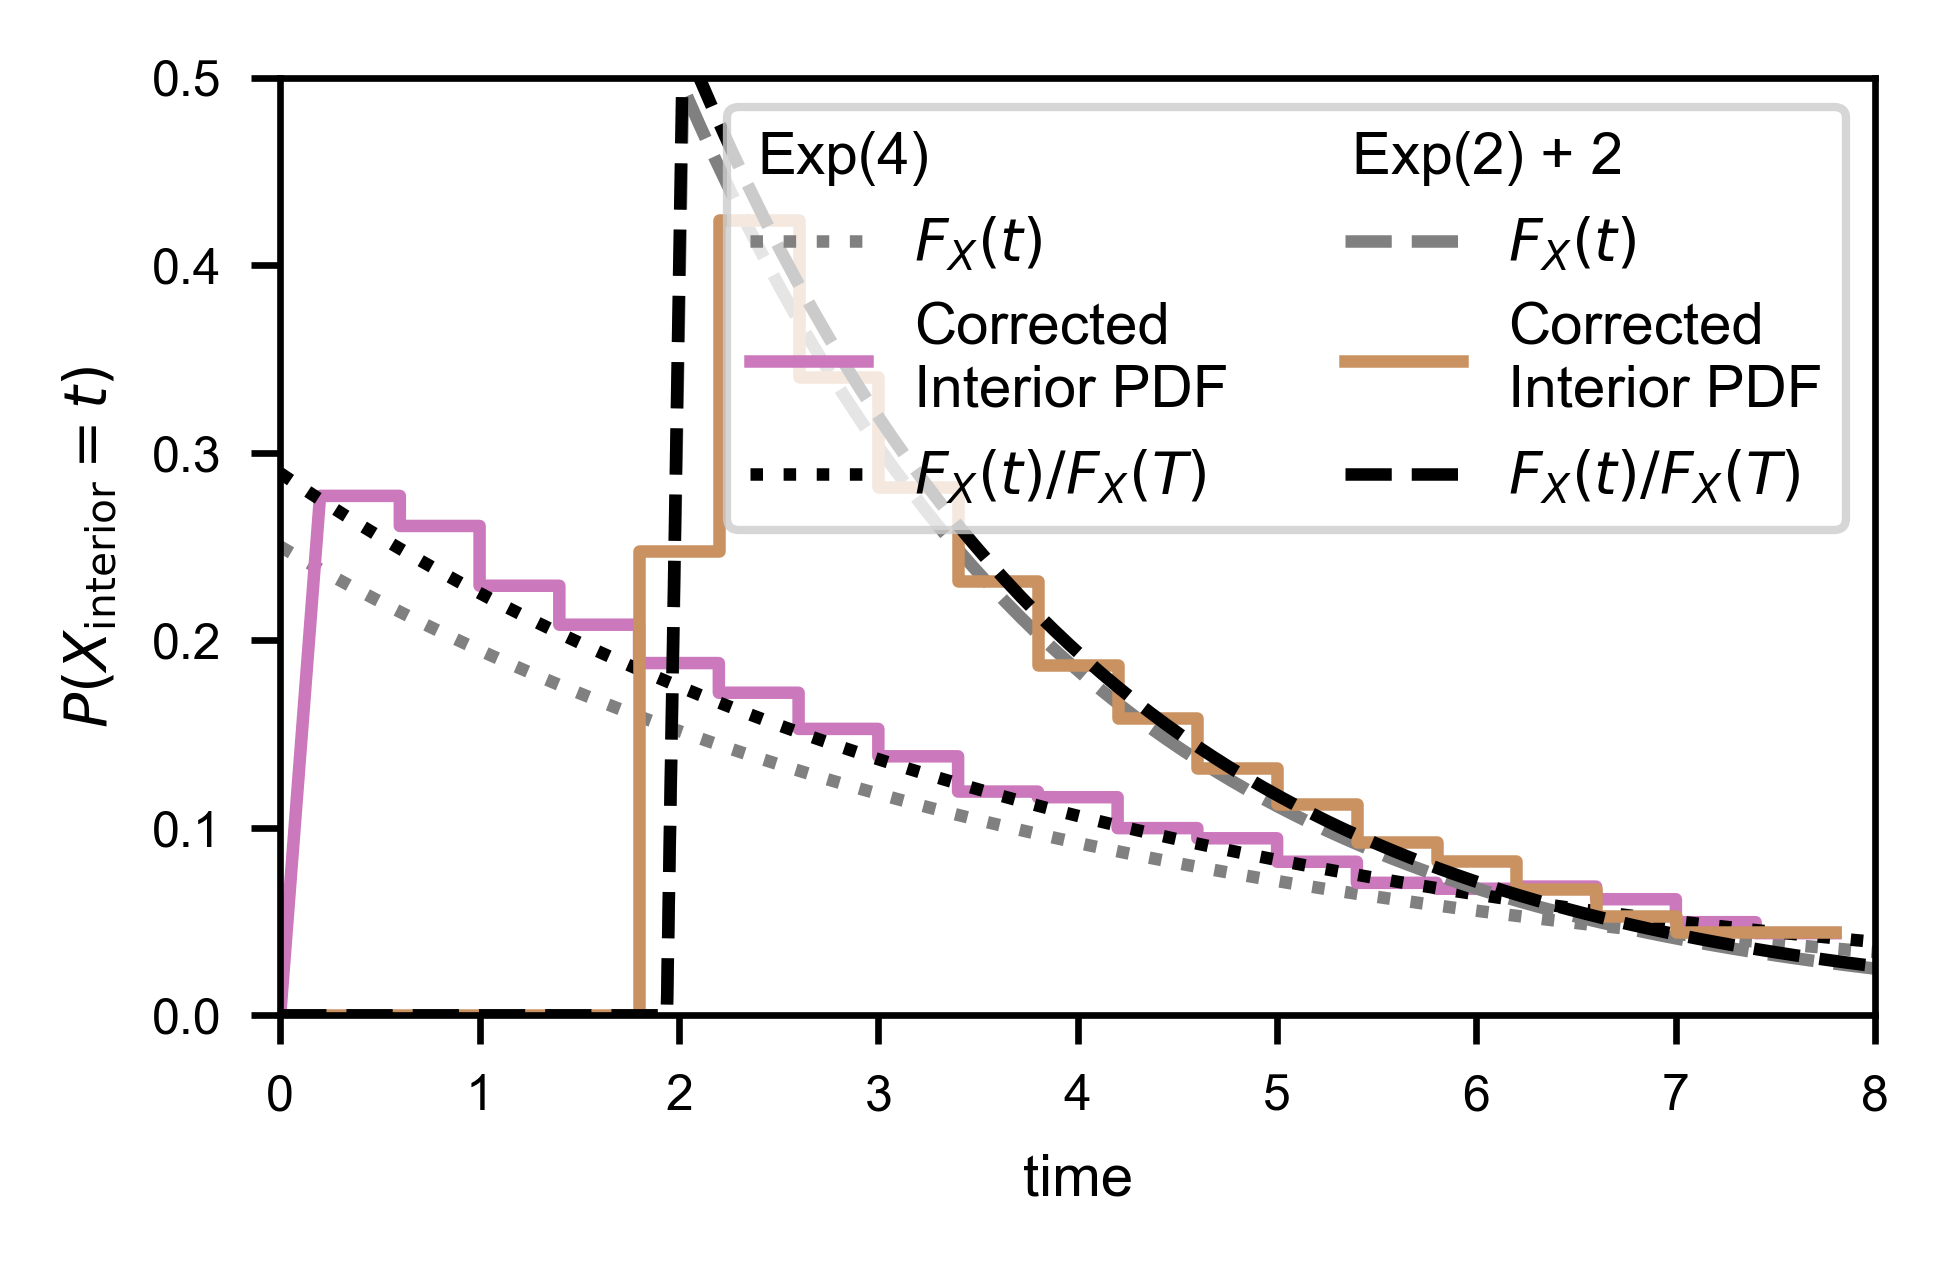

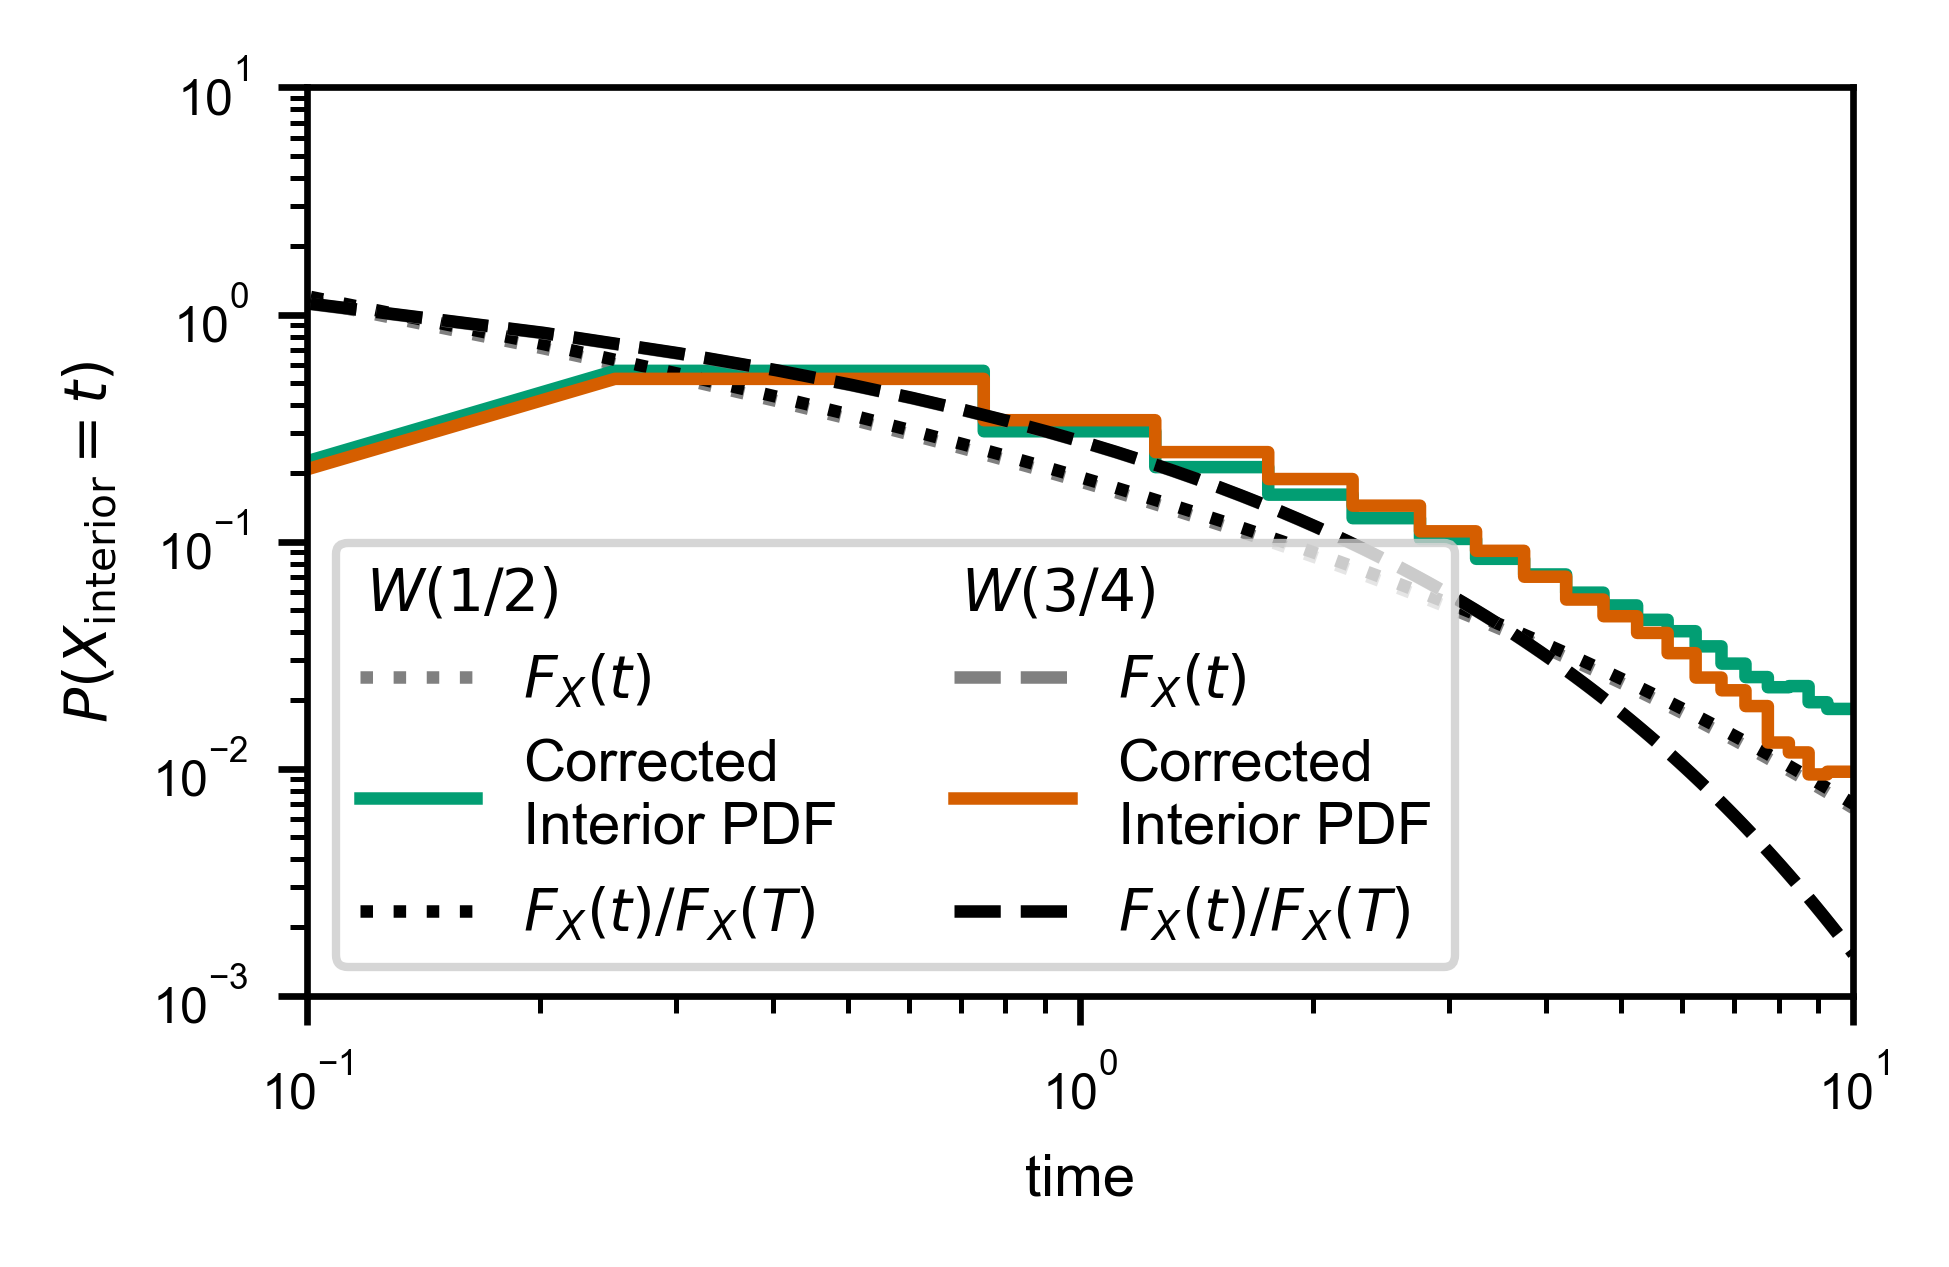

In [69]:
for name, obs in discrete_observations.items():
    fplt.discrete_bars_from_cdf(obs, variable_pairs[name], movie_frames[name])
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-1, 1e1])
plt.ylim([1e-3, 1e1])

### Discrete exterior histogram

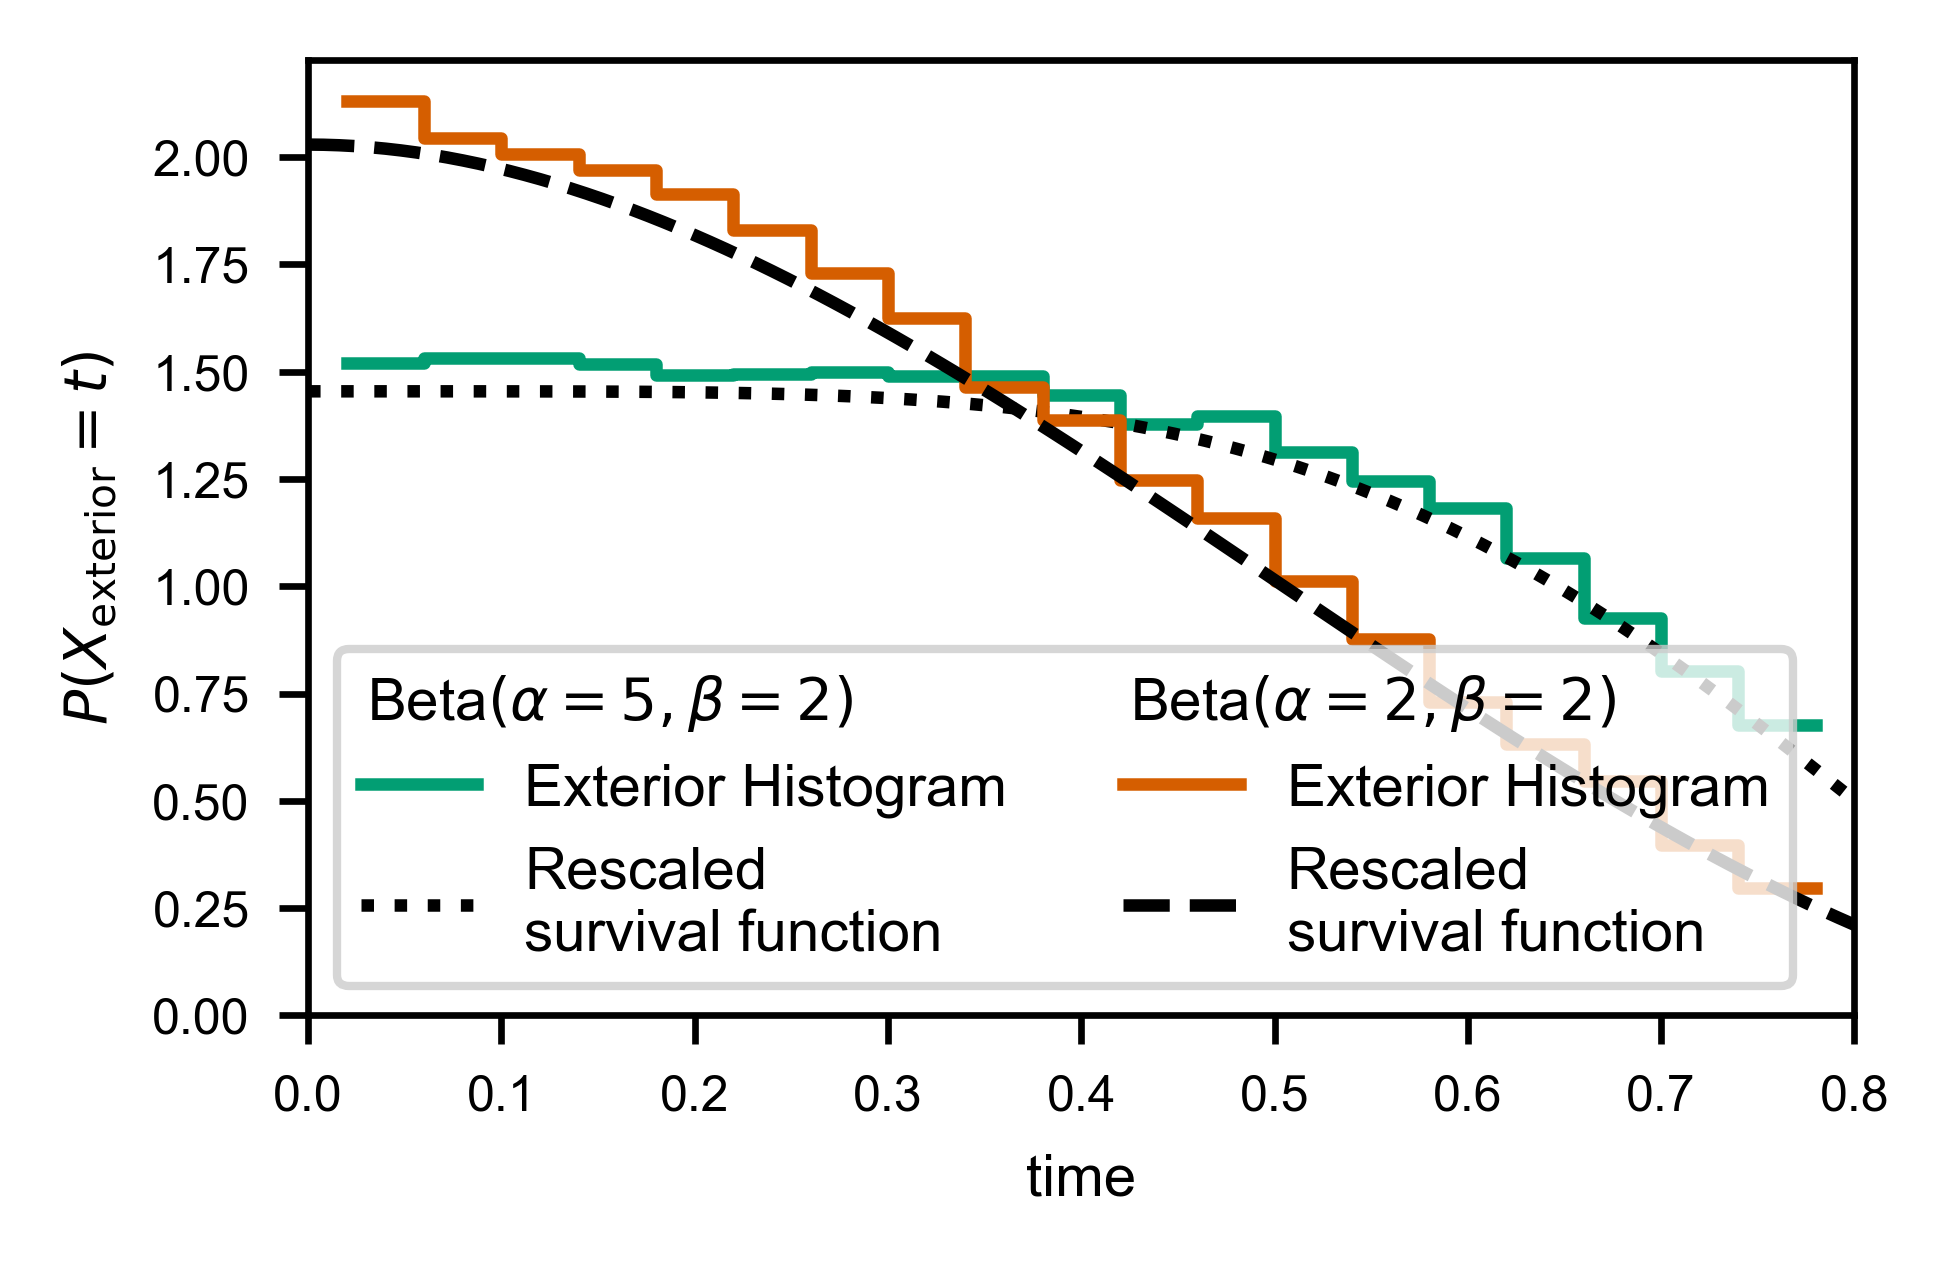

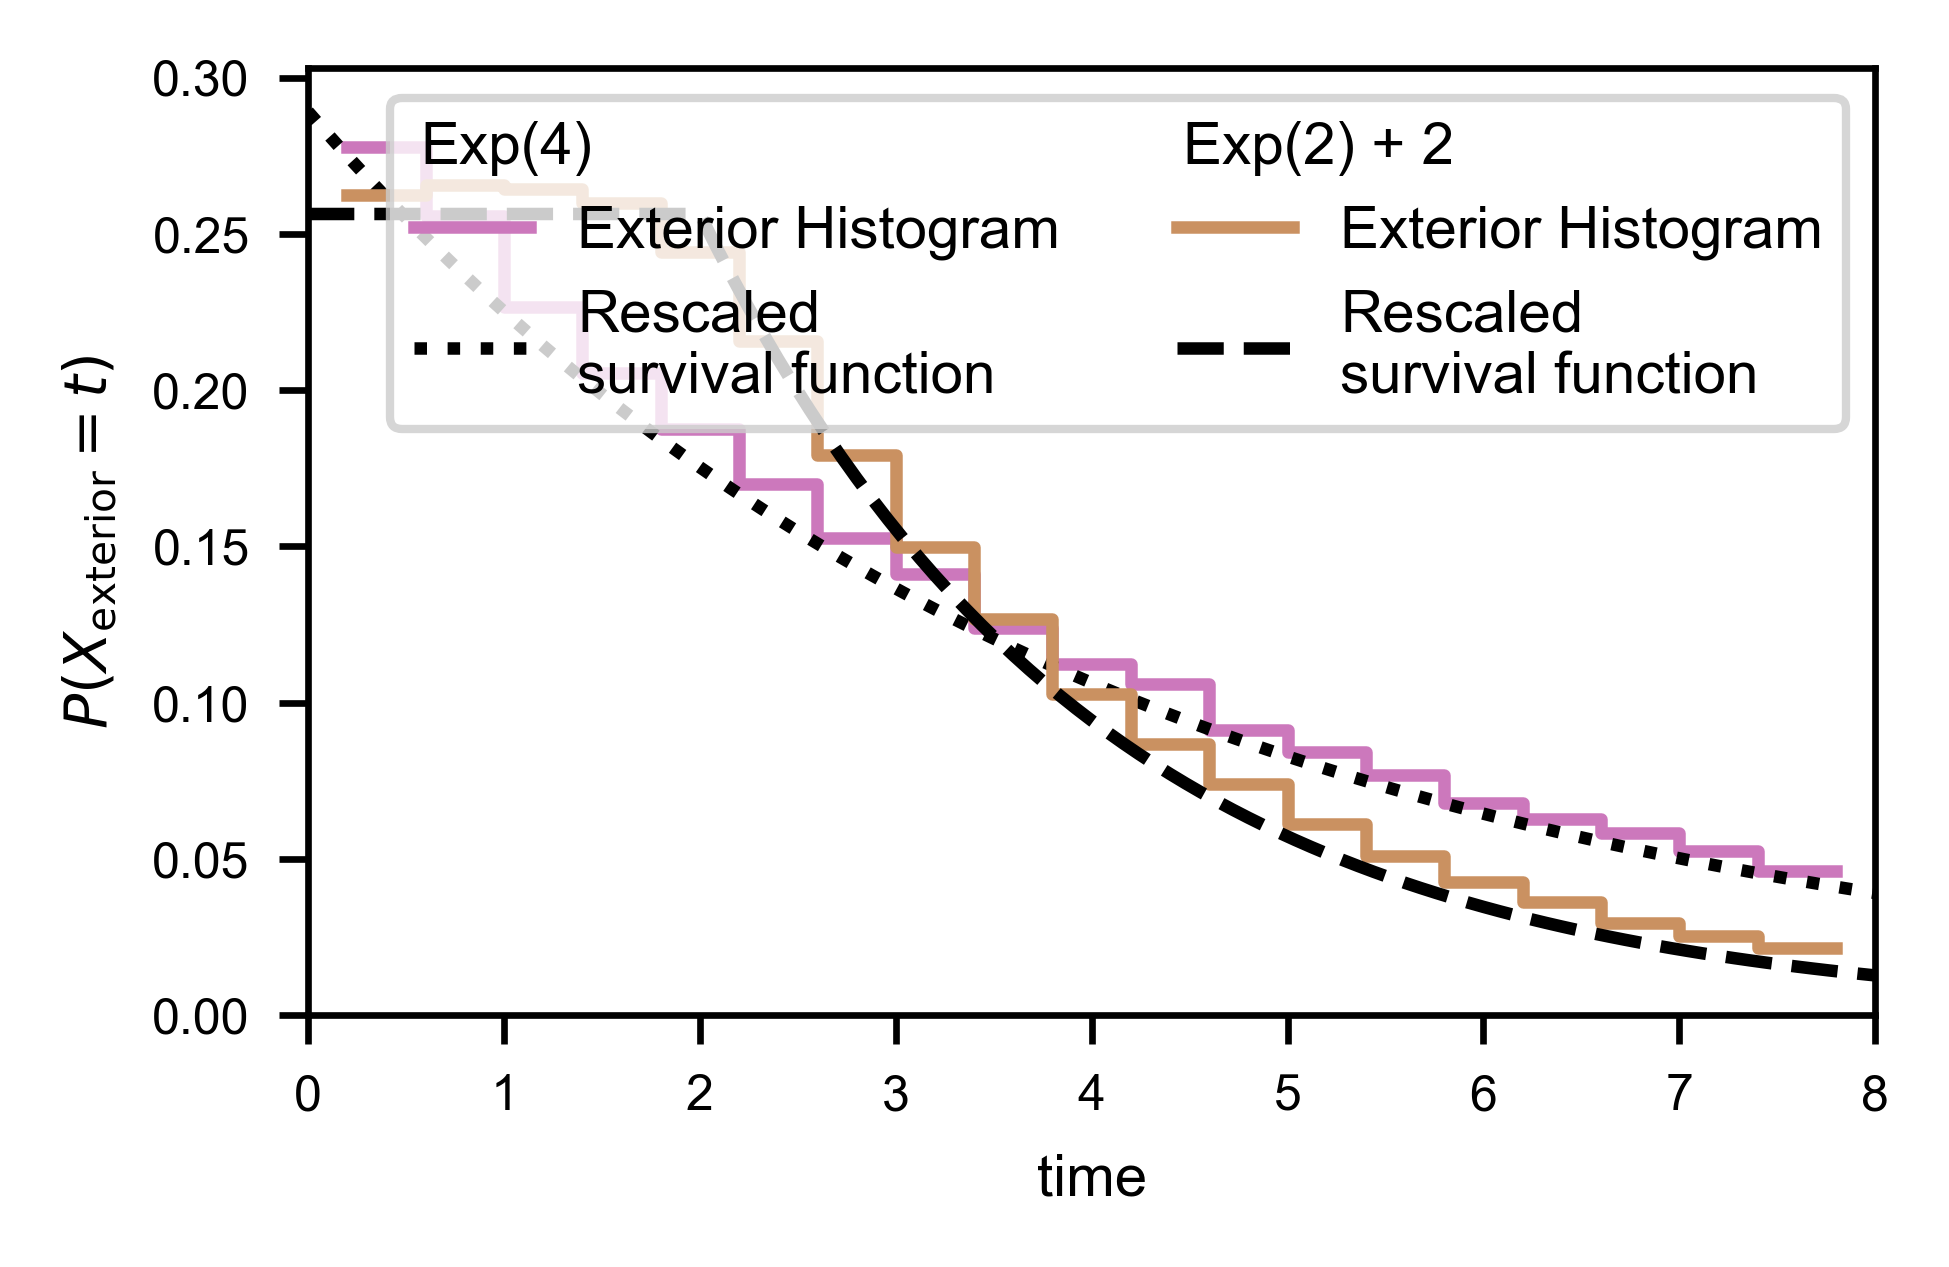

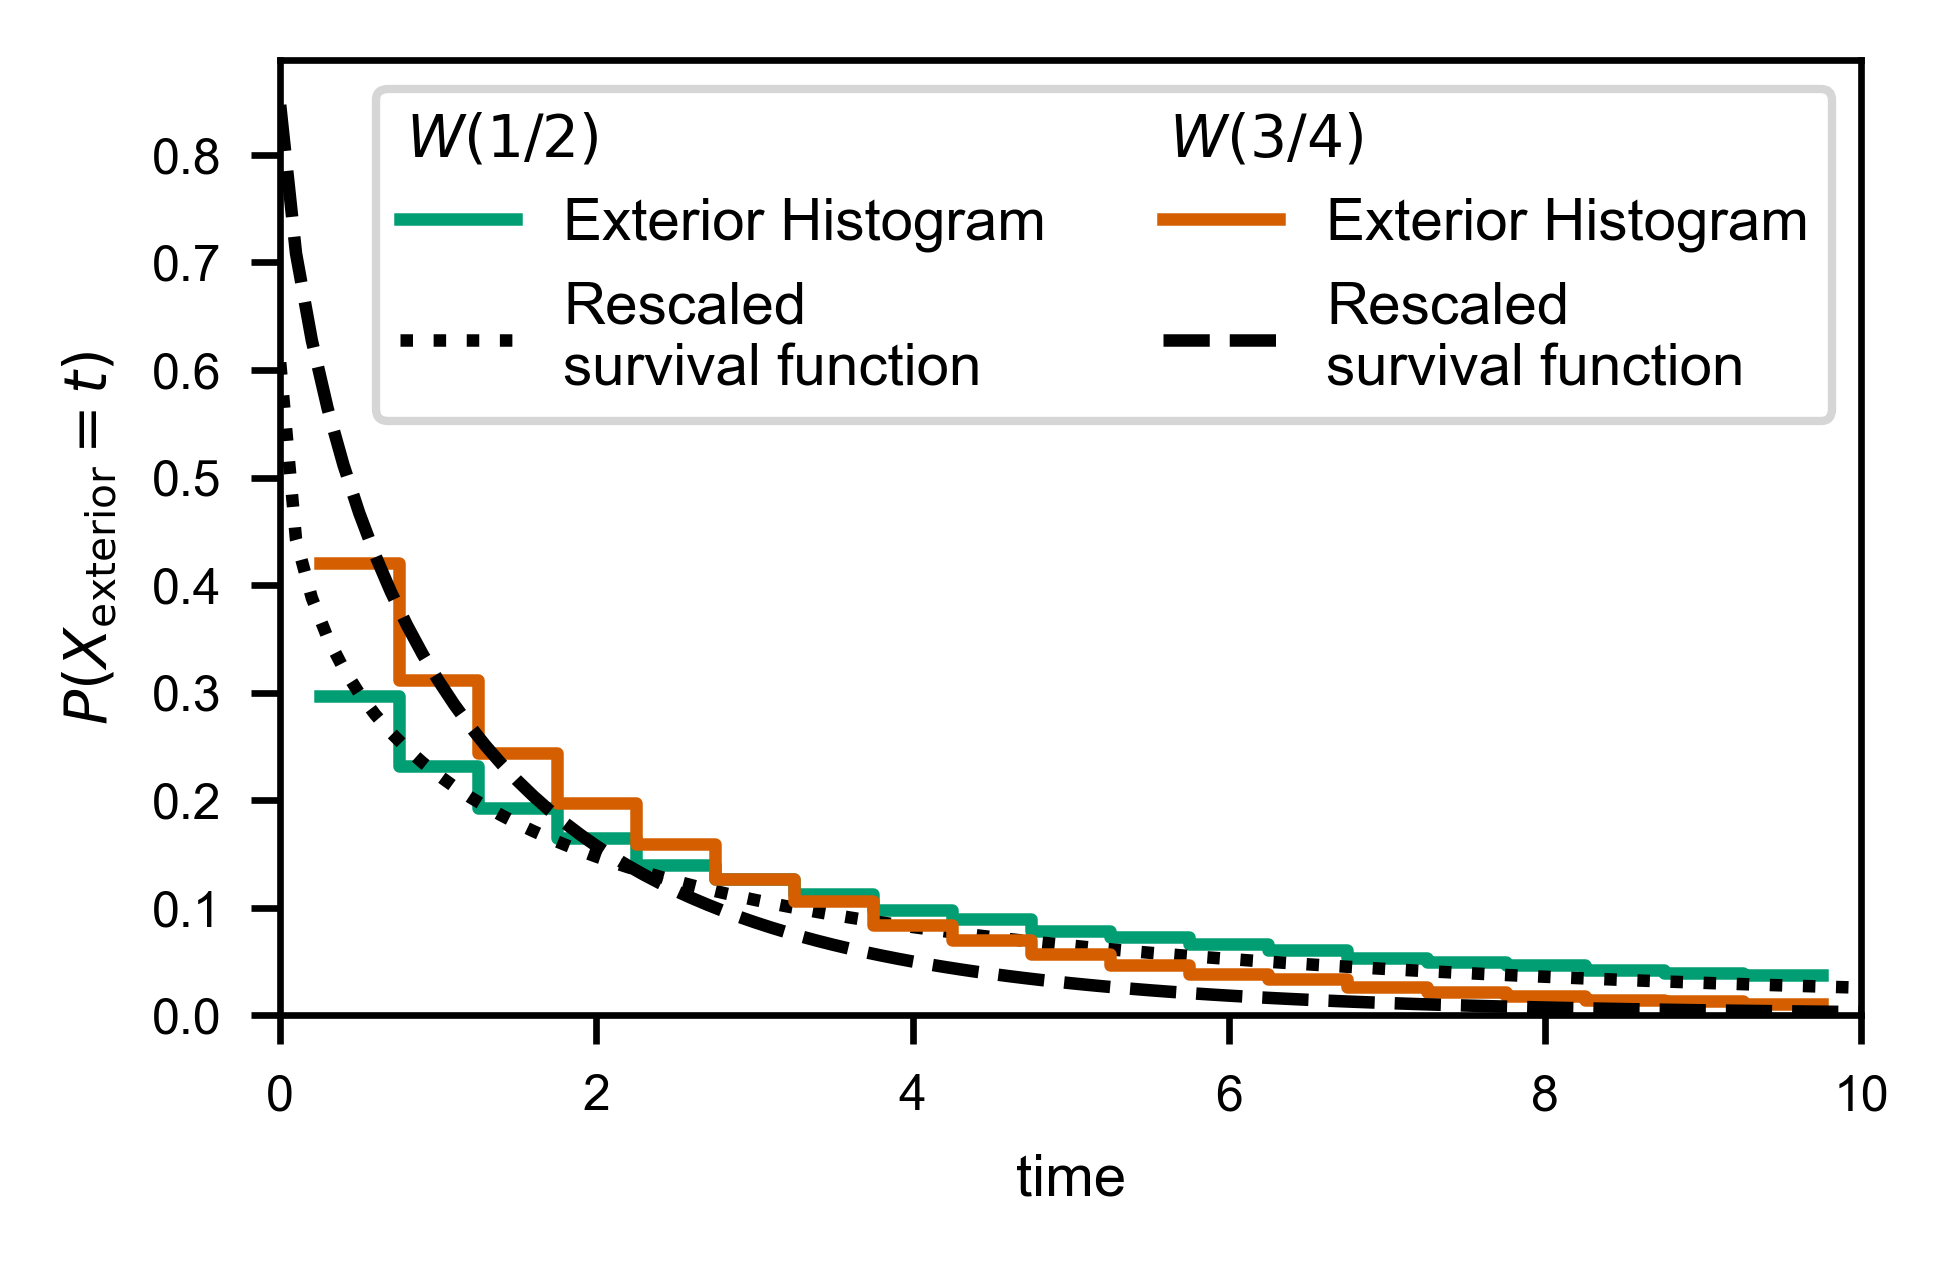

In [72]:
for name, obs in discrete_observations.items():
    fplt.discrete_exterior_est(obs, variable_pairs[name], movie_frames[name])

## Error analysis

### Average bootstrapped residual

In [189]:
import pickle
with open('/home/bbeltr1/Documents/work/ajspakow/finite-window/simulations/consistency-run-100boots-(3, 5, 11)traj-beta-20210301-162303.pkl', 'rb') as f:
    err_aves, err_stds, l2_aves, l2_stds = pickle.load(f)

N_traj_p = 3, 5, 11  # see file name
N_traj = np.logspace(*N_traj_p)
T = windows['beta']
err_t = np.linspace(0, T, 101)

In [194]:
N_traj

array([  1000.        ,   1584.89319246,   2511.88643151,   3981.07170553,
         6309.5734448 ,  10000.        ,  15848.93192461,  25118.8643151 ,
        39810.71705535,  63095.73444802, 100000.        ])

Text(0.5, 0, 'time')

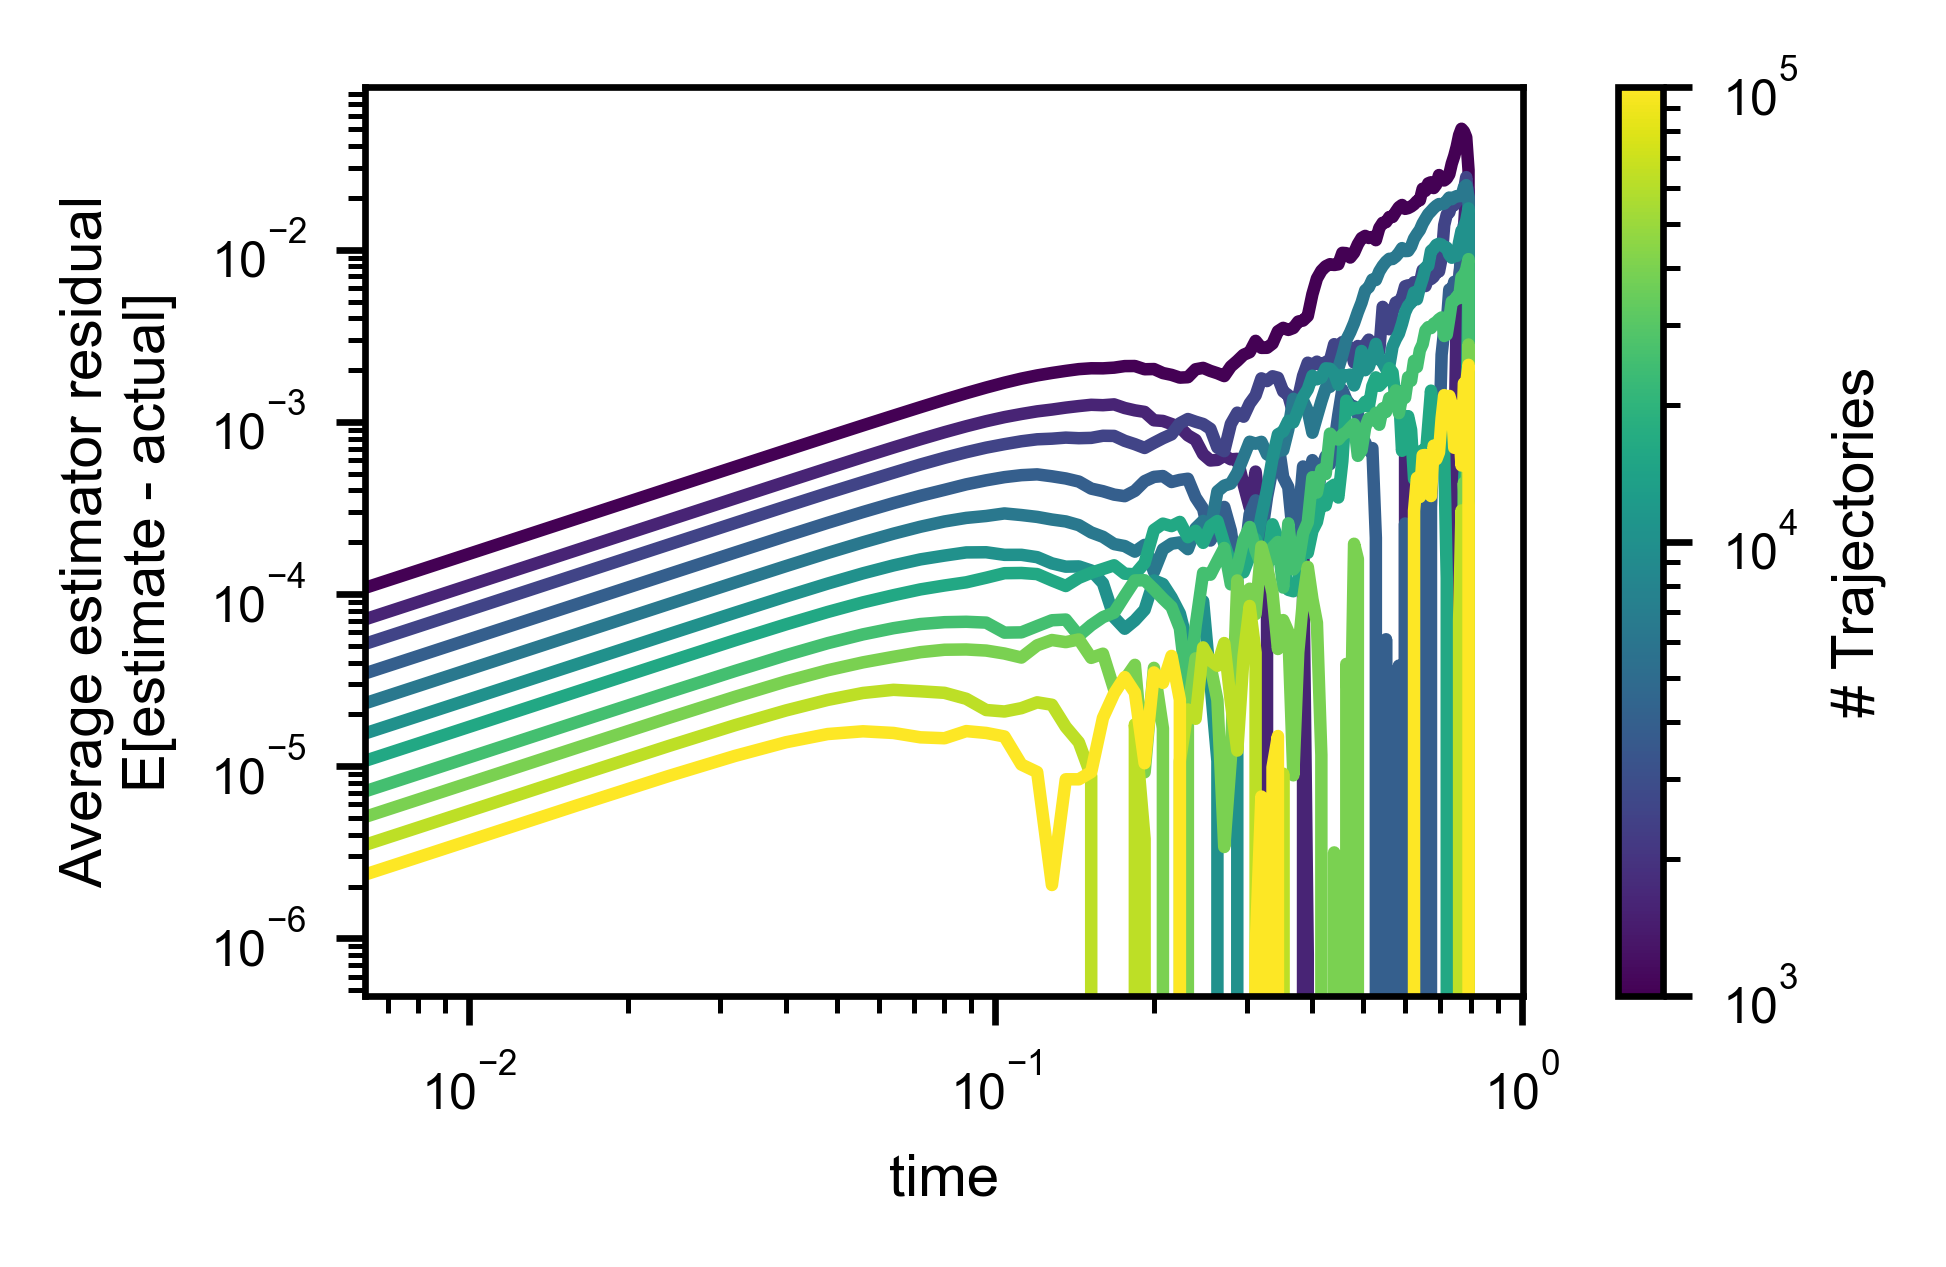

In [198]:
cnorm = mpl.colors.LogNorm(min(N_traj), max(N_traj))
cmap = mpl.cm.get_cmap('viridis')
sm = mpl.cm.ScalarMappable(cnorm, cmap)
sm.set_array([])

fig, ax = plt.subplots(
    figsize=fplt.figure_size['full column'],
    constrained_layout=True
)
var = var_pair[0]
for i, Nt in enumerate(N_traj):
    plt.plot(err_t, -err_aves[i][var.name], 
             color=cmap(cnorm(Nt)), label=f"N={Nt:e}")
cb = plt.colorbar(sm)
cb.set_label('# Trajectories')
plt.xscale('log')
plt.yscale('log')
# plt.legend()
plt.ylabel('Average estimator residual\n(estimate - actual)')
plt.xlabel('time')

Text(0, 0.5, '$E[||F_{est} - F_X||_2]$')

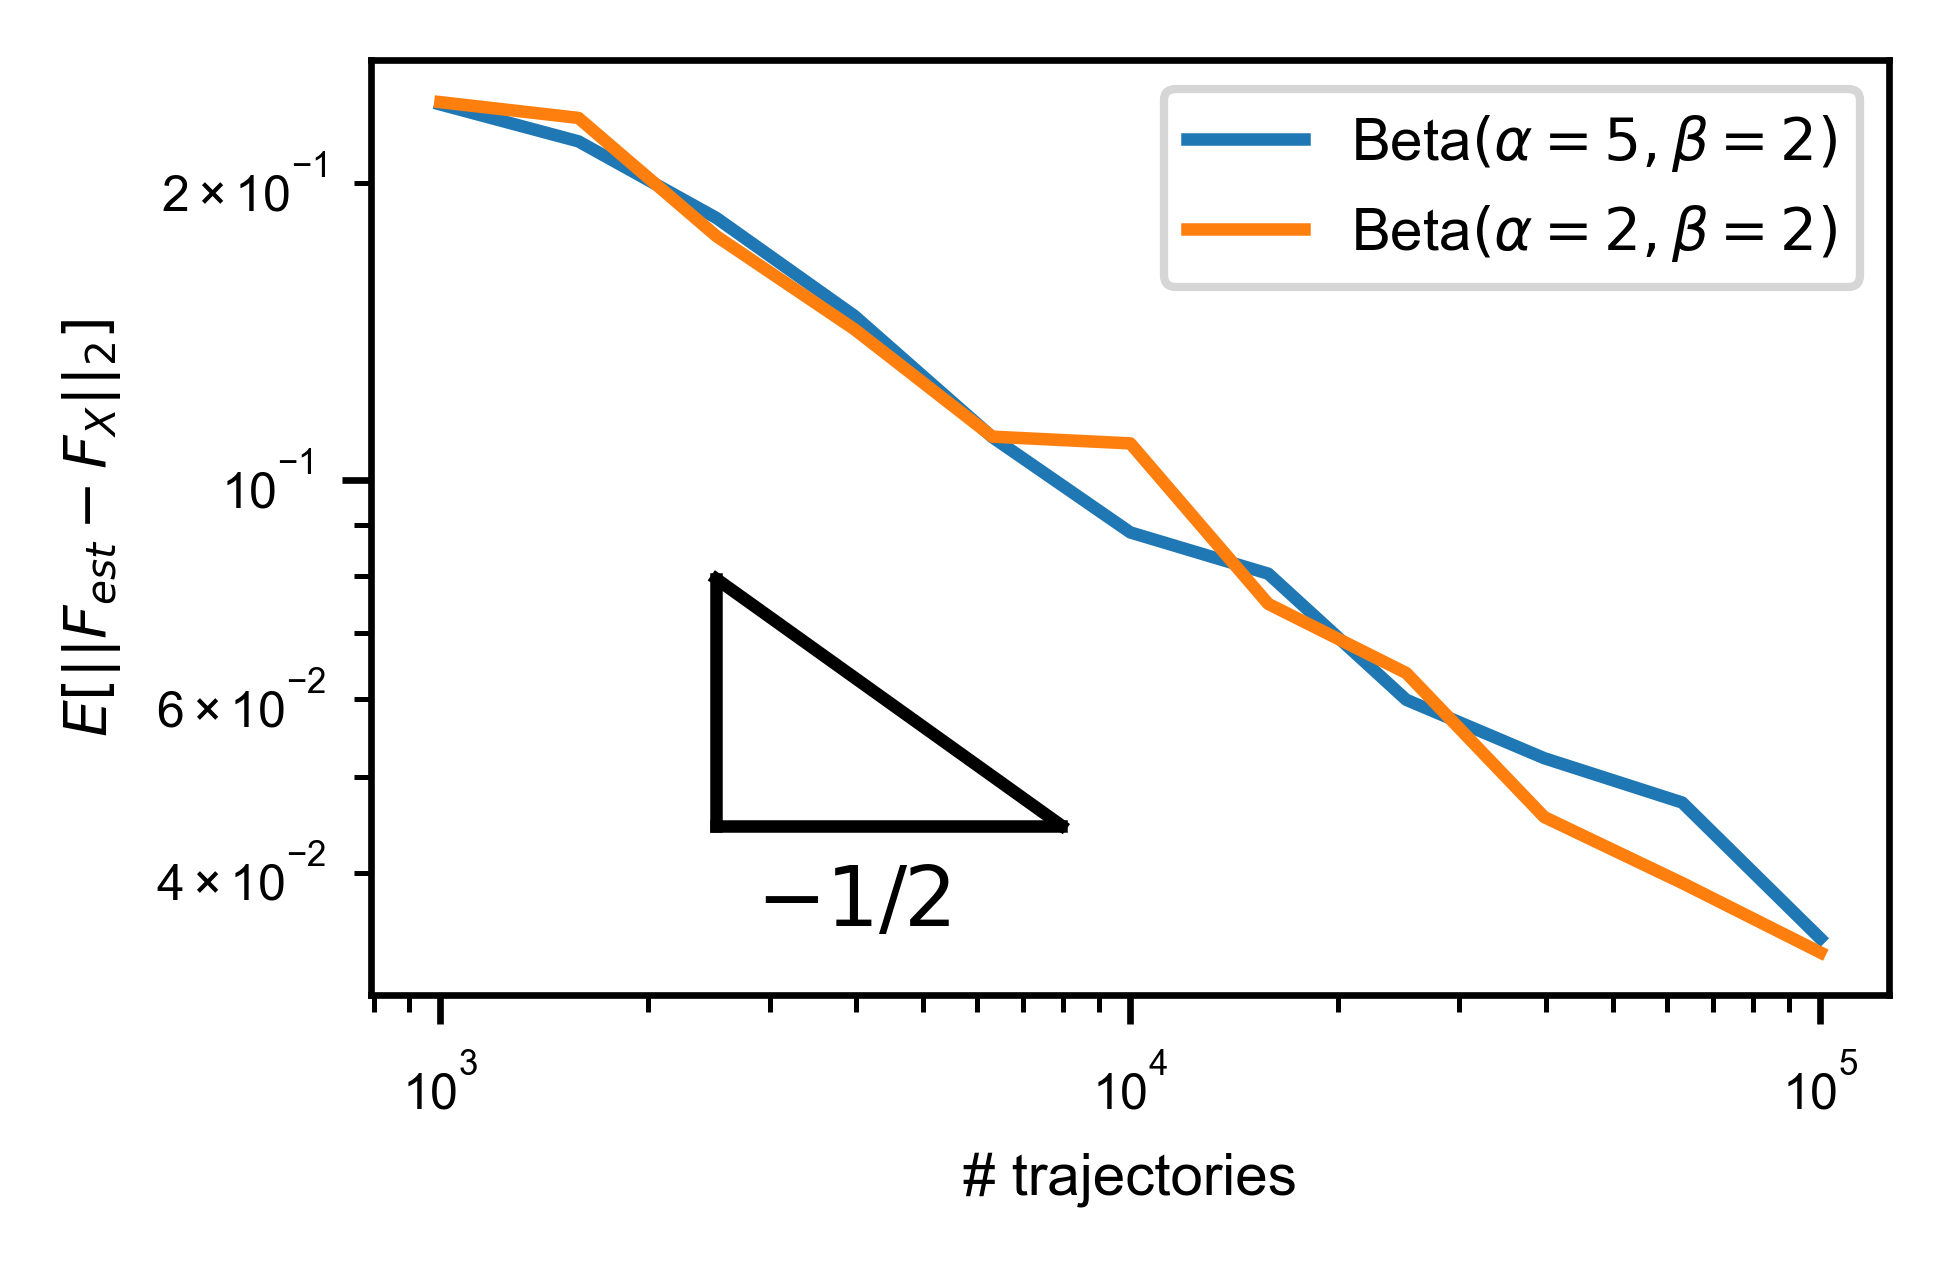

In [244]:
fig, ax = plt.subplots(
    figsize=fplt.figure_size['full column'],
    constrained_layout=True
)
for var in var_pair:
    plt.plot(N_traj, l2_aves[var.name], label=var.pretty_name)
bplt.draw_power_law_triangle(
    alpha=-1/2, x0=[3.4, -1.1], width=1/2, orientation='down',
    label='$-1/2$', label_padding=0.33, label_dx=[-500, 0]
)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('# trajectories')
plt.ylabel(r'$E[\|F_\text{est} - F_X\|_2^2]$')
plt.ylabel(r'$E[||F_{est} - F_X||_2]$')

### Exponential fit error

In [290]:
fit_folder = '/home/bbeltr1/Documents/work/ajspakow/finite-window/simulations/'
N_trajs = [100, 1000, 10000, 1e5]
fit_files = [
    'exp_fit_100000Nboot_100Ntraj-20210301-223758.csv',
    'exp_fit_10000Nboot_1000Ntraj-20210301-225249.csv',
    'exp_fit_1000Nboot_10000Ntraj-20210301-230620.csv',
    'exp_fit_100Nboot_100000Ntraj-20210301-232724.csv'
]
pretty_names = {
#     'corrected': 'Fully corrected CDF',
    'naive': 'Corrected eCDF fit',
    'count-based': 'Maximum Likelihood Estimator',
    'uncensored': 'Uncensored control, eCDF fit',
    'kaplan': 'Kaplan-Meier eCDF fit',
}


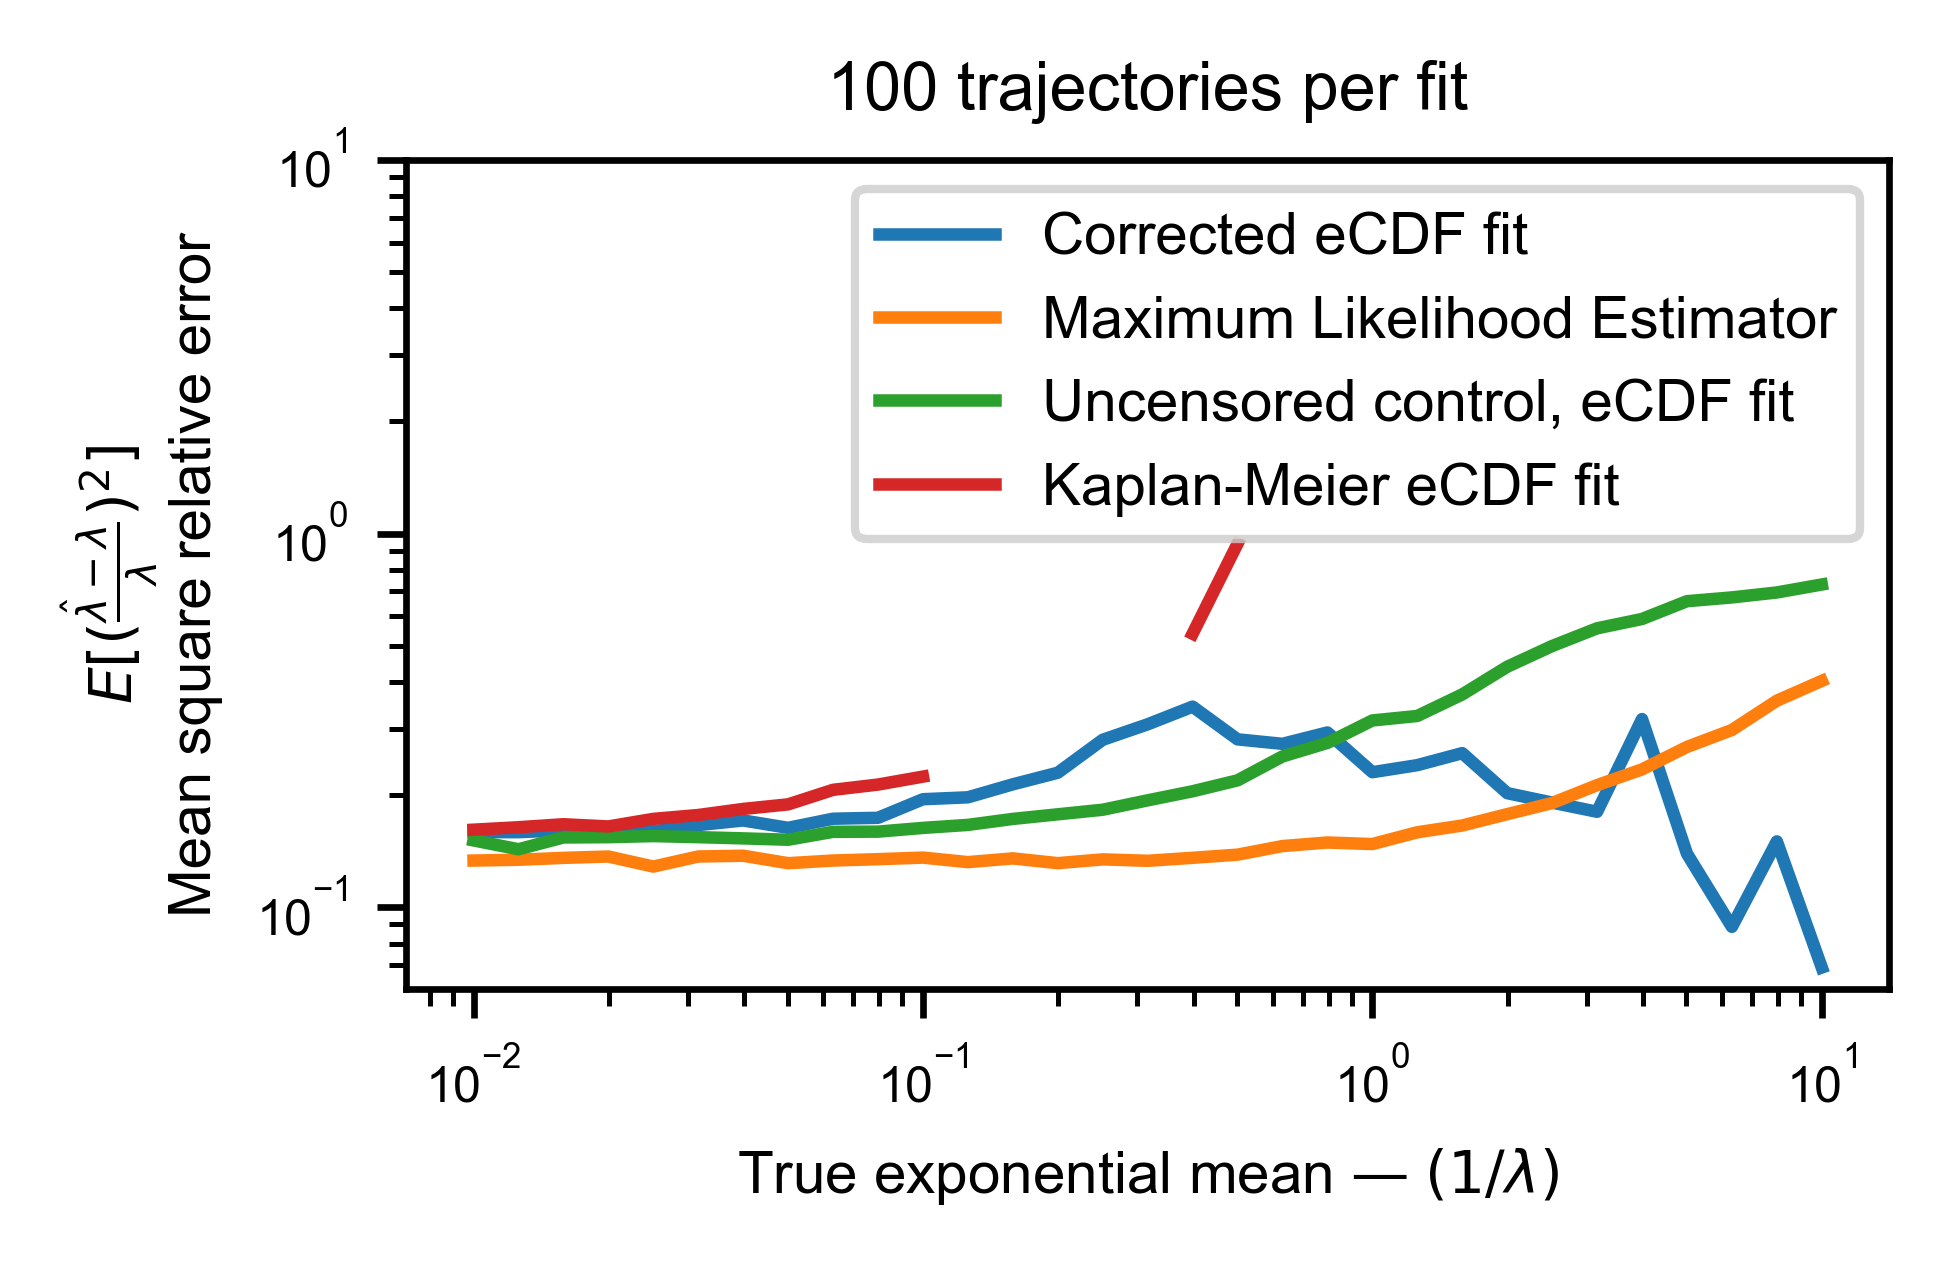

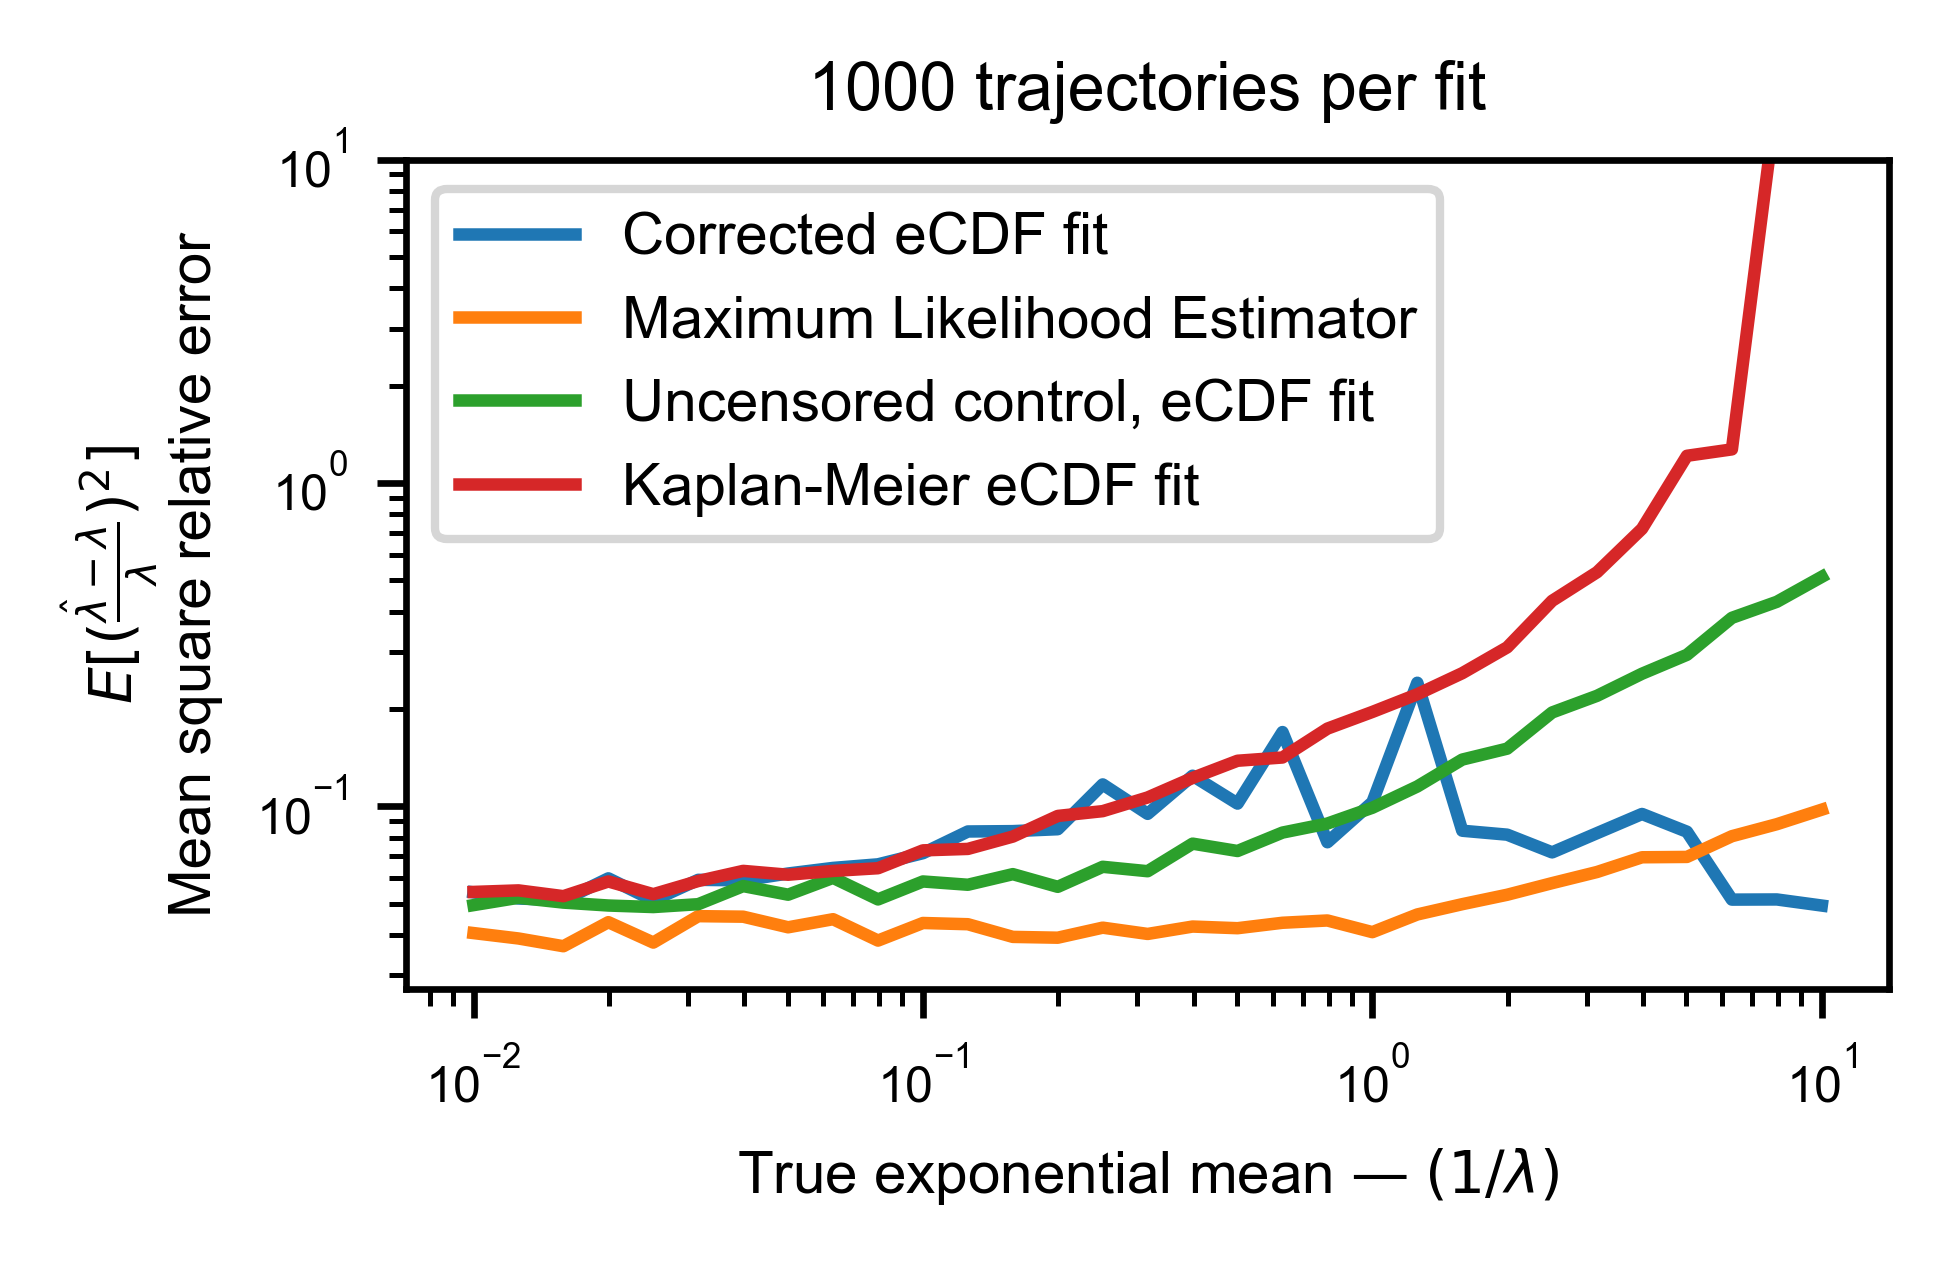

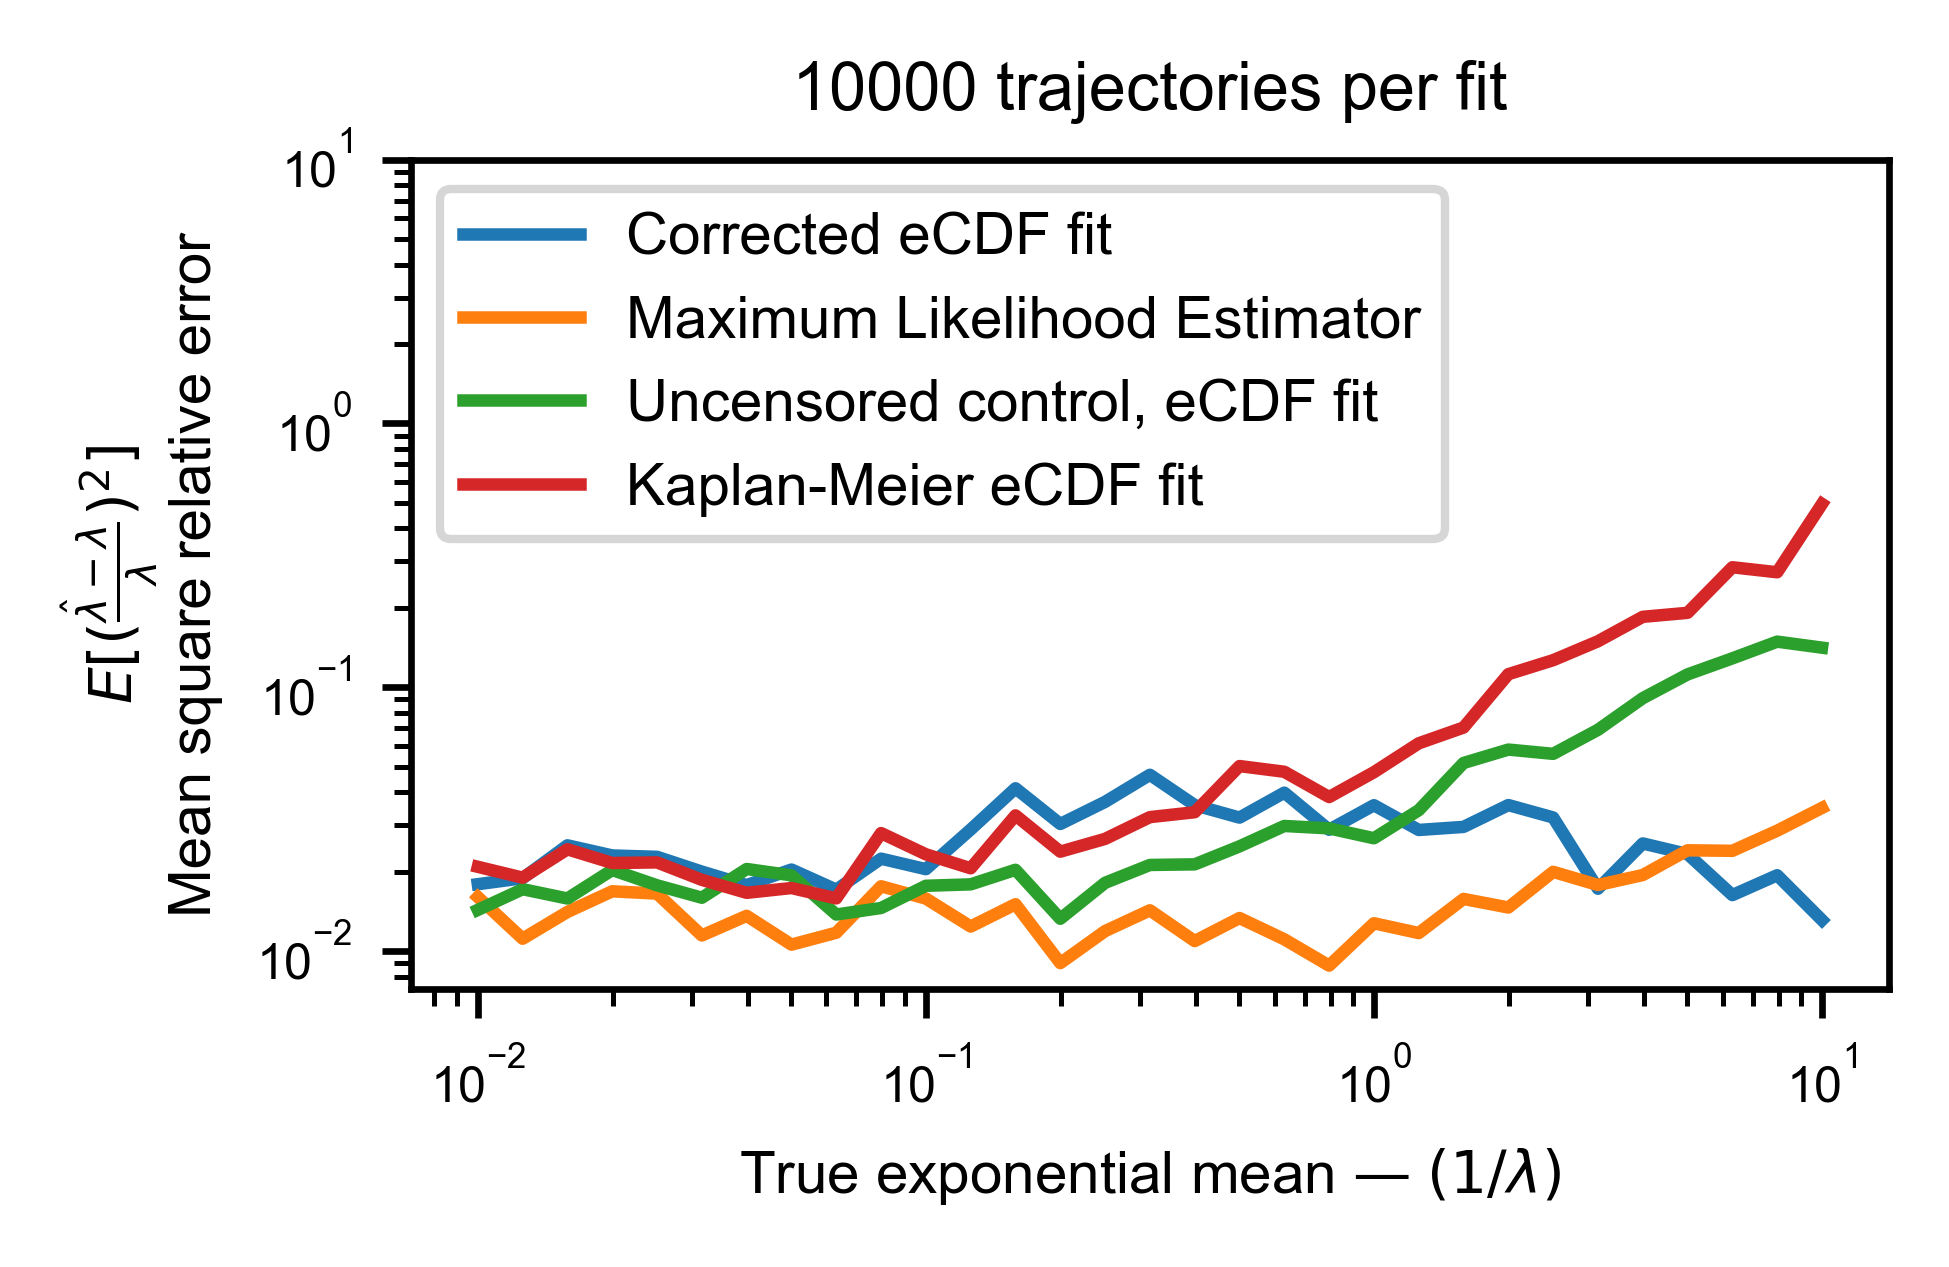

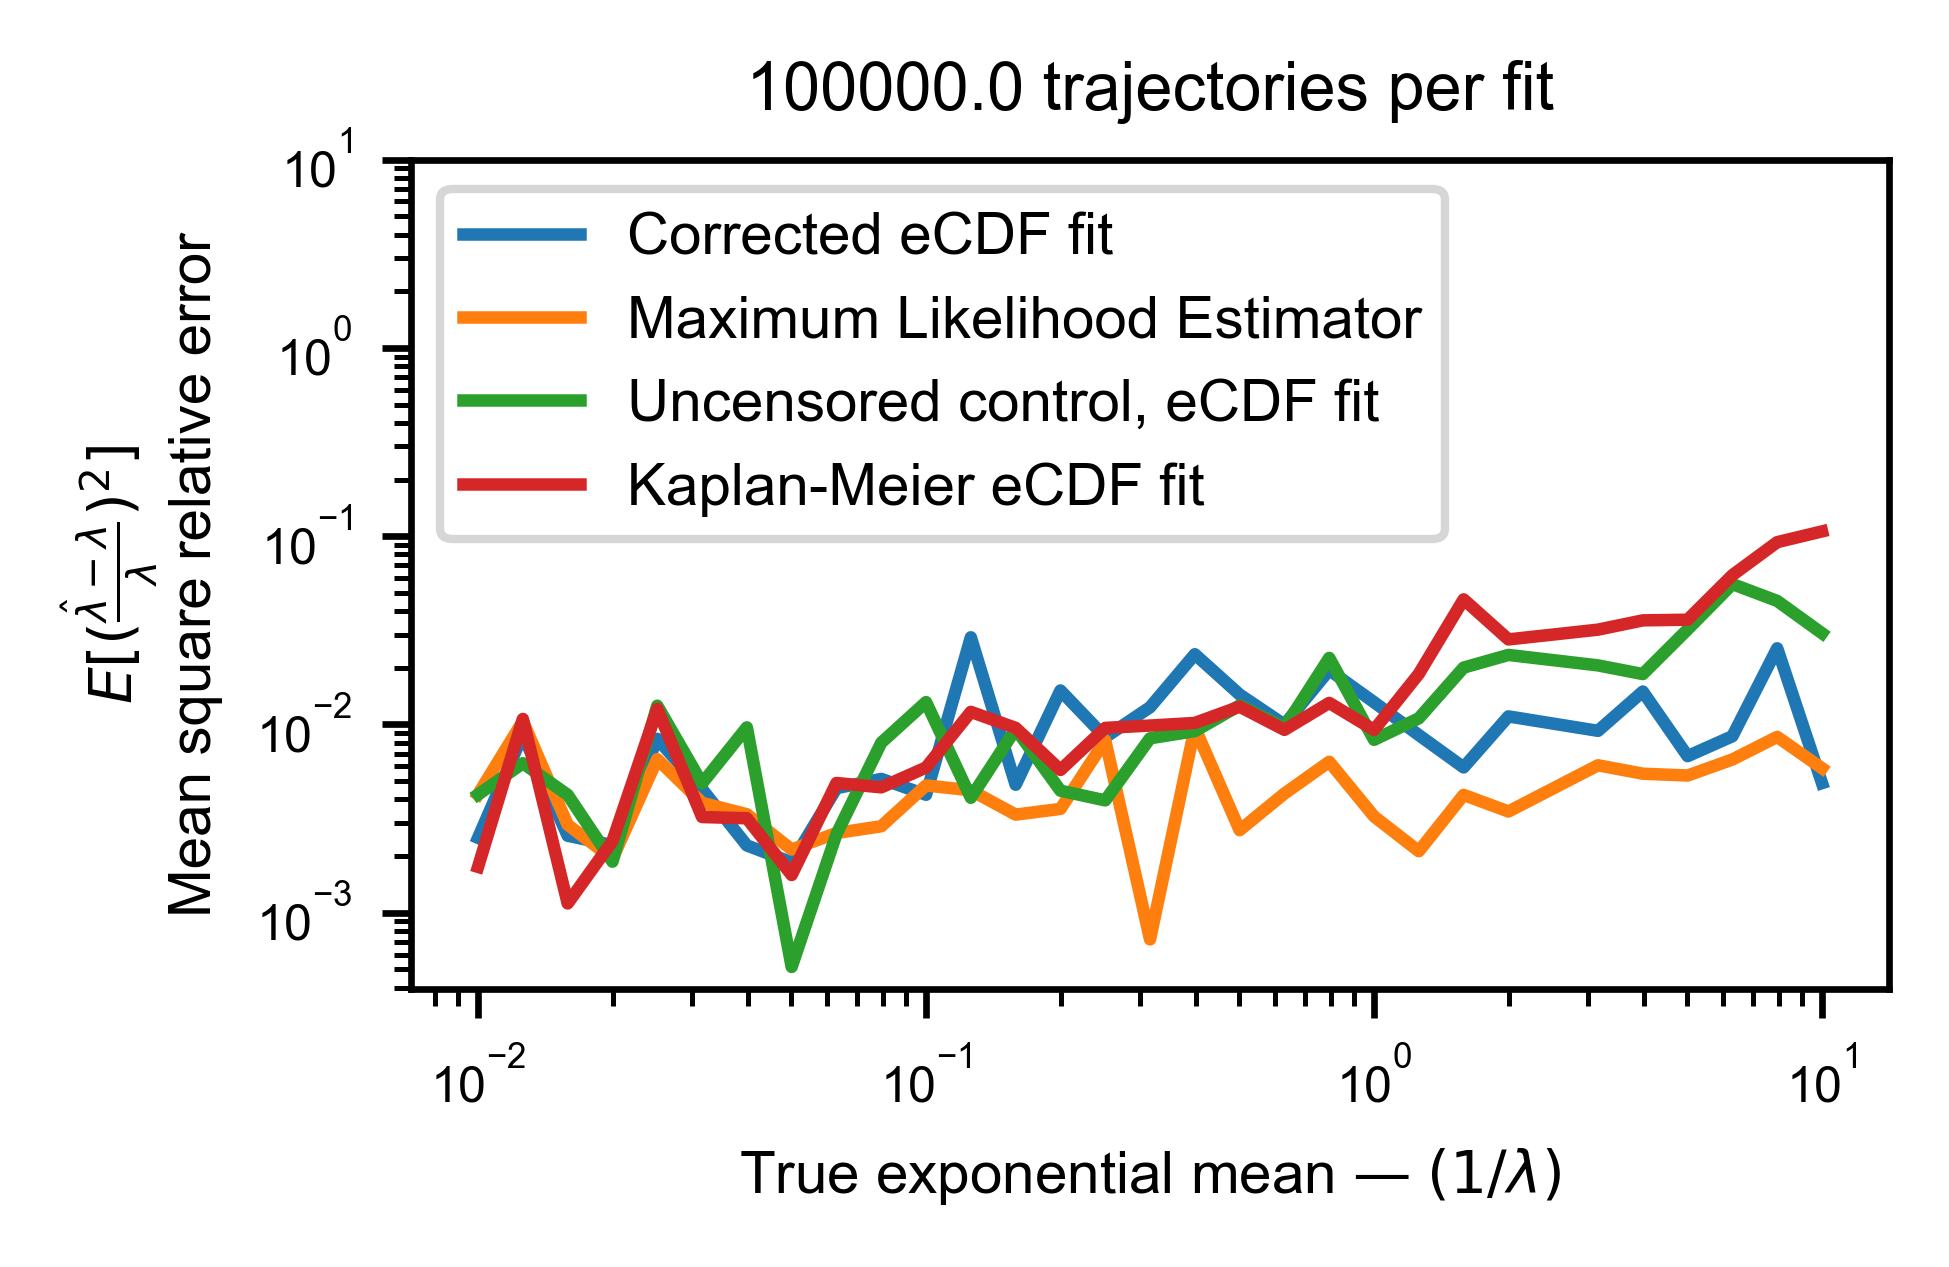

In [296]:
i = 0
N_traj = N_trajs[i]
fit_file = fit_files[i]

for fit_file, N_traj in zip(fit_files, N_trajs):
    exp_err = pd.read_csv(fit_folder + fit_file, index_col=0)
    exp_err.index.name = 'Variable'
    exp_err.head()

    res = exp_err.copy()
    for col in res.columns:
        if col in ['true', 'N_boot', 'N_traj']:
            continue
        res[col] = (res[col] - res['true'])/res['true']

    fit_stats = res.groupby('Variable').agg(['mean', 'std', 'count'])
    fit_stats = fit_stats.sort_values(('true', 'mean'))

    fig, ax = plt.subplots(
        figsize=fplt.figure_size['full column'],
        constrained_layout=True
    )

    lambdas = fit_stats['true']['mean']
    for name, pretty_name in pretty_names.items():
        line,  = ax.plot(lambdas, fit_stats[name]['std'], label=pretty_name)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    ylim = plt.ylim()
    plt.ylim([ylim[0], 1e1])
    plt.ylabel(
        r'$E[(\frac{\hat{\lambda} - \lambda}{\lambda})^2]$'
        + '\nMean square relative error'
    )
    plt.xlabel('True exponential mean — $(1/\lambda)$')
    plt.title(f'{N_traj} trajectories per fit')

### Power-law fit error

In [304]:
fit_folder = '/home/bbeltr1/Documents/work/ajspakow/finite-window/simulations/'
N_trajs = [1e5, 1e4, 1e3, 1e2]
fit_files = [
    'alpha_fit_100Nboot_100000Ntraj-20210302-063419.csv',
    'alpha_fit_1000Nboot_10000Ntraj-20210302-062245.csv',
    'alpha_fit_10000Nboot_1000Ntraj-20210302-061153.csv',
    'alpha_fit_100000Nboot_100Ntraj-20210302-060208.csv'
]
pretty_names = {
#     'corrected': 'Fully corrected CDF',
    'mle-interior': 'MLE, Interior times',
    'mle-uncensored': 'Uncensored control, MLE',
    'fit-uncensored': 'Uncensored control, eCDF fit',
    'fit-interior': 'Corrected eCDF fit',
    'fit-corrected': 'Rescaled eCDF fit',
    'fit-kaplan': 'Kaplan-Meier eCDF fit',
}


In [309]:
i = 0
N_traj = N_trajs[i]
fit_file = fit_files[i]

# for fit_file, N_traj in zip(fit_files, N_trajs):
alpha_err = pd.read_csv(fit_folder + fit_file, index_col=0)
alpha_err.index.name = 'Variable'
alpha_err

true  mle-interior  mle-uncensored  fit-interior  fit-corrected  \
Variable                                                                       
Pareto(1.1)   2.1      2.714632        2.135198      2.608376       2.060423   
Pareto(2)     3.0      3.441482        3.051359      3.184551       3.017198   

             fit-kaplan  fit-uncensored  N_boot  N_traj  
Variable                                                 
Pareto(1.1)    1.771052        2.131892     100    1000  
Pareto(2)      2.626863        3.057618     100    1000

In [301]:
res = alpha_err.copy()
for col in res.columns:
    if col in ['true', 'N_boot', 'N_traj']:
        continue
    res[col] = (res[col] - res['true'])/res['true']

fit_stats = res.groupby('Variable').agg(['mean', 'std', 'count'])
fit_stats = fit_stats.sort_values(('true', 'mean'))

In [308]:
fit_stats

true           mle-interior           mle-uncensored            \
            mean std count         mean std count           mean std count   
Variable                                                                     
Pareto(1.1)  2.1 NaN     1     0.292682 NaN     1       0.016761 NaN     1   
Pareto(2)    3.0 NaN     1     0.147161 NaN     1       0.017120 NaN     1   

            fit-interior  ... fit-kaplan fit-uncensored           N_boot      \
                    mean  ...      count           mean std count   mean std   
Variable                  ...                                                  
Pareto(1.1)     0.242084  ...          1       0.015187 NaN     1    100 NaN   
Pareto(2)       0.061517  ...          1       0.019206 NaN     1    100 NaN   

                  N_traj            
            count   mean std count  
Variable                            
Pareto(1.1)     1   1000 NaN     1  
Pareto(2)       1   1000 NaN     1  

[2 rows x 27 columns]

Text(0.5, 1.0, '100000.0 trajectories per fit')

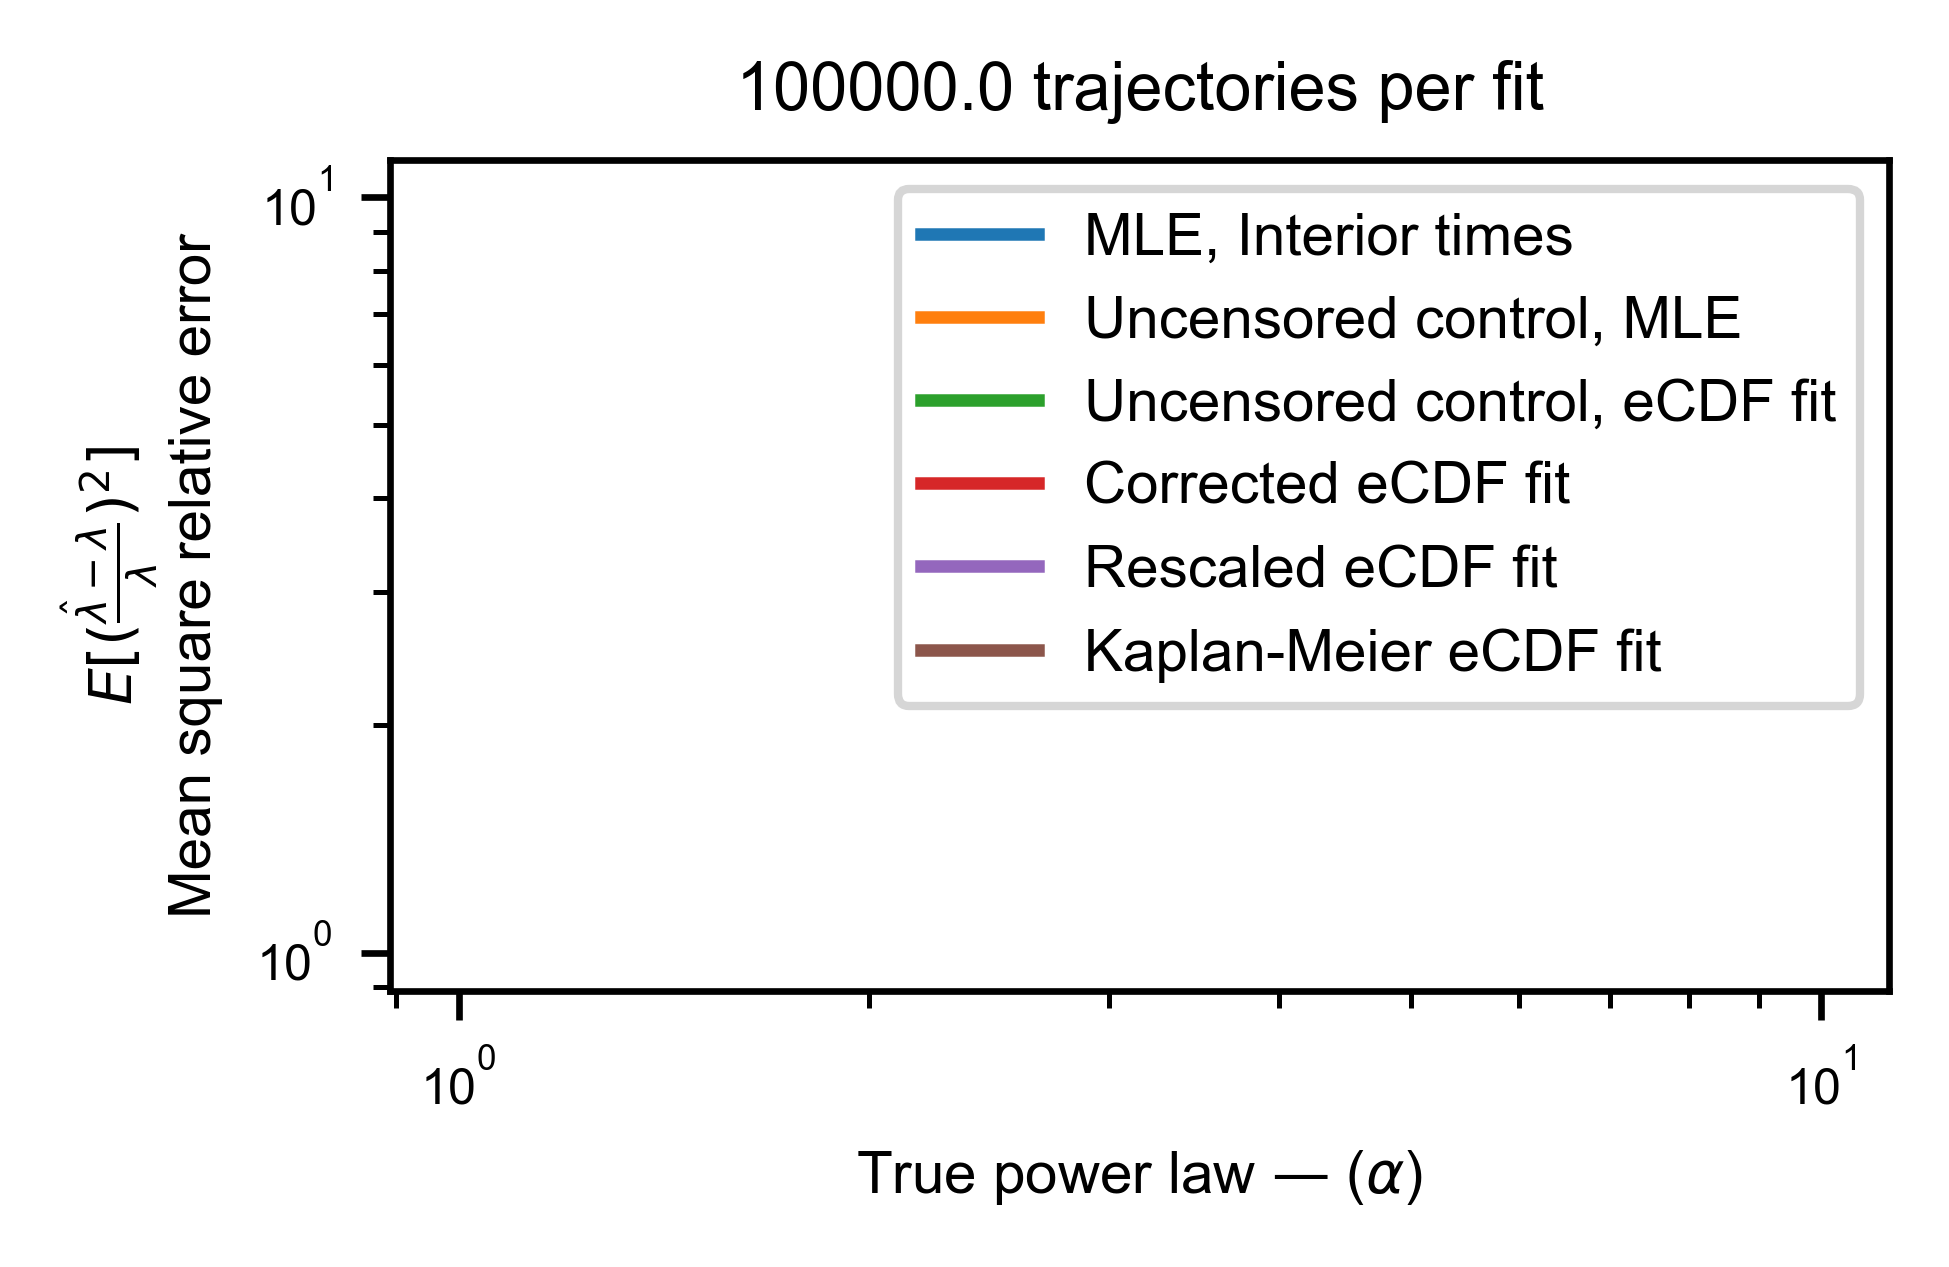

In [307]:
fig, ax = plt.subplots(
    figsize=fplt.figure_size['full column'],
    constrained_layout=True
)

lambdas = fit_stats['true']['mean']
for name, pretty_name in pretty_names.items():
    line,  = ax.plot(lambdas, fit_stats[name]['std'], label=pretty_name)
plt.xscale('log')
plt.yscale('log')
plt.legend()
ylim = plt.ylim()
# plt.ylim([ylim[0], 1e1])
plt.ylabel(
        r'$E[(\frac{\hat{\lambda} - \lambda}{\lambda})^2]$'
        + '\nMean square relative error'
    )
plt.xlabel(r'True power law — ($\alpha$)')
plt.title(f'{N_traj} trajectories per fit')

## Theoretical Details


The following section contains a complete derivation of the framework used to
generate the corrections used in this module.

### Motivating (A)synchronicity

We first motivate our definition of "(a)synchronicity", the critical property
that allows us to correct for the effects of observing in a finite window.

Suppose a process starts at :math:`-t_\text{inf}` (WLOG, assume it starts in
state :math:`A`). For times after :math:`-t_\text{inf} \lll 0`, the process switches
between states :math:`A` and :math:`B`. The distribution of times spent in each
state before switching are IID, and distributed like :math:`f_A(t)` and
:math:`f_B(t)`, respectively. We then are able to observe the process during the
interval of time :math:`[0, T]`.

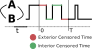

In [86]:
from IPython.core.display import SVG
SVG(filename='./images/waiting-time-base-diagram.svg')

This can be thought of as a renewal(-reward) process that started far in the
past. As long as the starting point, :math:`-t_\text{inf}`, is sufficiently far
in the past, and the distributions :math:`f_*(t)` have finite variance, various
convenient properties hold true for the observed state switching times between
:math:`0` and :math:`T`. We use the same example as in the "tutorial" section in
what follows.

In [ ]:
import scipy.stats
from multi_locus_analysis import finite_window as fw
e44 = scipy.stats.expon(scale=4, loc=4)
e16 = scipy.stats.expon(scale=6, loc=1)
trajs = fw.ab_window([e44.rvs, e16.rvs], window_size=20, offset=-1000,
    num_replicates=10000, states=['exp(4,4)', 'exp(1,6)'])

The first convenient property is that the switching times are uniformly
distributed within the observation interval (as
:math:`-t_\text{inf}\to-\infty`). Intuitively, this just means that
:math:`-t_\text{inf}` is far enough in the past that, independently of the
distribution, we are not biased towards the switching times being early or late
in our observation interval (i.e. we have lost all memory of the "real" start
time).

In [ ]:
plt.figure(figsize=[4,3])
plt.hist(trajs['start_time'].values, 100)
plt.xlim([0, 20])
plt.xlabel('Rate of "creation of left ends"')

Now let's label the observed state switches as :math:`t_0,\ldots{},t_{n-1}`,
with :math:`t_0` and :math:`t_n` corresponding to the "actual" (unobserved)
state switch times flanking the observation interval.
The next useful property is that the start of the observation interval
(:math:`t=0`) is uniformly distributed within :math:`[t_0, t_1]` (similarly, the
end of the observation interval, :math:`t=T`, is uniformly distributed in
:math:`[t_{n-1}, t_n]`.

In [ ]:
plt.figure(figsize=[4,3])
t01 = trajs[trajs['start_time'] < 0]
u = -t01['start_time']/(t01['end_time'] - t01['start_time'])
plt.hist(u, 100)
plt.xlabel('Fraction of way between state changes at $t=0$.')

For the interior times, we can simply use the first fact to derive our interior
time correction. Since we know the starting times of each state are uniformly
distributed, we immediately can tell that if a waiting time of length
$\tau$ has a start time within the interval, then the the fraction of
times that this waiting time will end up being an interior time is just
$(T - \tau)/T$. More precisely, we have that

$$
    P(t_{i+1} \leq T | t_{i+1}-t_i=\tau, t_i \in [0,T]) = \int_0^T 1_{t_i + \tau
    \leq T} f_{\text{Unif}[0,T]}(t_i) dt_i
$$

which is just equal to :math:`(T - \tau)/T`.

This correction factor can be visualized easily as simply counting what fraction
of "start" times of a given length lead to "end" times still inside the
interval. Namely, it's the green part of the interval in the following diagram:

.. image:: images/waiting-time-censored-fraction.svg

    :width: 400
    
    :alt: pictoral demonstration of equation above

On the other hand, we have to be careful about the distribution of exterior
times, even if we do somehow magically have the values
of :math:`t_0` and the state at :math:`t=0`. You can't simply assume that
:math:`t_1 - t_0` is distributed like :math:`f_A(t)` or :math:`f_B(t)`. After
all, in fact it is distributed like :math:`tf_*(t)`. This is because (loosely
speaking) if you fill the real line with a bunch of intervals whose lengths are
distributed like :math:`f(t)`, then you choose a point on the real line at
random, you are more likely to land in an interval of size :math:`t` the longer
that :math:`t` is.

In [ ]:
plt.figure(figsize=[4,3])
a1 = t01[t01['state'] == 'exp(4,4)']
x, cdf = fw.ecdf(a1['end_time'] - a1['start_time'])
kernel = fw.smooth_pdf(x, cdf)
plt.plot(x, kernel(x), label=r'$\hat{f}(t)$: Observed CDF of $t_1 - t_0$')
plt.plot(x, e44.pdf(x), label=r'$f(t)$: Actual CDF of exp(4,4)')
Z = scipy.integrate.quad(lambda x: x*e44.pdf(x), 0, np.inf)
plt.plot(x, x*e44.pdf(x)/Z[0], label=r'$t f(t)/\int_0^\infty t f(t) dt$')
plt.legend()

### (A)synchronicity

While the explicit framework presented above is a useful tool, it is ill-defined
for heavy-tailed processes, in which we are primarily concerned when making
these types of corrections. In order to retain the useful properties of the
system that made it possible to derive the interior and exterior times
distributions, we simply notice that the *real* property that we want to be true
when measuring these systems is *asynchronicity*, or what a physicist might call
"symmetry under time translations" or "time homogeneity". In short, we want to
impose the constraint that we are only interested in scientific measurements
where changing the interval of observation :math:`[0, T]` to
:math:`[0+\tau,T+\tau]` for any :math:`\tau` will not change any properties of
the measurement.

<div class="alert alert-info">

    We leave as an exercise to the reader to show that:

    1. the renewal process of the previous section is a special case of an asynchronous process
    2. this definition of asynchronicity produces all three properties we demonstrated for our renewal process above
   
</div>

On the other extreme from asynchronicity is the situation in which the
Meier-Kaplan correction was originally designed to be used. Namely, we could
imagine that a perfectly *synchronous* process is one where :math:`t_0` is fixed
to be at time :math:`t=0`, meaning that :math:`t_1 - t_0` is distributed as just
:math:`f_*(t)`.

While in principle anything between asynchrony and synchrony is possible, it is
true in general that almost all scientific measurements area already done using
either purely synchronous or asynchronous systems, since it is intuitively clear
that a lack of understanding of the synchronicity of one's system can lead to
uninterpretable results.

### Laplace Formalism


TODO: fill in alternative formulation of system here.

Which also has a convenient alias: `multi_locus_analysis.finite_window.movie_to_waits`:

In [10]:
import pandas as pd

In [20]:
from multi_locus_analysis import stats

import lifelines
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns

import bruno_util.plotting as bplt
figure_size = bplt.use_cell_style(mpl.rcParams)

km_color = sns.color_palette('colorblind')[0]
interior_color = sns.color_palette('colorblind')[1]
interior_linestyle = '-.'


def compare_interior_kaplan(waits, var_pair, rescale_kaplan=False,
                            rescale_interior=False):
    """
    Interior vs kaplan est for `multi_locus_analysis.finite_window.ab_window`.

    Compare the Kaplan-Meier estimator to the empirical distribution function
    (eCDF) of interior times of data generated using the
    `multi_locus_analysis.finite_window.ab_window` or
    `multi_locus_analysis.finite_window.ab_window_fast` functions.
    """
    kmfs = {}
    for name, state in waits.groupby('state'):
        times = state['wait_time'].values
        not_censored = (state['wait_type'] == 'interior').values
        kmfs[name] = lifelines.KaplanMeierFitter().fit(
            times, event_observed=not_censored,
            label=r'Meier-Kaplan Estimator, $\pm$95% conf int'
        )

    fig = plt.figure(
        figsize=figure_size['two-by-half column, four legend entries above'],
        constrained_layout=True
    )
    axs = fig.subplot_mosaic([[var.name for var in var_pair]])

    T = waits.window_size.max()
    for var in var_pair:
        # lifelines insists on returning a new Axes object....so we have to
        # plot it first
#         ax = kmfs[var.name].plot_cumulative_density(
#             color=km_color, ax=axs[var.name]
#         )
#         km_l = mpl.lines.Line2D([], [], color=km_color, label='Kaplan-Meier')

        ax = axs[var.name]
    
        tk = kmfs['Beta(2, 2)'].cumulative_density_.index.values
        kmf = kmfs['Beta(2, 2)'].cumulative_density_.values
        Z = 1
        Z = kmf[-1] / var.cdf(T)
        km_l = ax.plot(tk, kmf/Z, color=km_color, label='Kaplan-Meier')

        # plot actual distribution
        t = np.linspace(0, T, 100)
        analytical_l,  = ax.plot(
            t, var.cdf(t), color='k', label='Actual CDF'
        )

        # now compute the empirical distribution of the "interior" times
        interior = waits.loc[
            (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
            'wait_time'
        ].values
        x, cdf = fw.ecdf(interior, pad_left_at_x=0)

        interior_l, = ax.plot(
            x, cdf*var.cdf(x[-1]), c=var.color, ls=interior_linestyle,
            label='"Interior" eCDF'
        )

        # prettify the plot
        ax.set_xlim([0, waits.window_size.max()])
        ax.set_ylim([0, 1])
        ax.set_xlabel('time')
        ax.set_ylabel(r'Cumulative probability')

        ax.legend(
            title=var.pretty_name,
            handles=[interior_l, km_l, analytical_l],
            # align bottom of legend 2% ax height above axis, filling full axis
            # width
            bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncol=1, mode="expand", borderaxespad=0.
        )
    return fig



In [10]:
waits = observations['beta']

In [11]:
var_pair = variable_pairs['beta']

In [18]:
tk = kmfs['Beta(2, 2)'].cumulative_density_.index.values
kmf = kmfs['Beta(2, 2)'].cumulative_density_.values

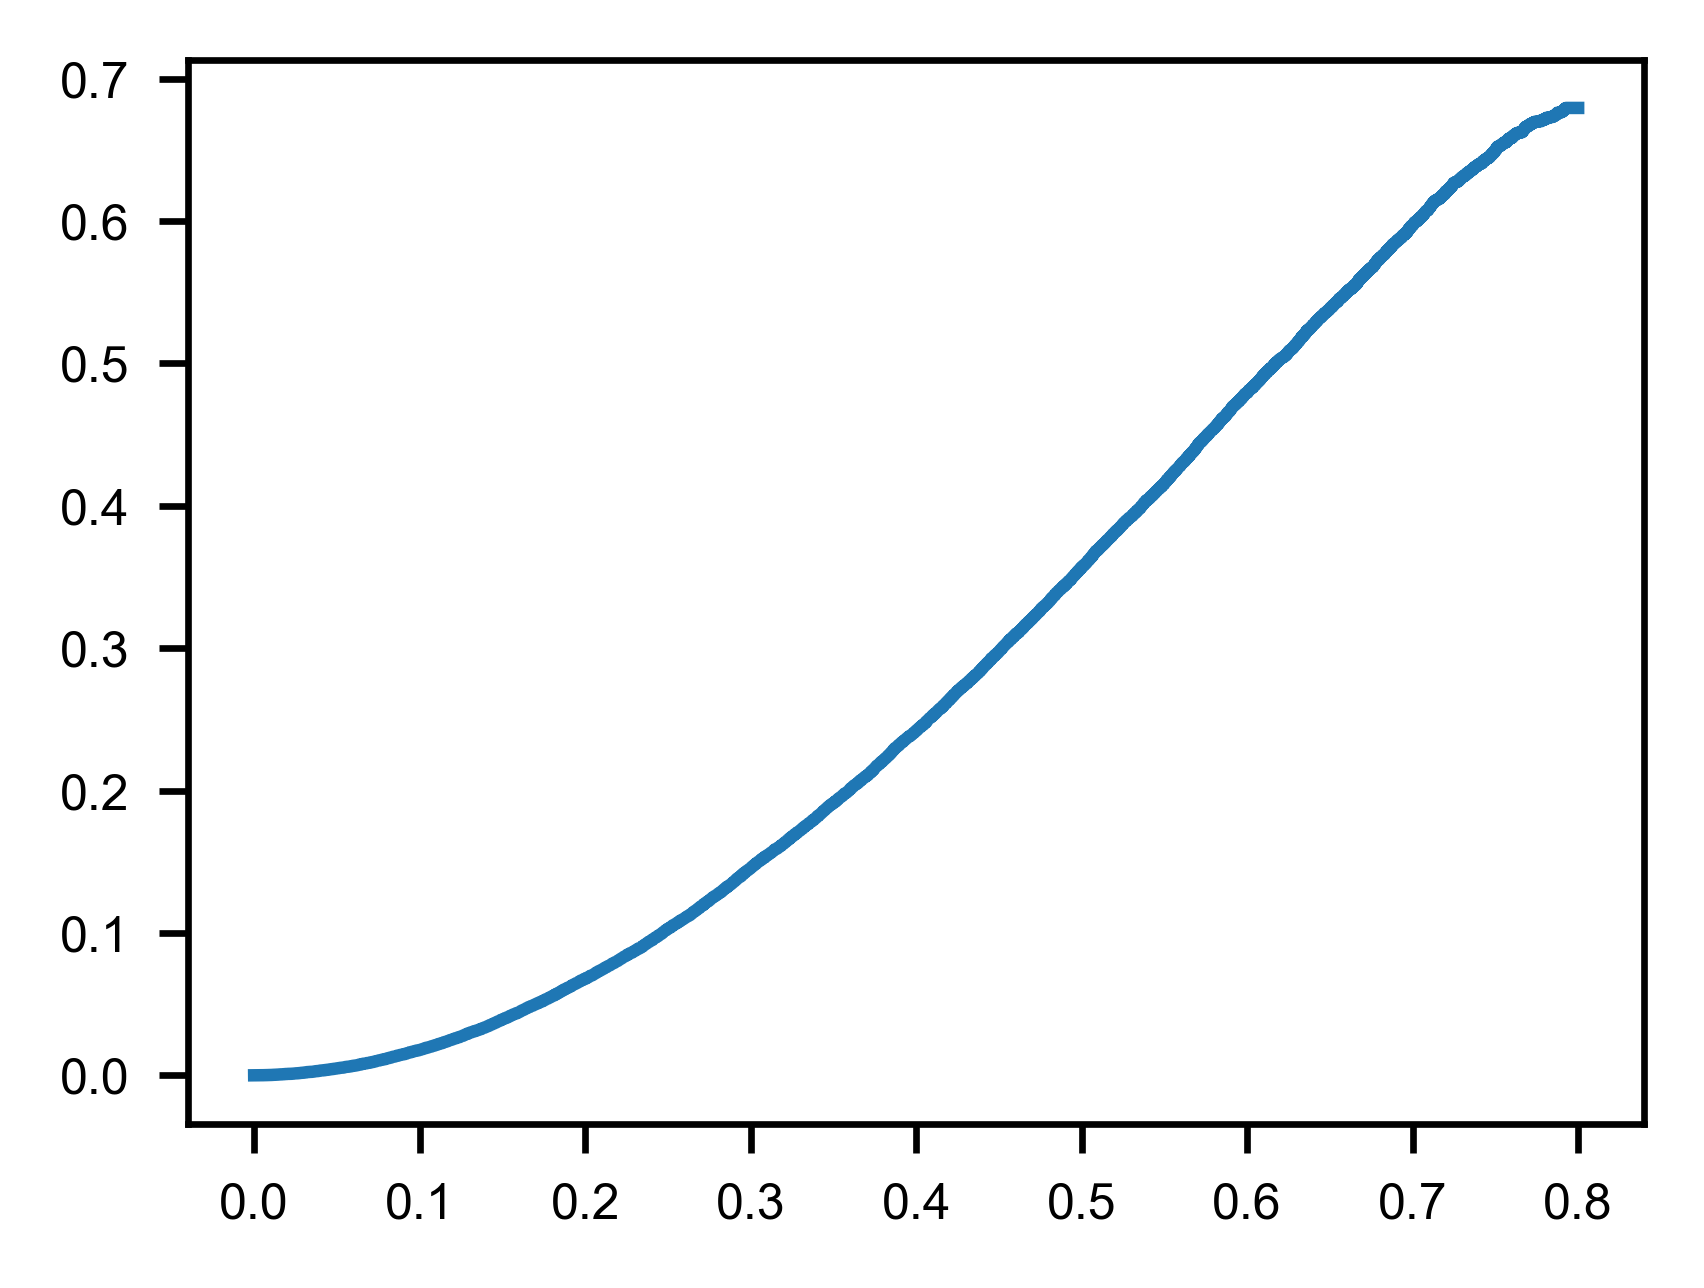

In [19]:
plt.plot(tk, kmf/kmf[-1]*)

In [29]:
low, high = kmfs['Beta(2, 2)'].confidence_interval_cumulative_density_.values.T

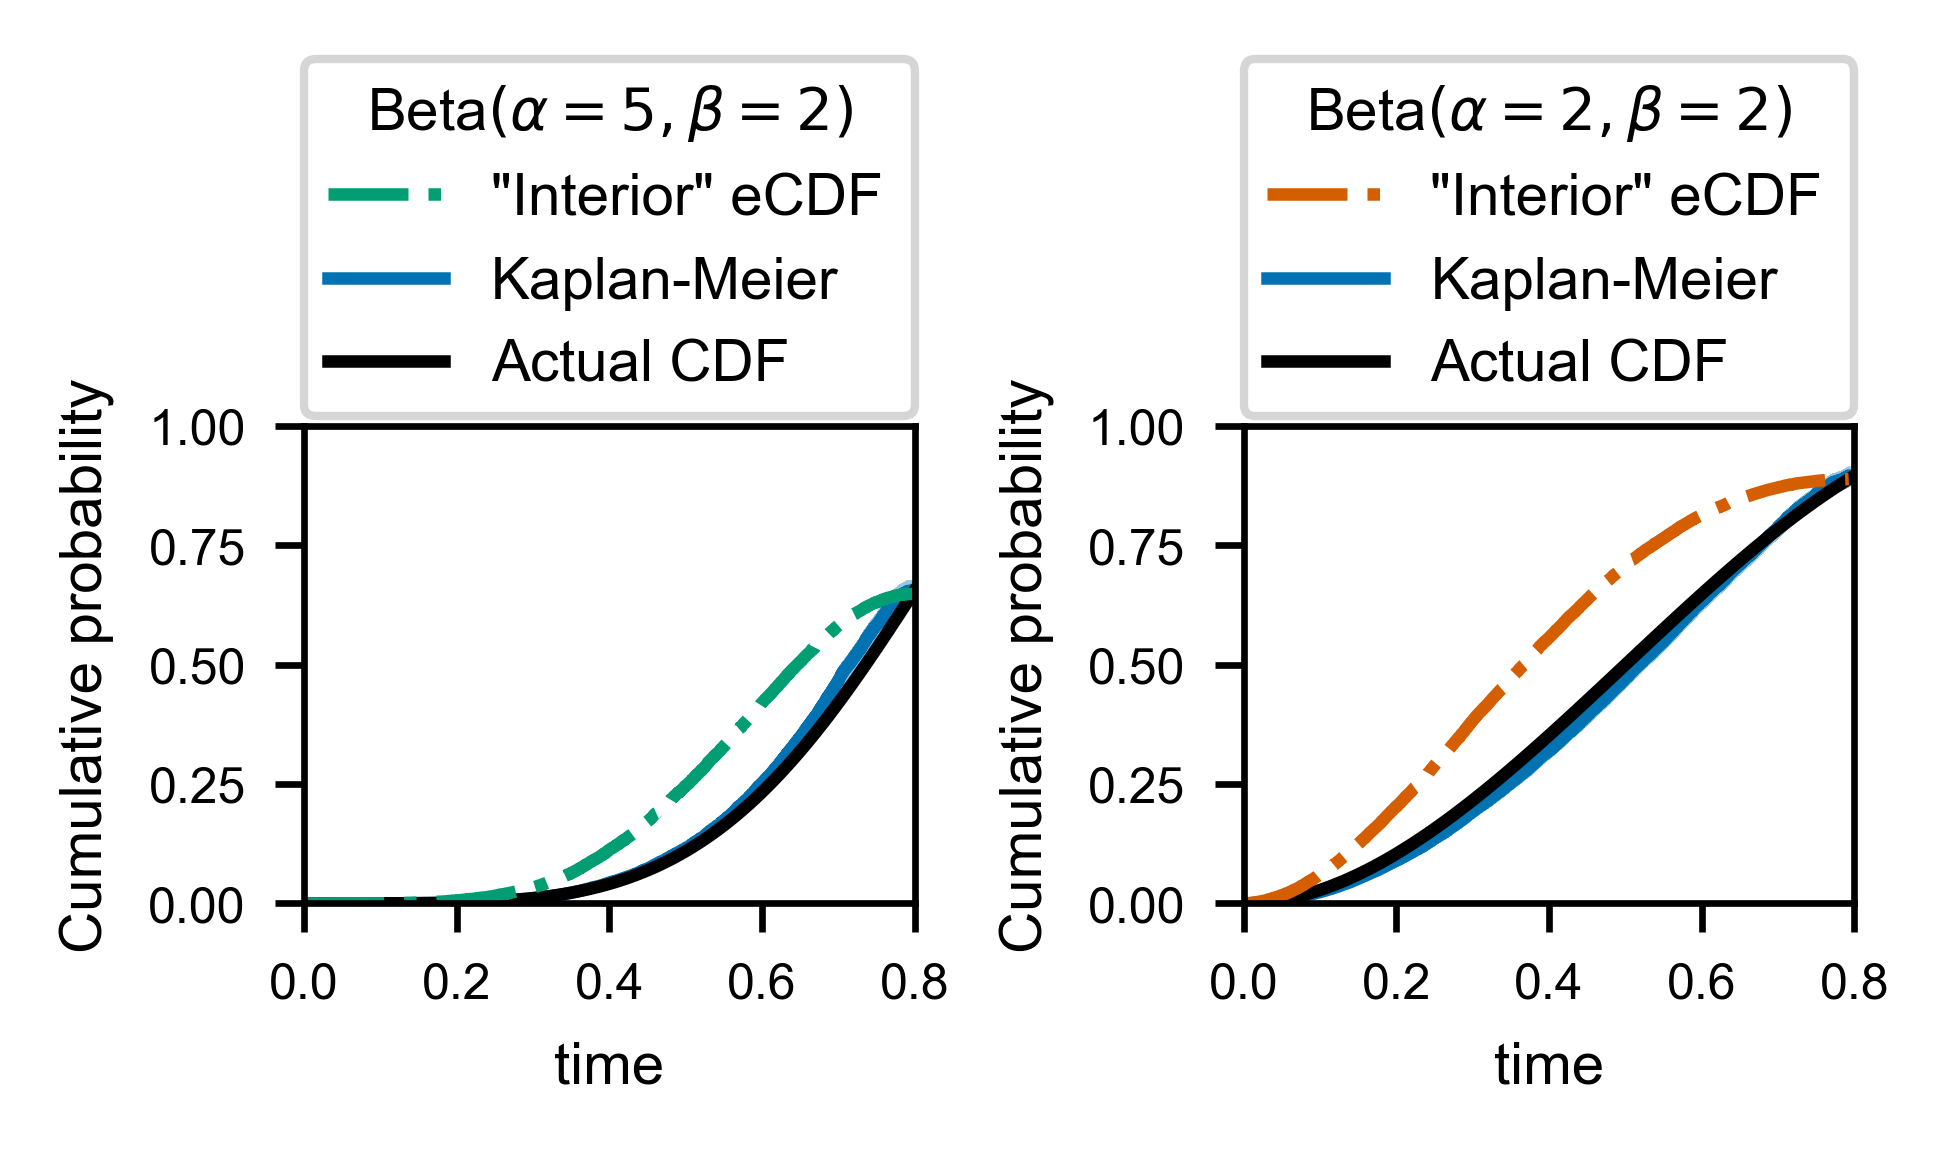

In [32]:
kmfs = {}
for name, state in waits.groupby('state'):
    times = state['wait_time'].values
    not_censored = (state['wait_type'] == 'interior').values
    kmfs[name] = lifelines.KaplanMeierFitter().fit(
        times, event_observed=not_censored,
        label=r'Meier-Kaplan Estimator, $\pm$95% conf int'
    )

fig = plt.figure(
    figsize=figure_size['two-by-half column, four legend entries above'],
    constrained_layout=True
)
axs = fig.subplot_mosaic([[var.name for var in var_pair]])

T = waits.window_size.max()
for var in var_pair:
    # lifelines insists on returning a new Axes object....so we have to
        # plot it first
#         ax = kmfs[var.name].plot_cumulative_density(
#             color=km_color, ax=axs[var.name]
#         )
#         km_l = mpl.lines.Line2D([], [], color=km_color, label='Kaplan-Meier')

    ax = axs[var.name]

    tk = kmfs[var.name].cumulative_density_.index.values
    kmf = kmfs[var.name].cumulative_density_.values
    Z = 1
    Z = kmf[-1] / var.cdf(T)
    km_l = ax.plot(tk, kmf/Z, color=km_color, label='Kaplan-Meier')[0]
    low, high = kmfs[var.name].confidence_interval_cumulative_density_.values.T
    ax.fill_between(tk, low/Z, high/Z, color=km_color, alpha=0.4)
    # plot actual distribution
    t = np.linspace(0, T, 100)
    analytical_l,  = ax.plot(
        t, var.cdf(t), color='k', label='Actual CDF'
    )

    # now compute the empirical distribution of the "interior" times
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        'wait_time'
    ].values
    x, cdf = fw.ecdf(interior, pad_left_at_x=0)

    interior_l, = ax.plot(
        x, cdf*var.cdf(x[-1]), c=var.color, ls=interior_linestyle,
        label='"Interior" eCDF'
    )

    # prettify the plot
    ax.set_xlim([0, waits.window_size.max()])
    ax.set_ylim([0, 1])
    ax.set_xlabel('time')
    ax.set_ylabel(r'Cumulative probability')

    ax.legend(
        title=var.pretty_name,
        handles=[interior_l, km_l, analytical_l],
        # align bottom of legend 2% ax height above axis, filling full axis
        # width
        bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
        ncol=1, mode="expand", borderaxespad=0.
    )